---

<center><h1 style="font-size:40px;">Project 1<br>Image Segmentation using CNNs</h1></center>

---

In this project, we will design a CNN-based **encoder-decoder architecture** to segment rgb images. Image segmentation refers to dividing the image into semantically meaningful regions. For instance, representing each object in the scene with a unique shape or color. In this project, your goal is to successfully run a segmentation program to segment different shapes from Flying Object dataset.

Good luck!

---

Start with 32x32 resolution Use skip connections Final results on 128x128 resolution No report to be submitted! A short presentation is needed Describe the network architecture Show experimental results


In [1]:
from torch import optim
import numpy as np
import matplotlib.pyplot as plt
from torch.nn import functional as F
from torch.utils.tensorboard import SummaryWriter
import torch
from torch import nn
import imageio
import torchvision
import math
from torch.utils.data import DataLoader
from collections import OrderedDict
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)  
from torch.utils.data import Dataset
from PIL import Image
from torchvision import transforms
from torch.nn import CrossEntropyLoss
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import ReduceLROnPlateau

2024-02-15 22:00:51.898977: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-15 22:00:51.927765: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-15 22:00:51.927791: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-15 22:00:51.928726: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-15 22:00:51.933937: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructio

In [2]:
training_img_dir = "FlyingObjectDataset_10K/training"
validation_img_dir = "FlyingObjectDataset_10K/validation"
testing_img_dir = "FlyingObjectDataset_10K/testing"

# Task 1
Based on the code provided for the previous lab adapt the ```FlyingObjects``` class so as it can be used for the ```Semantic Segmentation``` project.

Do not forget to go through the folders go get an idea of what they contain: ```gt_images``` will be our ground truth and ```image``` our images as in the previous lab.

Now that you have your ```Dataset``` class. Create your three splits using ```Dataloader```. If you desire you can use the ```image_with_labels``` from the previous lab to visualize both image and semantic segmentation maps.

## Create model
During training process the training loss can not only stop decreasing but also go far from a desired value. This occured due to the vanishing gradient. This can be observed as for every layer that we go backwards in the network gradient gets smaller and smaller.

Skip connections in deep architectures, skip some layer in the neural network and feeds the output of one layer as the input to the next layers. This provide an alternative path for the gradient during backpropagation. Therefore, the skip connections help to preserve the gradient.

Skip connections is also very popular for semantic segmentation where information captured in the initial layers also would like to be learned in later layers.
It has been observed that in earlier layers the learned features correspond to lower semantic information that is extracted from the input.

Therefore, for this project we will use skip connections for the auto encoder. More specifically, a U-Net. The skip connections are placed at each step of the encoder and feeding information to the decoder. The size of the input must be the same for both encoder and decoder where skip connections are applied.


![SegmentationModel](segmentation_proj.png)

In [3]:
from albumentations import Compose, Rotate, Flip, Normalize, Resize
from albumentations.pytorch import ToTensorV2
import numpy as np
from PIL import Image
import os
from torchvision.transforms import ToTensor

class FlyingObjectsDataset(Dataset):
    def __init__(self, img_dir, gt_dir, transform=None):
        self.img_dir = img_dir
        self.gt_dir = gt_dir
        self.transform = transform
        self.img_files = [f for f in os.listdir(img_dir) if f.endswith('.png')]
        self.img_files.sort()

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, index):
        img_path = os.path.join(self.img_dir, self.img_files[index])
        gt_path = os.path.join(self.gt_dir, 'gt_' + self.img_files[index])

        image = Image.open(img_path).convert('RGB')
        gt_image = np.array(Image.open(gt_path).convert('RGB'))  

        gt_image = self.convert_rgb_to_class_index(gt_image)  

        if self.transform:
            augmented = self.transform(image=np.array(image), mask=gt_image)
            image = augmented['image']
            gt_image = augmented['mask']
        else:
            image = ToTensor()(image)
            gt_image = torch.from_numpy(gt_image).long()

        return image, gt_image

    def convert_rgb_to_class_index(self, gt_rgb):
        unique_colors = {
            (0, 0, 0): 0,   
            (0, 255, 0): 1,   
            (0, 0, 255): 2,  
            (225, 255, 0): 3,
            (255, 0, 0): 4
        }
        gt_index = np.zeros((gt_rgb.shape[0], gt_rgb.shape[1]), dtype=np.int64)

        for rgb_color, class_index in unique_colors.items():
            matches = (gt_rgb == rgb_color).all(axis=-1)
            gt_index[matches] = class_index

        return gt_index

In [4]:
transform = Compose([
    Rotate(limit=20, p=0.5),  
    Flip(p=0.5),  
    Resize(32, 32), 
    Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), 
    ToTensorV2()  
])

train_dataset = FlyingObjectsDataset(
    img_dir=os.path.join(training_img_dir, 'image'),
    gt_dir=os.path.join(training_img_dir, 'gt_image'),
    transform=transform
)

validation_dataset = FlyingObjectsDataset(
    img_dir=os.path.join(validation_img_dir, 'image'),
    gt_dir=os.path.join(validation_img_dir, 'gt_image'),
    transform=transform
)

test_dataset = FlyingObjectsDataset(
    img_dir=os.path.join(testing_img_dir, 'image'),
    gt_dir=os.path.join(testing_img_dir, 'gt_image'),
    transform=transform
)


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [5]:
for images, targets in train_loader:
    print(f"Image batch shape: {images.shape}")  
    print(f"Target batch shape: {targets.shape}")  
    break  


Image batch shape: torch.Size([32, 3, 32, 32])
Target batch shape: torch.Size([32, 32, 32])


In [6]:
def class_to_rgb(gt):
    mapping = {
        0: [0, 0, 0],    
        1: [0, 255, 0],   
        2: [0, 0, 255],    
        3: [255, 255, 0],  
        4: [255, 0, 0],      
    }
    gt_rgb = np.zeros((gt.shape[0], gt.shape[1], 3), dtype=np.uint8)
    for class_index, color in mapping.items():
        indices = gt == class_index
        gt_rgb[indices] = color
    return gt_rgb

def show_image_and_gt(image, gt):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    axs[0].imshow(image)
    axs[0].set_title('Image')
    gt_rgb = class_to_rgb(gt)
    axs[1].imshow(gt_rgb)
    axs[1].set_title('Ground Truth')
    plt.show()

for images, gts in train_loader:
    for i in range(len(images)):
        img = images[i].permute(1, 2, 0).numpy()
        gt = gts[i].numpy()
        show_image_and_gt(img, gt)
        break
    break


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [7]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        if self.downsample is None and in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample is not None:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out


class AttentionBlock(nn.Module):
    def __init__(self, gate_channels, inter_channels):
        super(AttentionBlock, self).__init__()
        self.attention = nn.Sequential(
            nn.Conv2d(gate_channels, inter_channels, kernel_size=1),
            nn.BatchNorm2d(inter_channels),
            nn.ReLU(),
            nn.Conv2d(inter_channels, 1, kernel_size=1),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

    def forward(self, x, g):
        attention = self.attention(g)
        attention = F.interpolate(attention, size=x.size()[2:], mode='bilinear', align_corners=True)
        return x * attention

class EnhancedModel(nn.Module):
    def __init__(self, num_classes=3, dropout_rate=0.5):
        super(EnhancedModel, self).__init__()
        # Encoder
        self.encoder1 = ResidualBlock(3, 16, stride=1, downsample=nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(16)))
        self.encoder2 = ResidualBlock(16, 32, stride=1, downsample=nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(32)))
        self.encoder3 = ResidualBlock(32, 64, stride=1, downsample=nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(64)))

        # Decoder
        self.decoder3 = ResidualBlock(64, 32)
        self.decoder2 = ResidualBlock(32, 16)
        self.decoder1 = ResidualBlock(16, num_classes)

        # Attention Mechanisms
        self.attention1 = AttentionBlock(64, 32)  
        self.attention2 = AttentionBlock(32, 16) 

        # Regularization
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        # Encoder
        e1 = self.encoder1(x)
        e2 = self.encoder2(e1)
        e3 = self.encoder3(e2)

        a3 = self.attention1(e3, e3)  
        a2 = self.attention2(e2, e2)  

        # Decoder
        d3 = self.dropout(self.decoder3(a3))
        d2 = self.dropout(self.decoder2(d3 + e2)) 
        d1 = self.decoder1(d2 + e1)  

        return d1


Do not forget to use Tensorboard. It really helps.

# Task 2

Adapt your previously coded function ```train function``` for the current task. Do not forget to select an appropriate ```loss``` function for the task.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [1/70], Train Loss: 0.6184, Val Loss: 0.5237


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


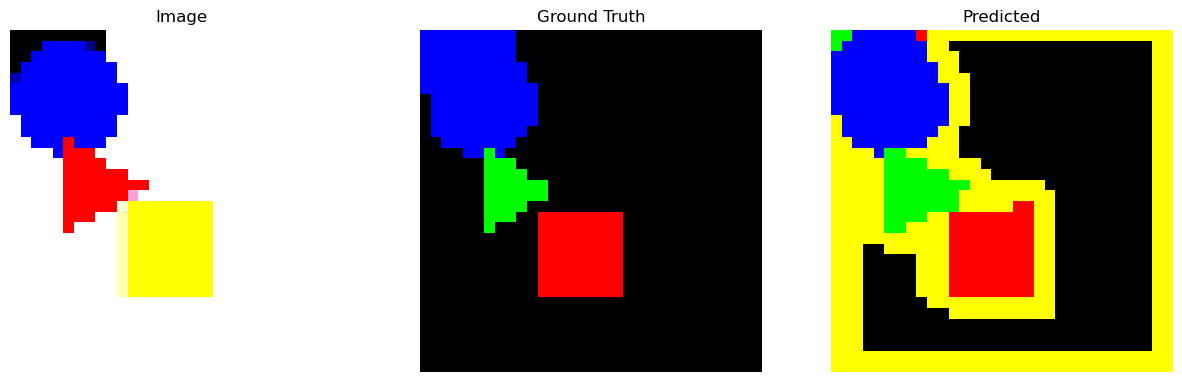

Epoch [2/70], Train Loss: 0.4761, Val Loss: 0.4672


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


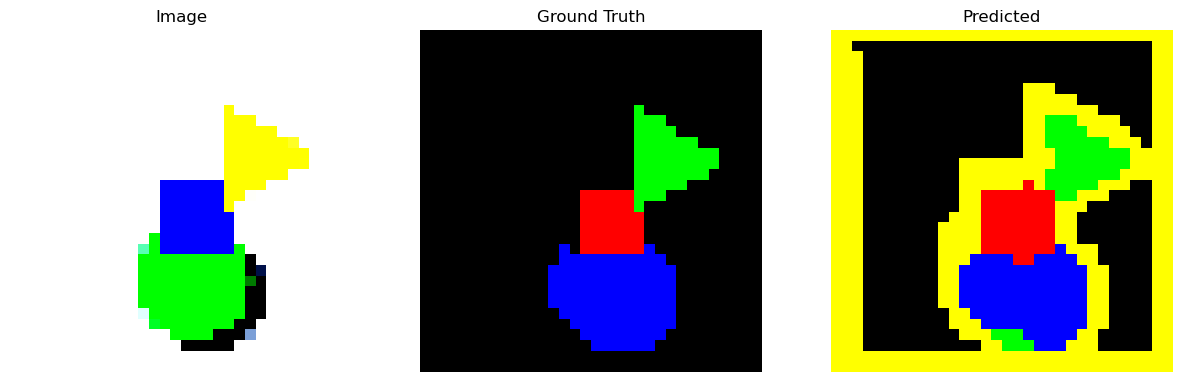

Epoch [3/70], Train Loss: 0.4354, Val Loss: 0.4320


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


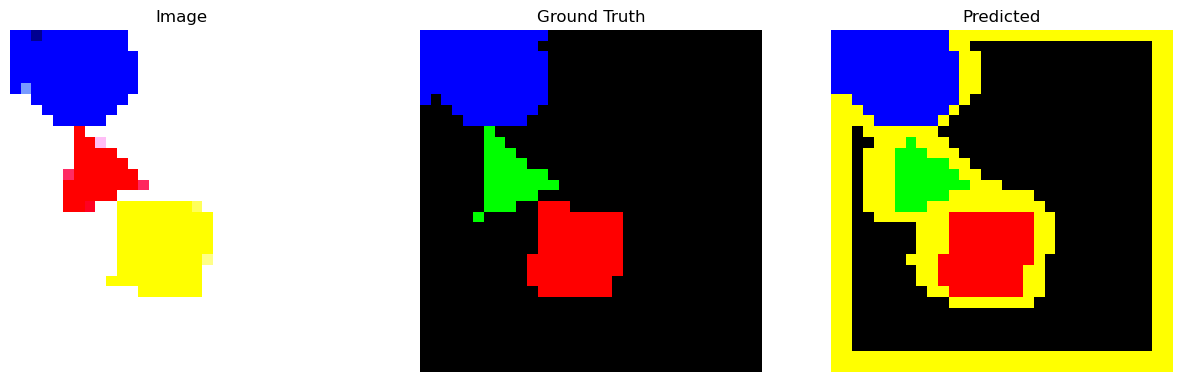

Epoch [4/70], Train Loss: 0.4147, Val Loss: 0.4054


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


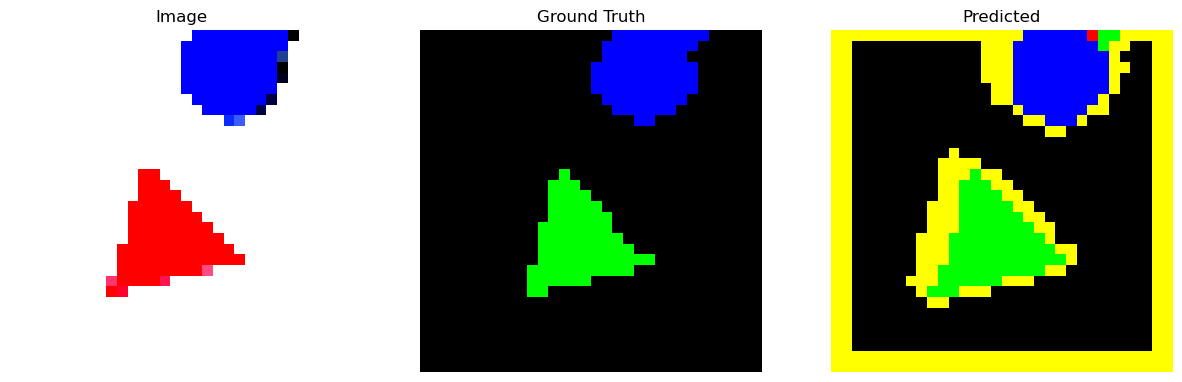

Epoch [5/70], Train Loss: 0.4044, Val Loss: 0.3967


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [6/70], Train Loss: 0.3943, Val Loss: 0.3959


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


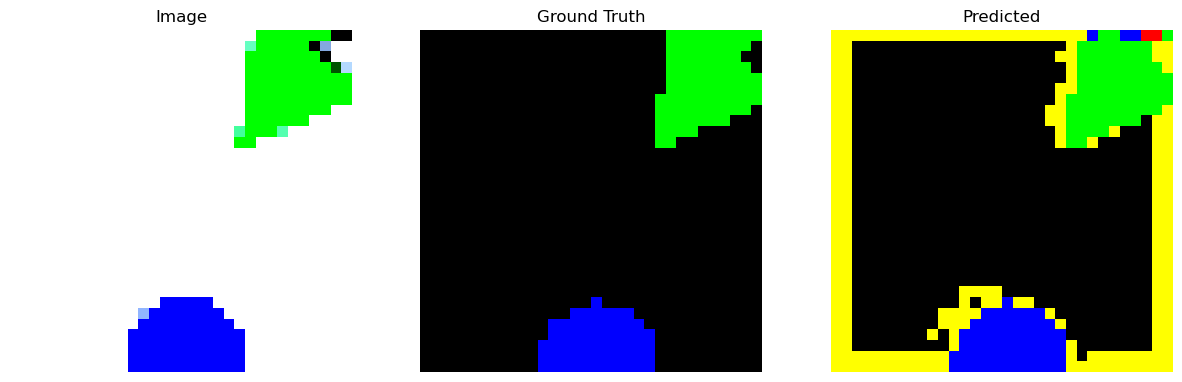

Epoch [7/70], Train Loss: 0.3866, Val Loss: 0.3842


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [8/70], Train Loss: 0.3800, Val Loss: 0.3793


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [9/70], Train Loss: 0.3750, Val Loss: 0.3784


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


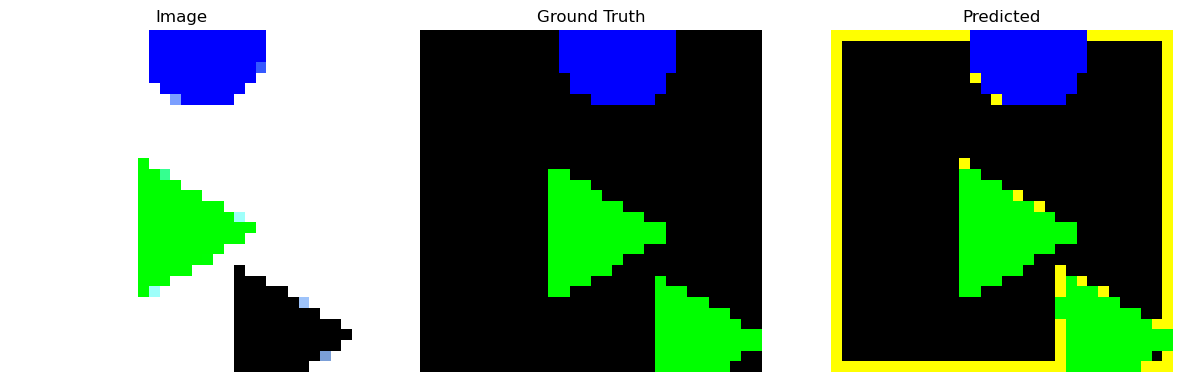

Epoch [10/70], Train Loss: 0.3645, Val Loss: 0.3637


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


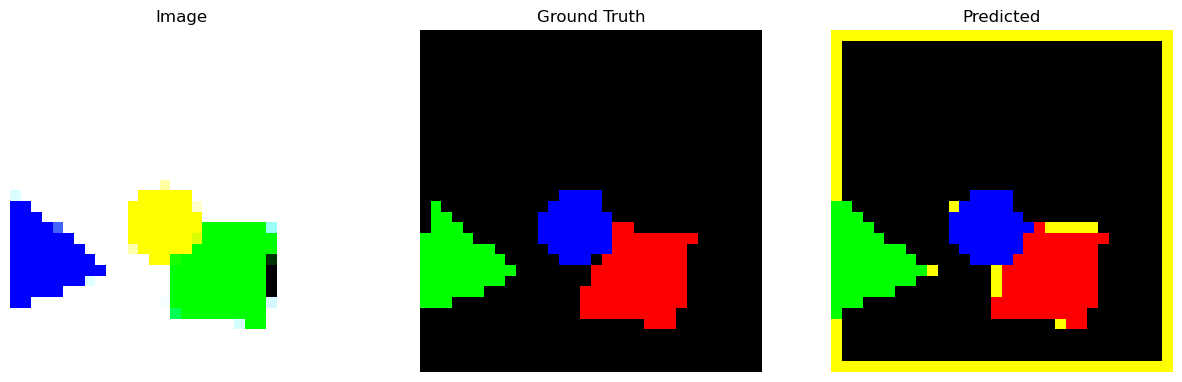

Epoch [11/70], Train Loss: 0.3615, Val Loss: 0.3641


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


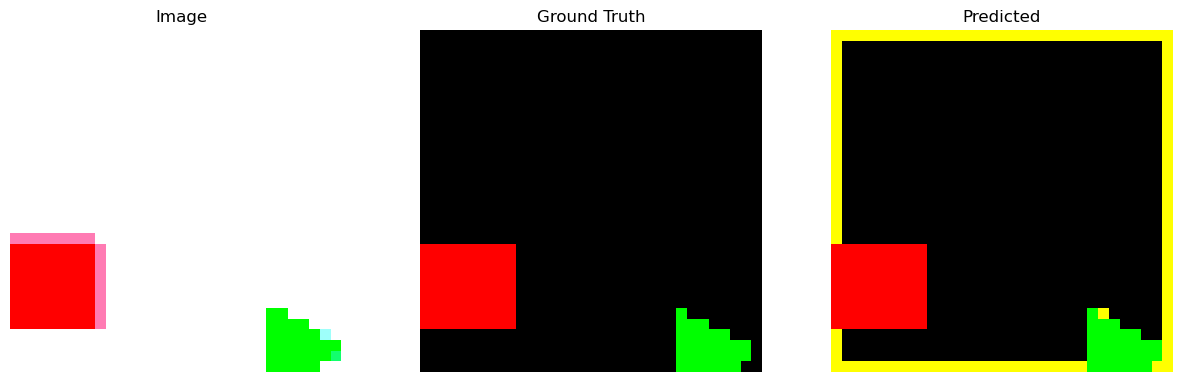

Epoch [12/70], Train Loss: 0.3598, Val Loss: 0.3588


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


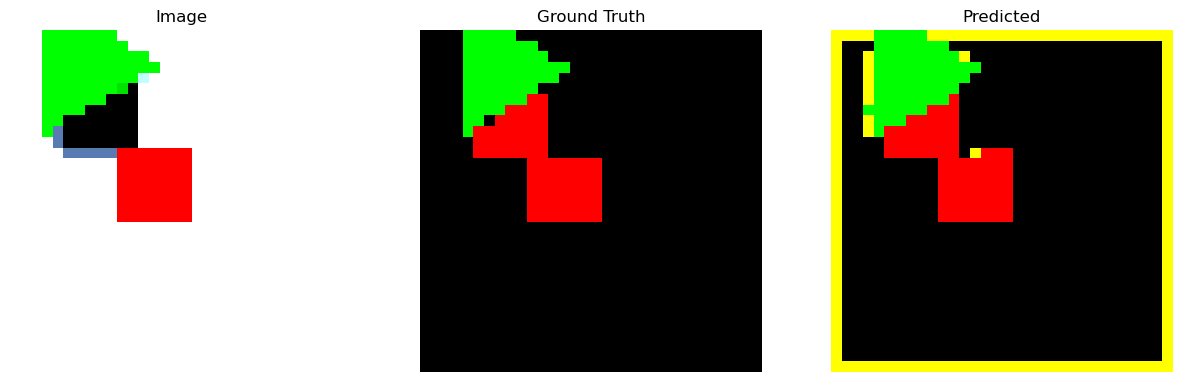

Epoch [13/70], Train Loss: 0.3568, Val Loss: 0.3578


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


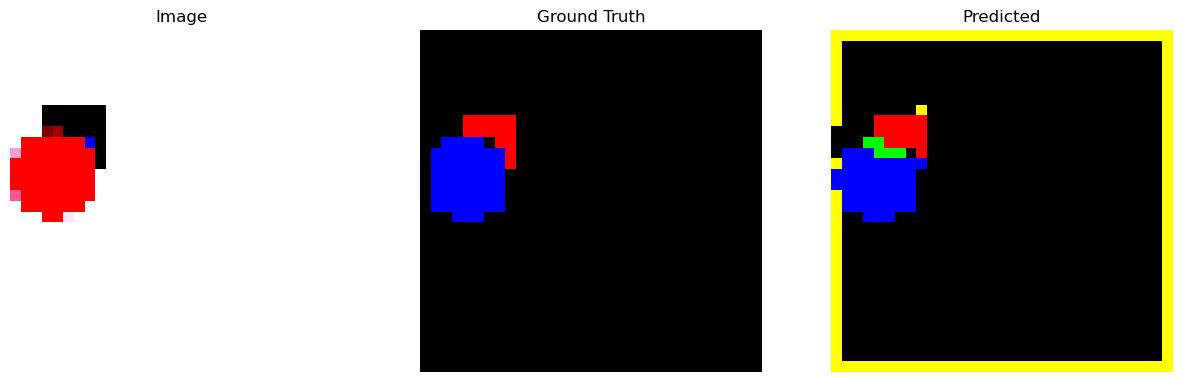

Epoch [14/70], Train Loss: 0.3559, Val Loss: 0.3549


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


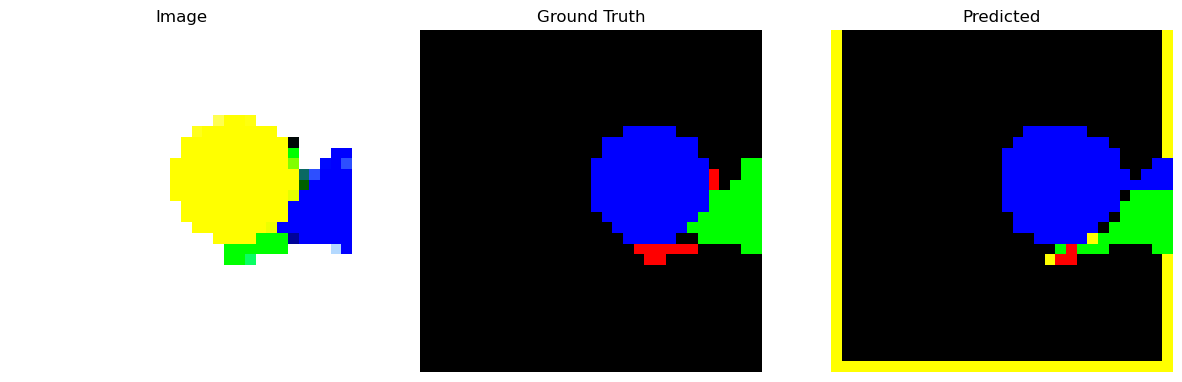

Epoch [15/70], Train Loss: 0.3527, Val Loss: 0.3549


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


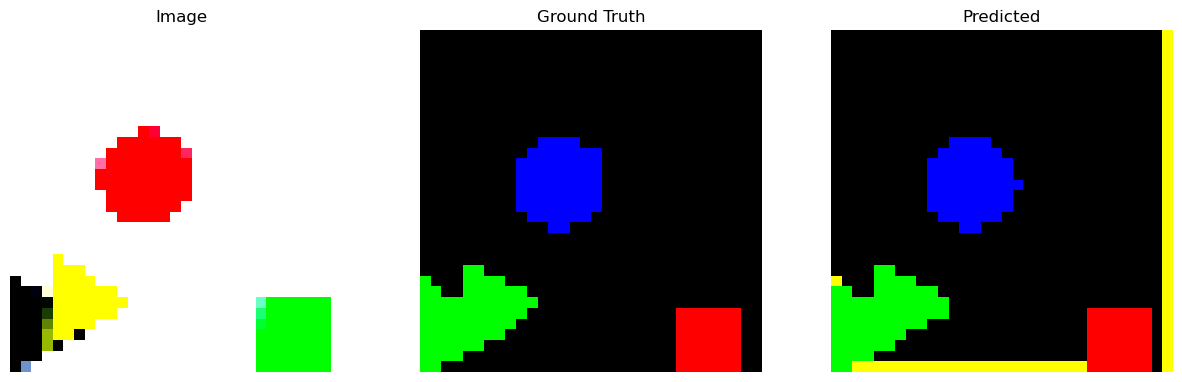

Epoch [16/70], Train Loss: 0.3503, Val Loss: 0.3509


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


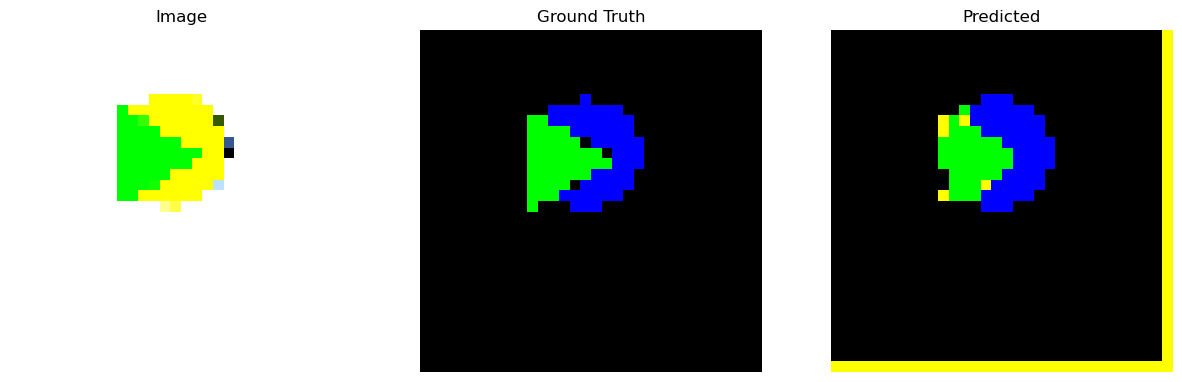

Epoch [17/70], Train Loss: 0.3480, Val Loss: 0.3462


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


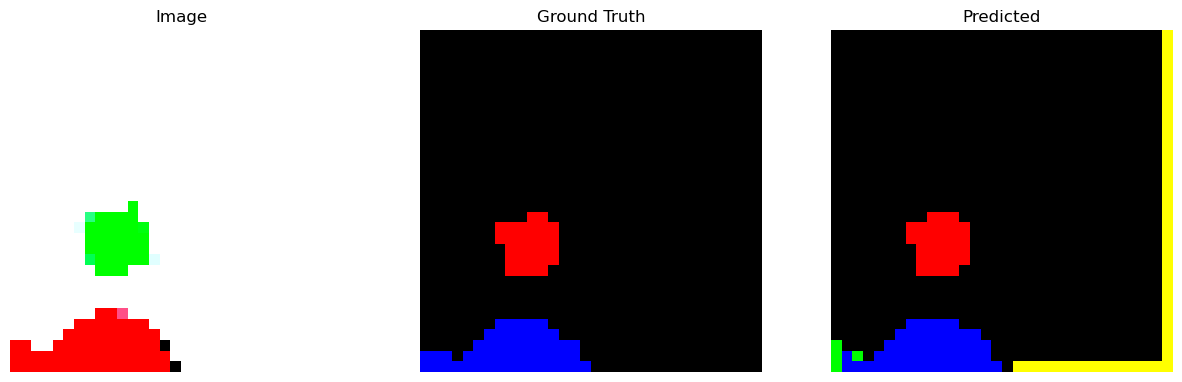

Epoch [18/70], Train Loss: 0.3463, Val Loss: 0.3468


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


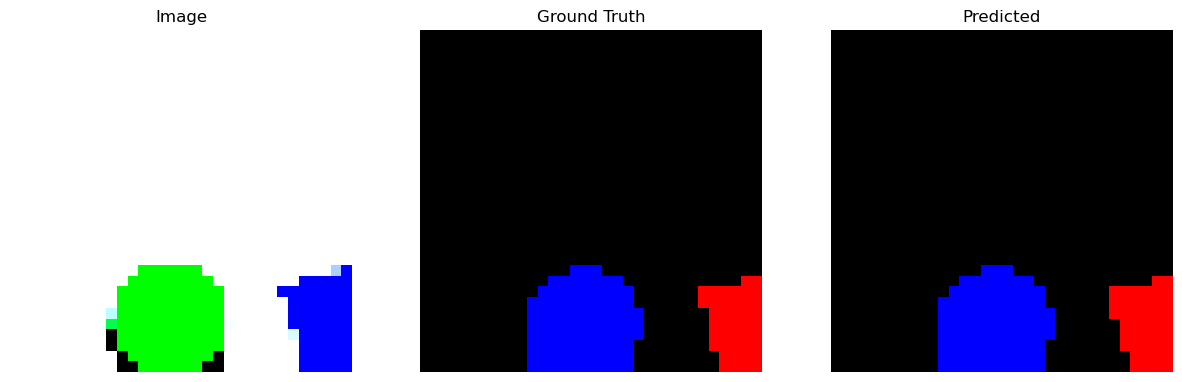

Epoch [19/70], Train Loss: 0.3443, Val Loss: 0.3419


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


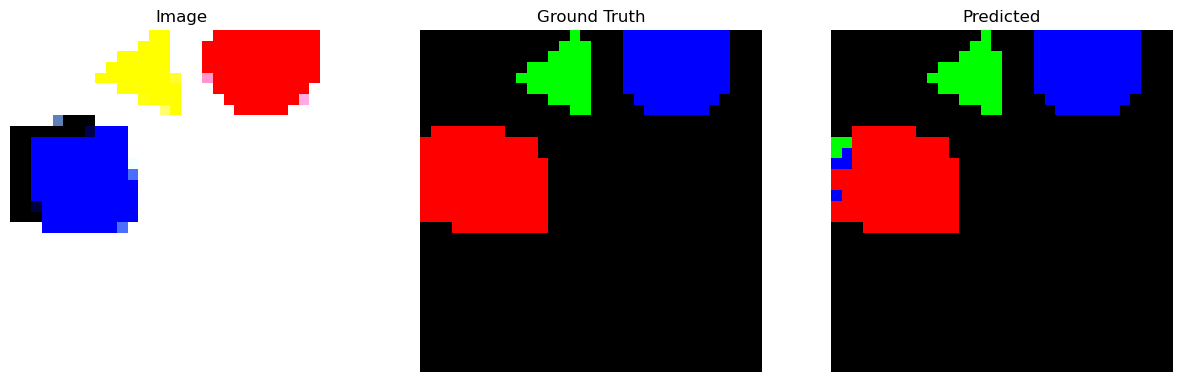

Epoch [20/70], Train Loss: 0.3385, Val Loss: 0.3456


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


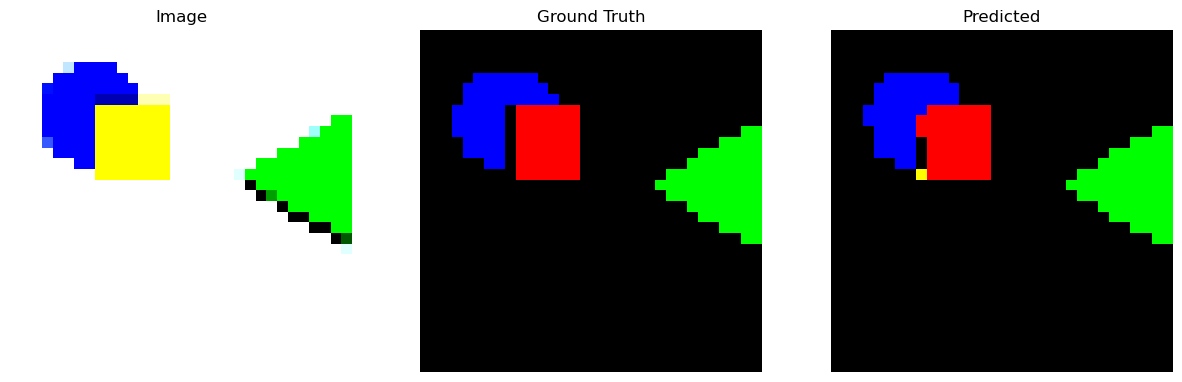

Epoch [21/70], Train Loss: 0.3371, Val Loss: 0.3400


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


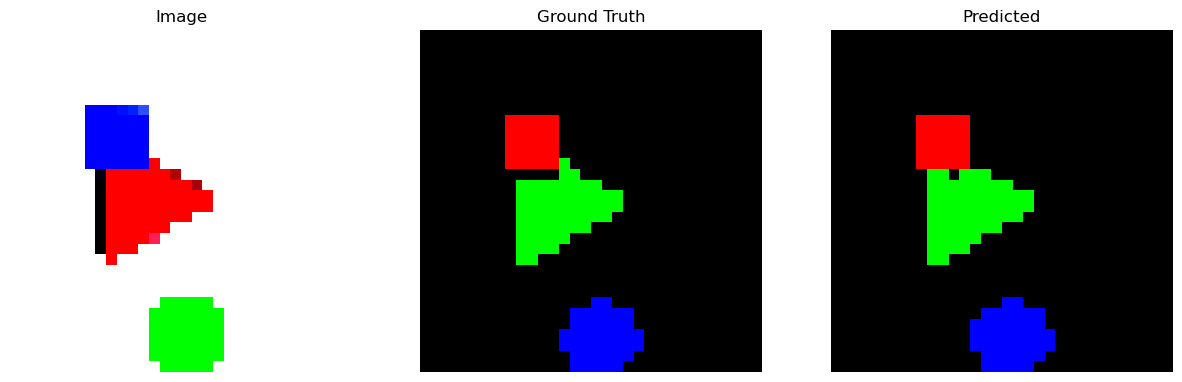

Epoch [22/70], Train Loss: 0.3371, Val Loss: 0.3376


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


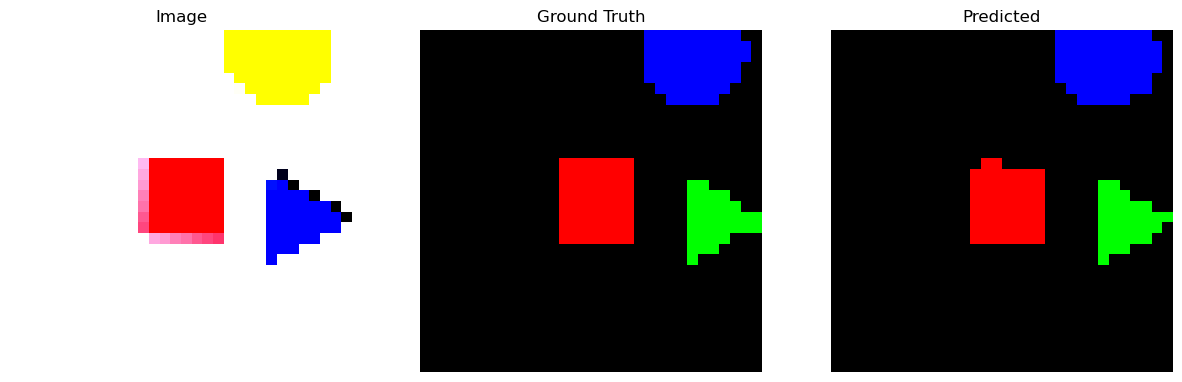

Epoch [23/70], Train Loss: 0.3380, Val Loss: 0.3369


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


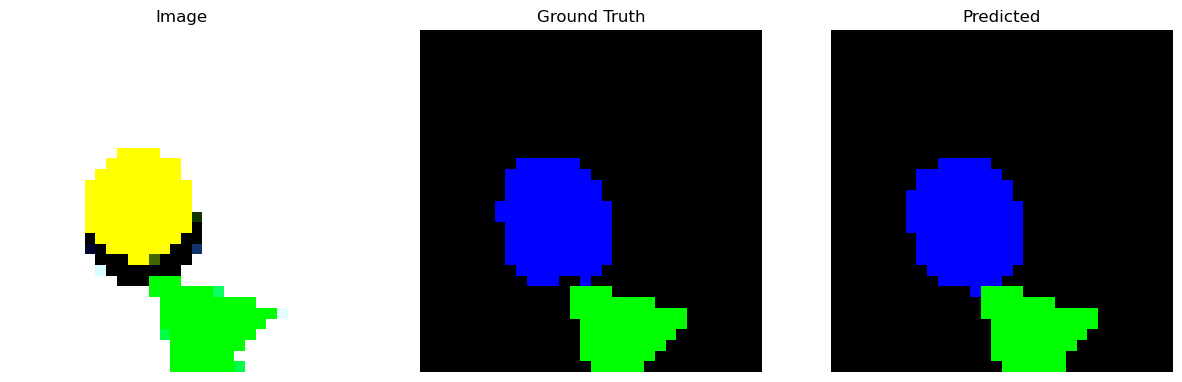

Epoch [24/70], Train Loss: 0.3360, Val Loss: 0.3370


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


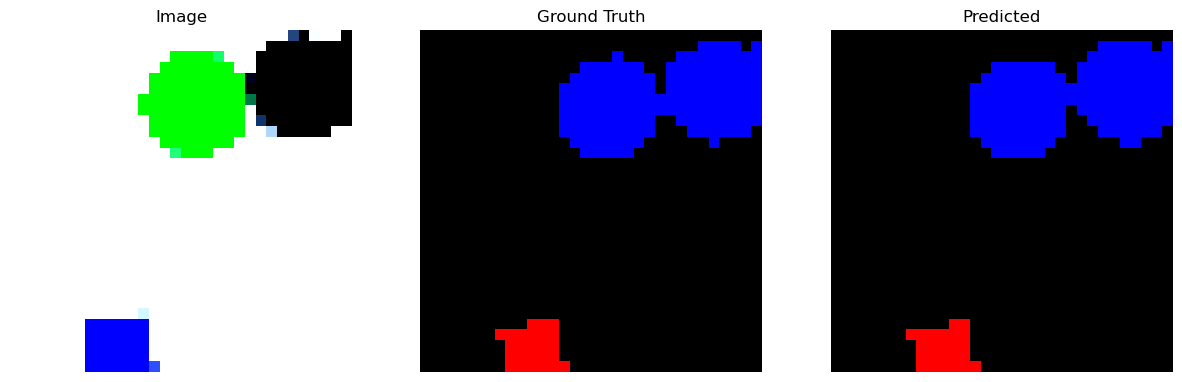

Epoch [25/70], Train Loss: 0.3353, Val Loss: 0.3392


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


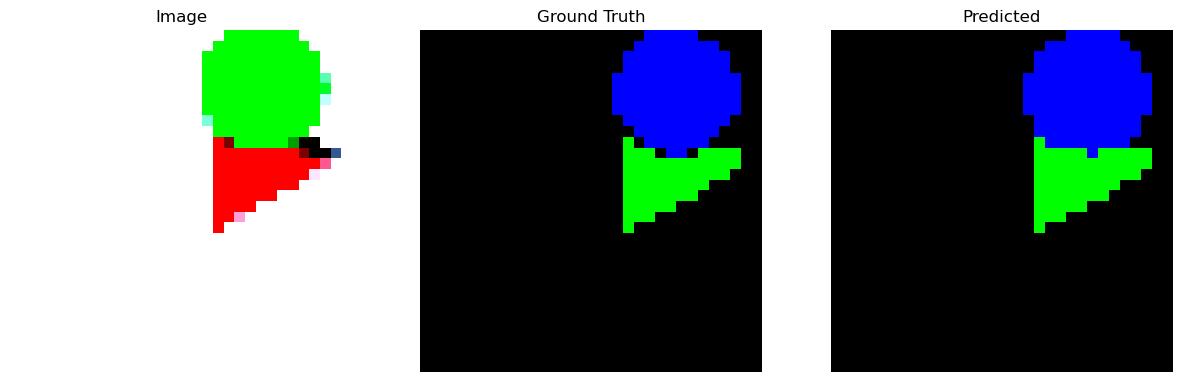

Epoch [26/70], Train Loss: 0.3357, Val Loss: 0.3391


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


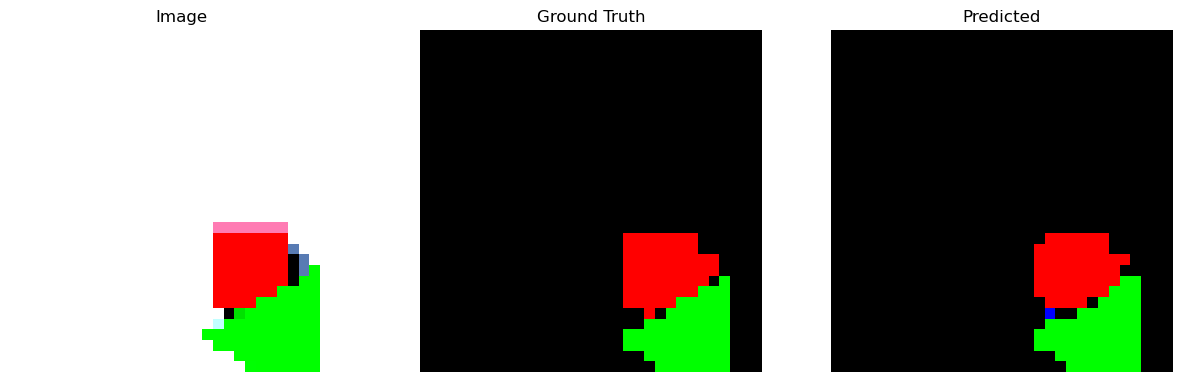

Epoch [27/70], Train Loss: 0.3391, Val Loss: 0.3395


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


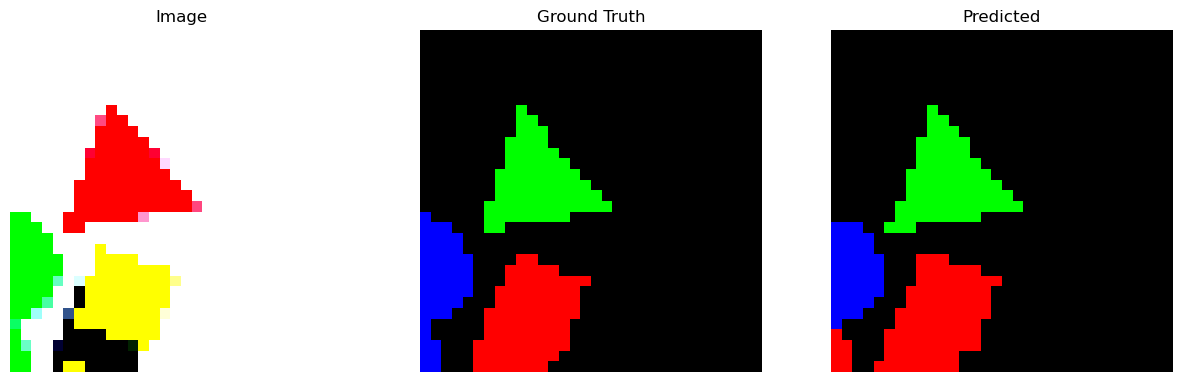

Epoch [28/70], Train Loss: 0.3348, Val Loss: 0.3385


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


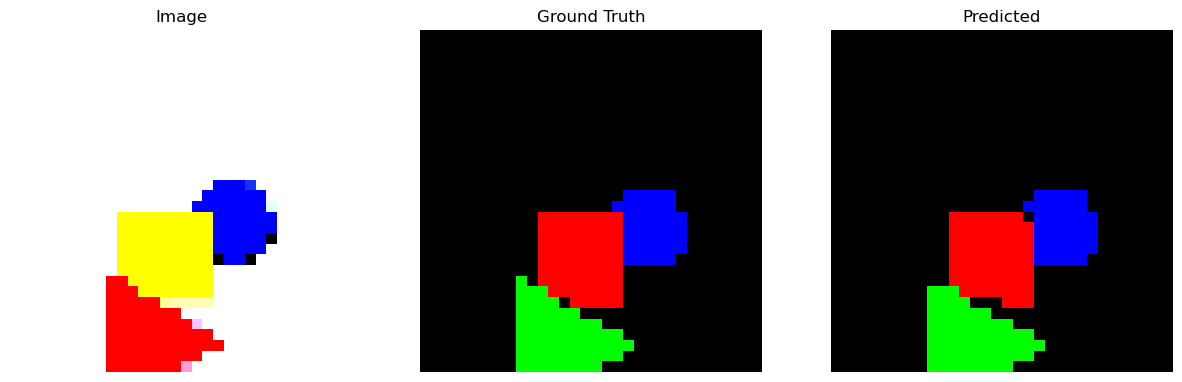

Epoch [29/70], Train Loss: 0.3356, Val Loss: 0.3390


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


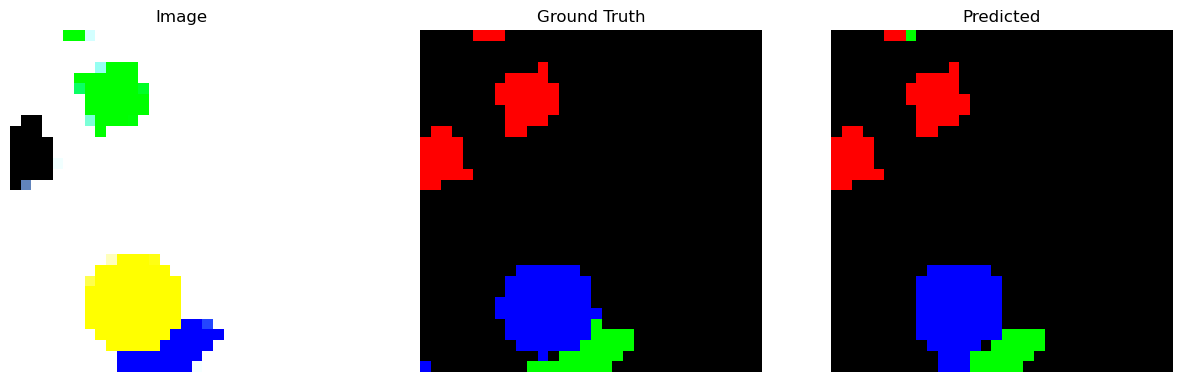

Epoch [30/70], Train Loss: 0.3353, Val Loss: 0.3379


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [31/70], Train Loss: 0.3327, Val Loss: 0.3340


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


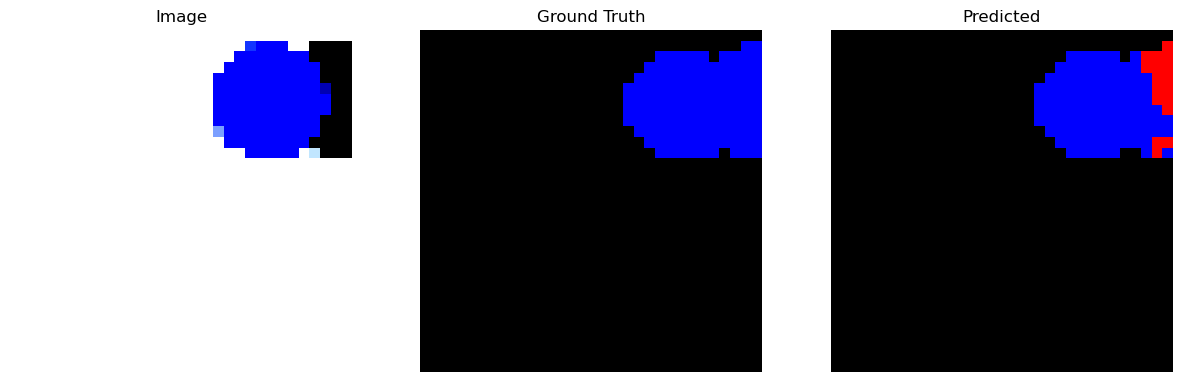

Epoch [32/70], Train Loss: 0.3318, Val Loss: 0.3356


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [33/70], Train Loss: 0.3317, Val Loss: 0.3329


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [34/70], Train Loss: 0.3314, Val Loss: 0.3353


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [35/70], Train Loss: 0.3314, Val Loss: 0.3329


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


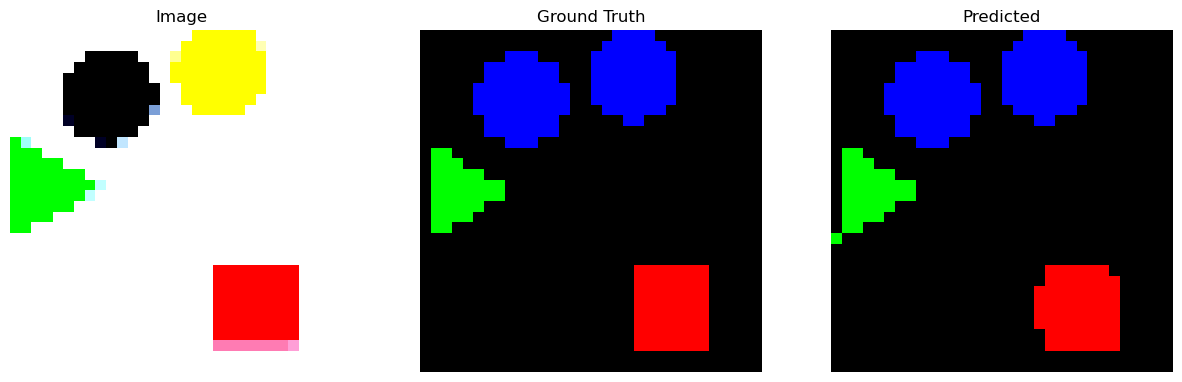

Epoch [36/70], Train Loss: 0.3312, Val Loss: 0.3350


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


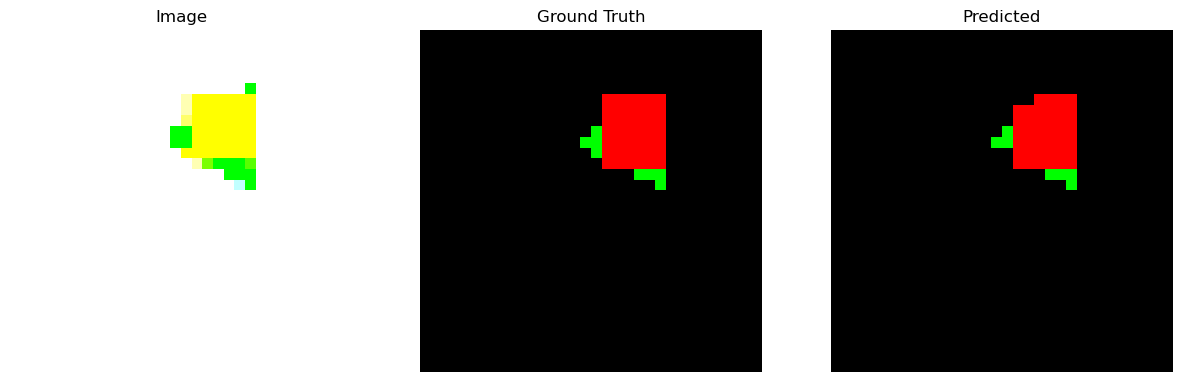

Epoch [37/70], Train Loss: 0.3314, Val Loss: 0.3352


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


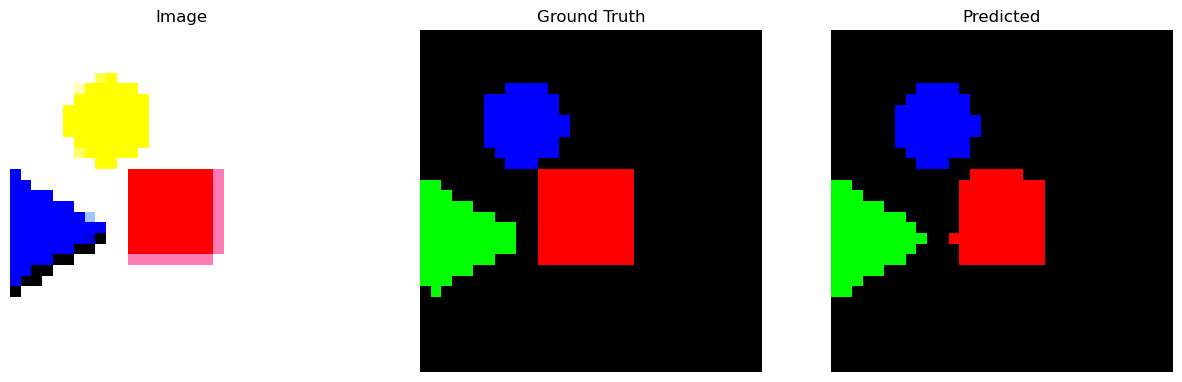

Epoch [38/70], Train Loss: 0.3310, Val Loss: 0.3346


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


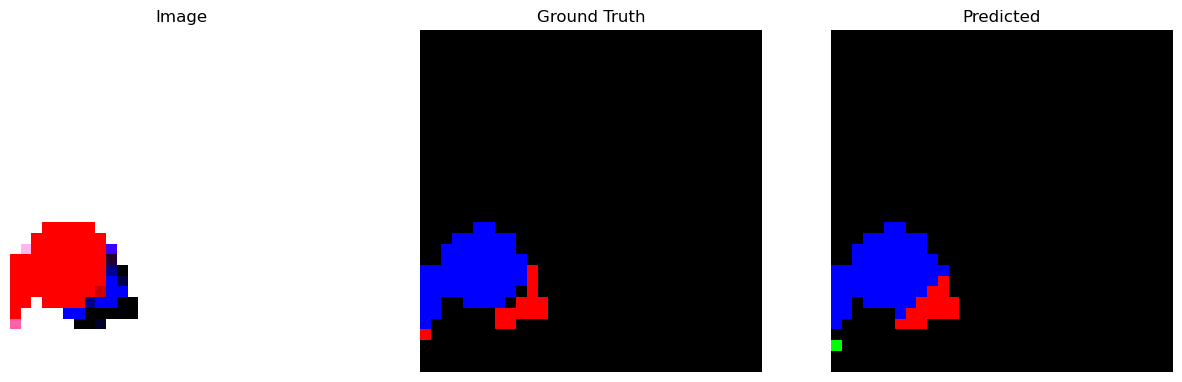

Epoch [39/70], Train Loss: 0.3308, Val Loss: 0.3318


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [40/70], Train Loss: 0.3312, Val Loss: 0.3324


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


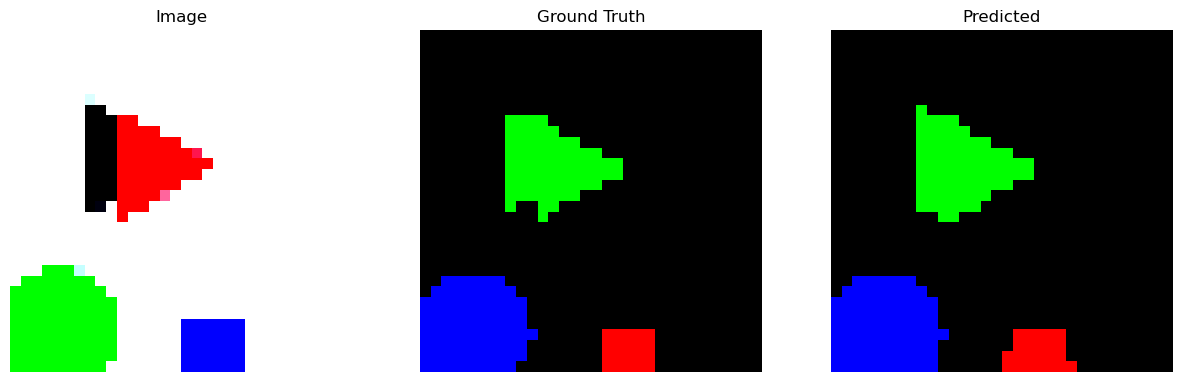

Epoch [41/70], Train Loss: 0.3306, Val Loss: 0.3350


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


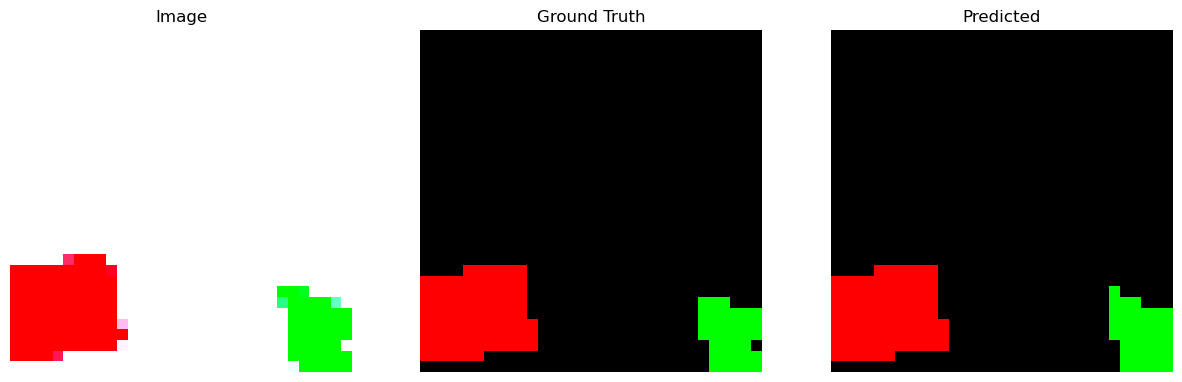

Epoch [42/70], Train Loss: 0.3310, Val Loss: 0.3318


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


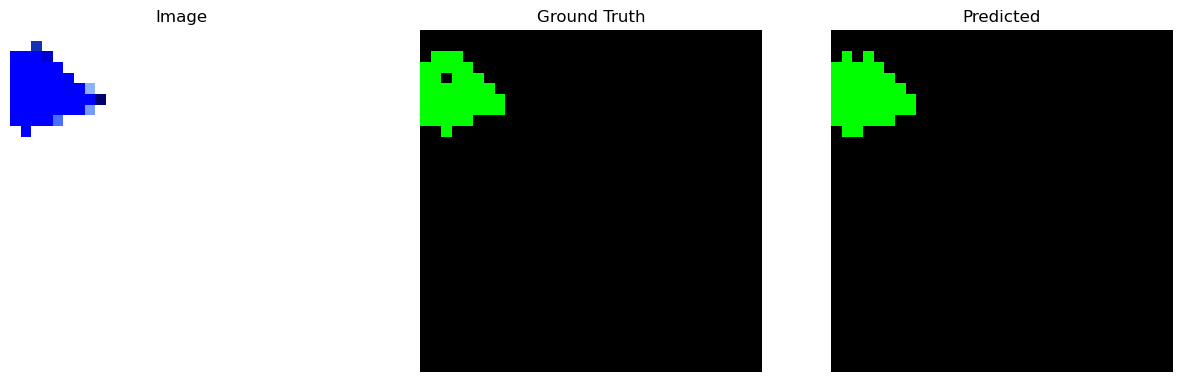

Epoch [43/70], Train Loss: 0.3303, Val Loss: 0.3347


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [44/70], Train Loss: 0.3305, Val Loss: 0.3342


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


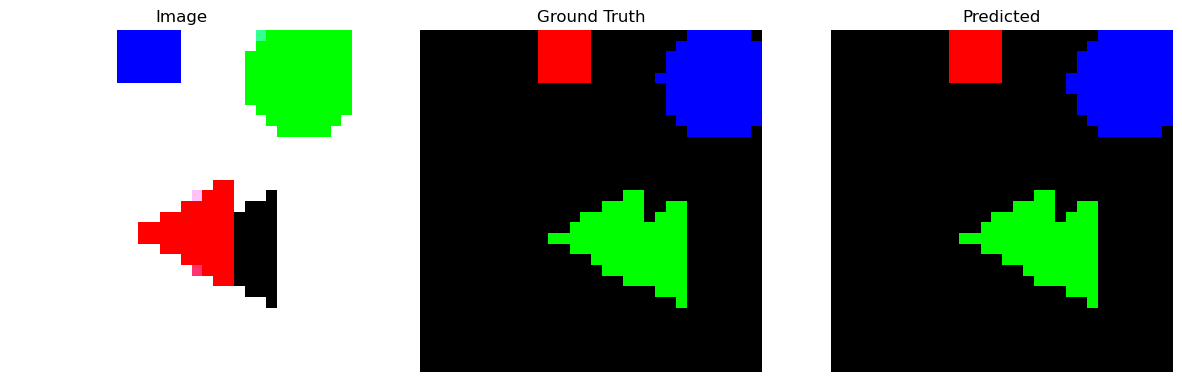

Epoch [45/70], Train Loss: 0.3306, Val Loss: 0.3345


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


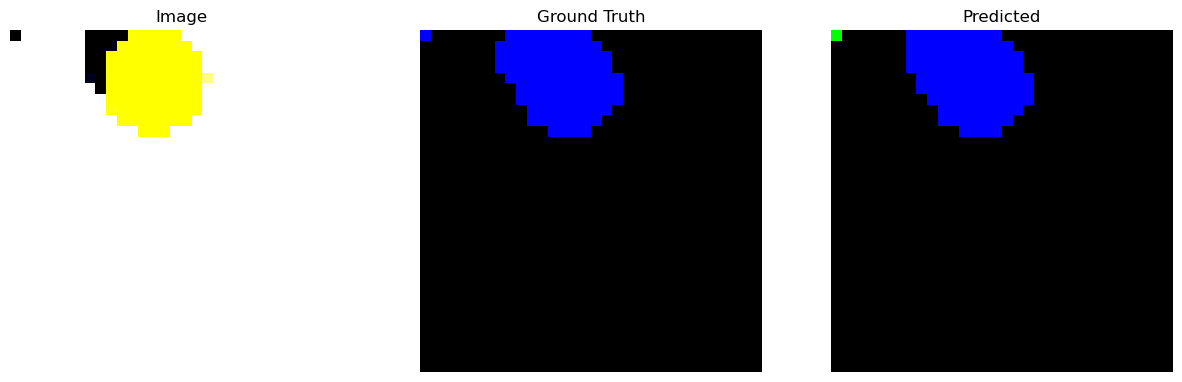

Epoch [46/70], Train Loss: 0.3300, Val Loss: 0.3311


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


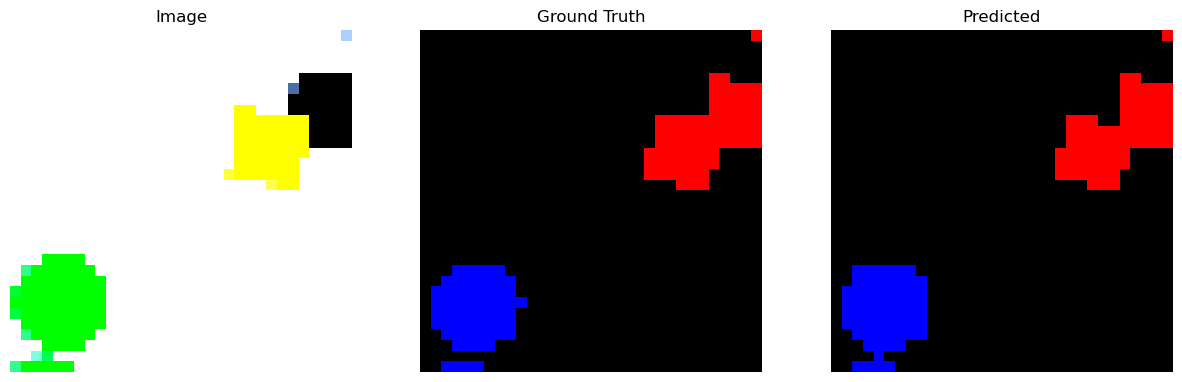

Epoch [47/70], Train Loss: 0.3306, Val Loss: 0.3351


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


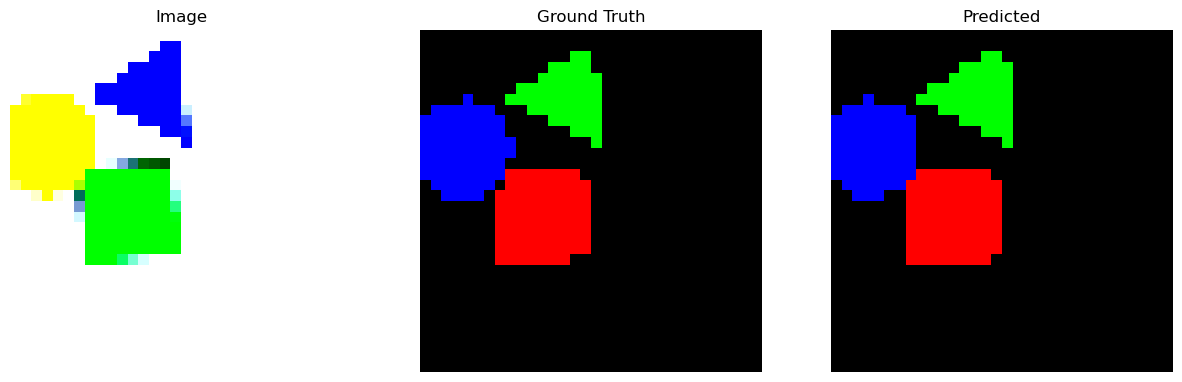

Epoch [48/70], Train Loss: 0.3310, Val Loss: 0.3320


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


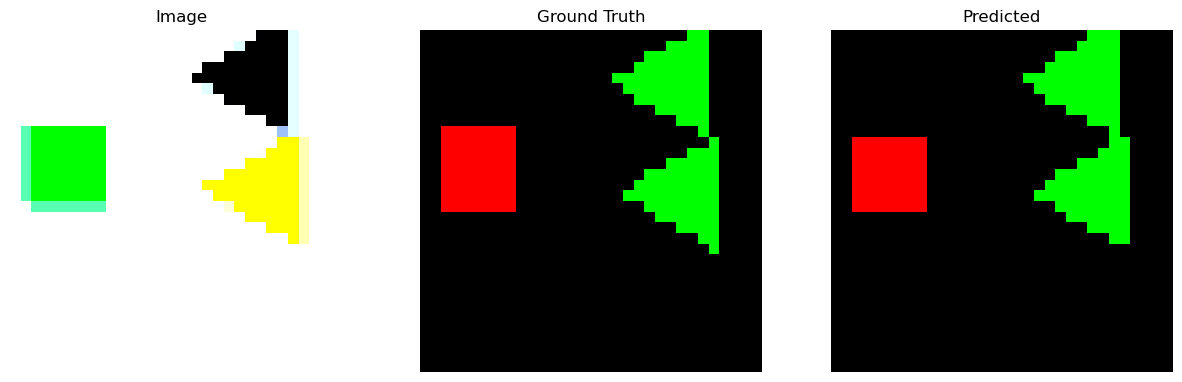

Epoch [49/70], Train Loss: 0.3300, Val Loss: 0.3371


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


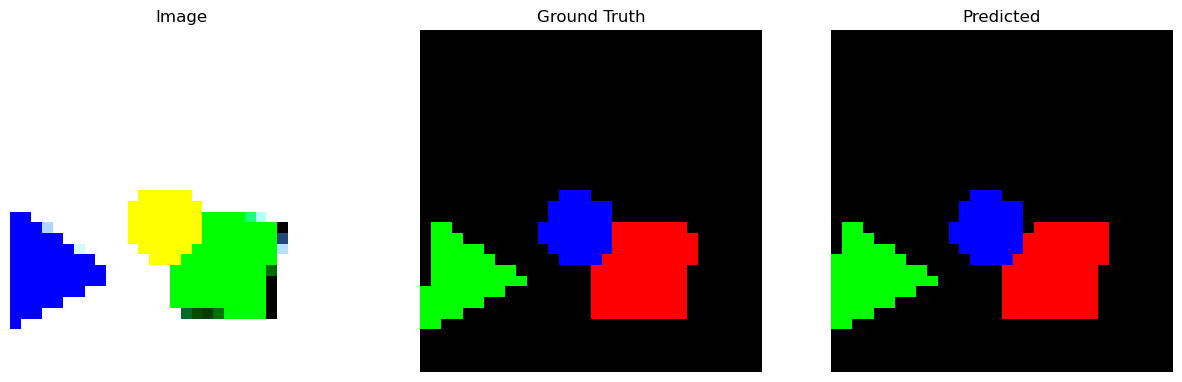

Epoch [50/70], Train Loss: 0.3298, Val Loss: 0.3346


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


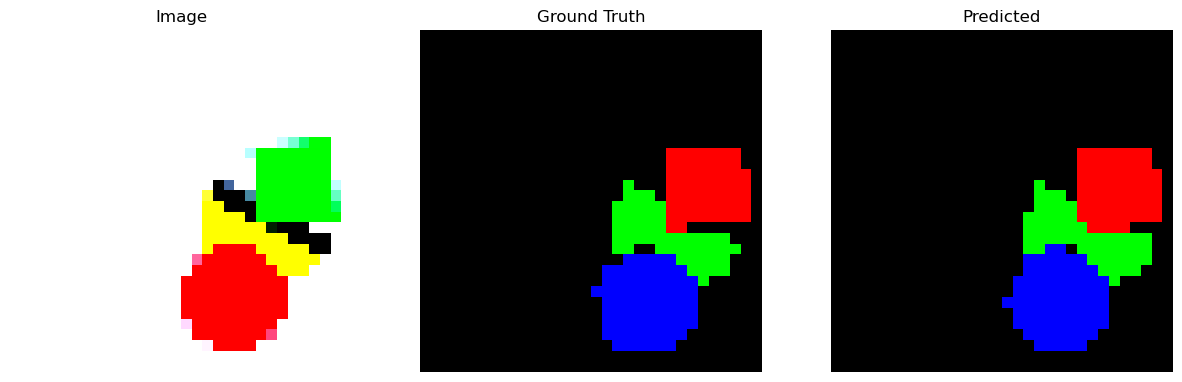

Epoch [51/70], Train Loss: 0.3297, Val Loss: 0.3351


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


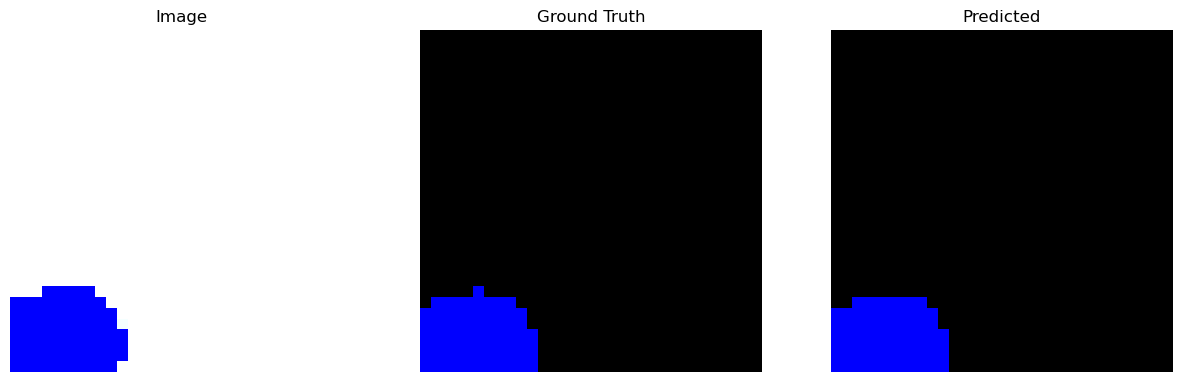

Epoch [52/70], Train Loss: 0.3302, Val Loss: 0.3319


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


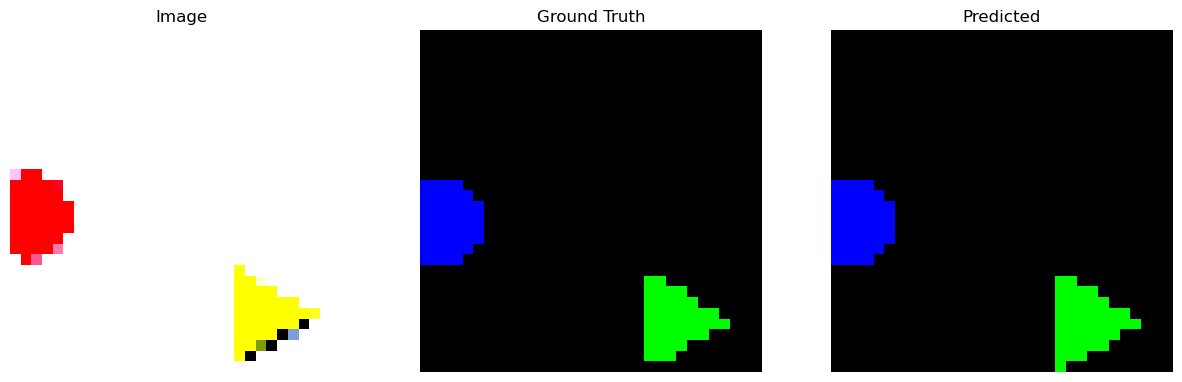

Epoch [53/70], Train Loss: 0.3306, Val Loss: 0.3323


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [54/70], Train Loss: 0.3297, Val Loss: 0.3320


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


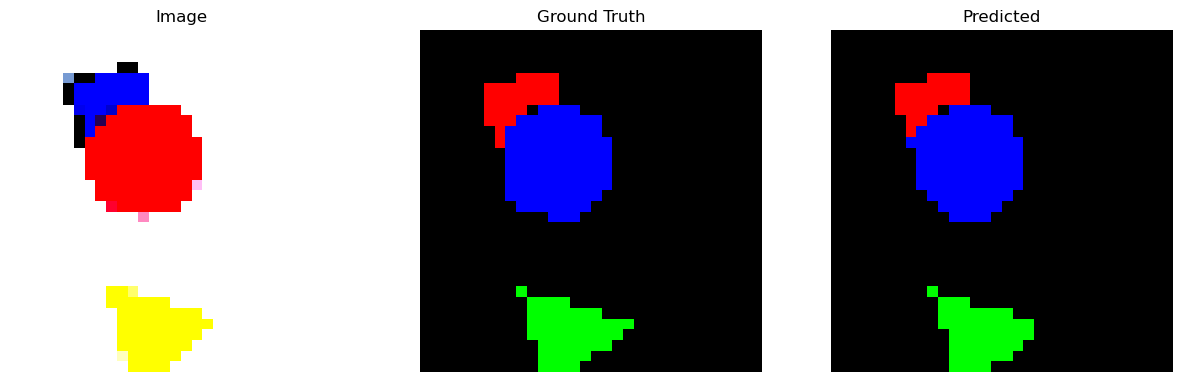

Epoch [55/70], Train Loss: 0.3301, Val Loss: 0.3315


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [56/70], Train Loss: 0.3295, Val Loss: 0.3341


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [57/70], Train Loss: 0.3293, Val Loss: 0.3339


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


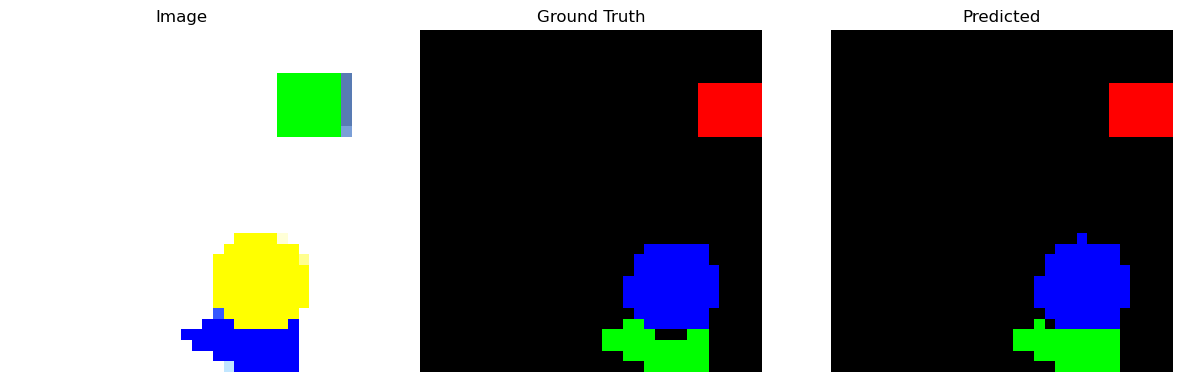

Epoch [58/70], Train Loss: 0.3292, Val Loss: 0.3340


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


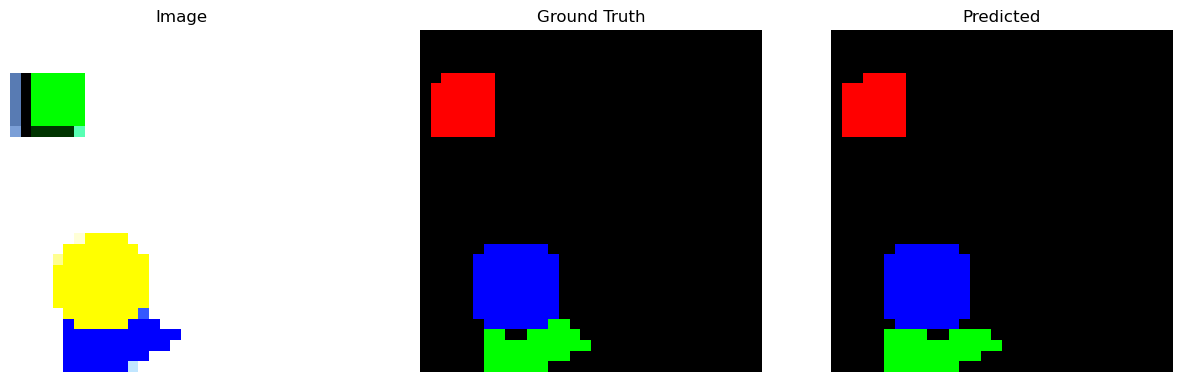

Epoch [59/70], Train Loss: 0.3306, Val Loss: 0.3331


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [60/70], Train Loss: 0.3298, Val Loss: 0.3335


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


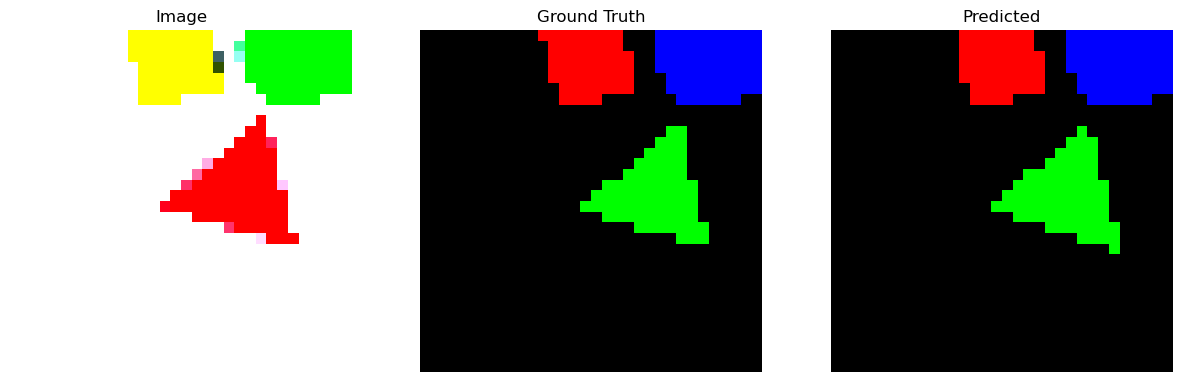

Epoch [61/70], Train Loss: 0.3295, Val Loss: 0.3348


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


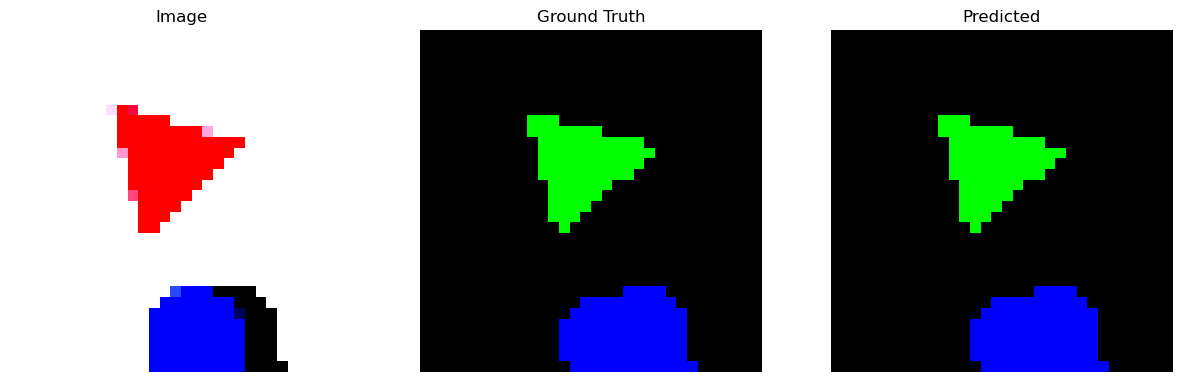

Epoch [62/70], Train Loss: 0.3296, Val Loss: 0.3344


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


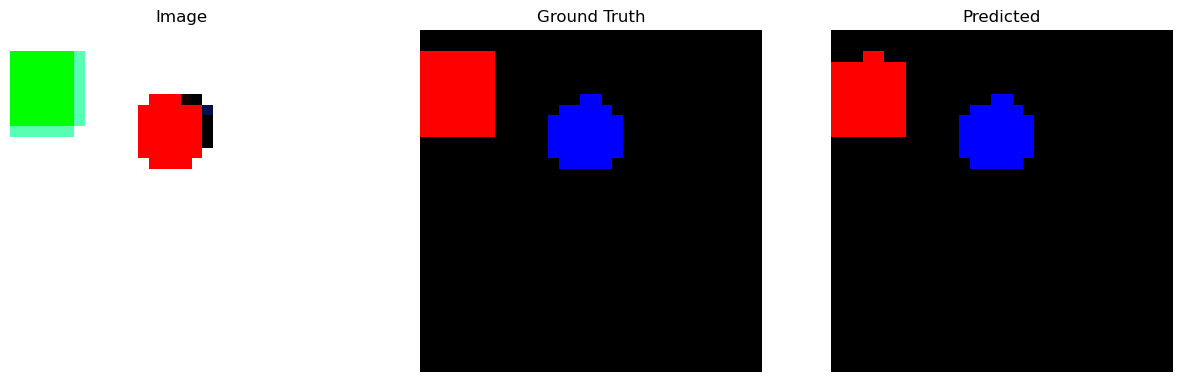

Epoch [63/70], Train Loss: 0.3290, Val Loss: 0.3342


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [64/70], Train Loss: 0.3293, Val Loss: 0.3336


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [65/70], Train Loss: 0.3300, Val Loss: 0.3350


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


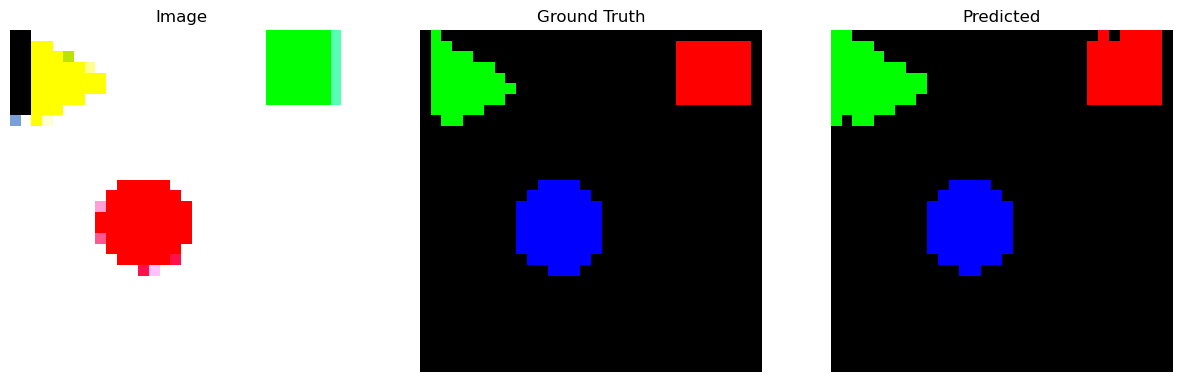

Epoch [66/70], Train Loss: 0.3295, Val Loss: 0.3362


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [67/70], Train Loss: 0.3290, Val Loss: 0.3304


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [68/70], Train Loss: 0.3293, Val Loss: 0.3365


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [69/70], Train Loss: 0.3296, Val Loss: 0.3346


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


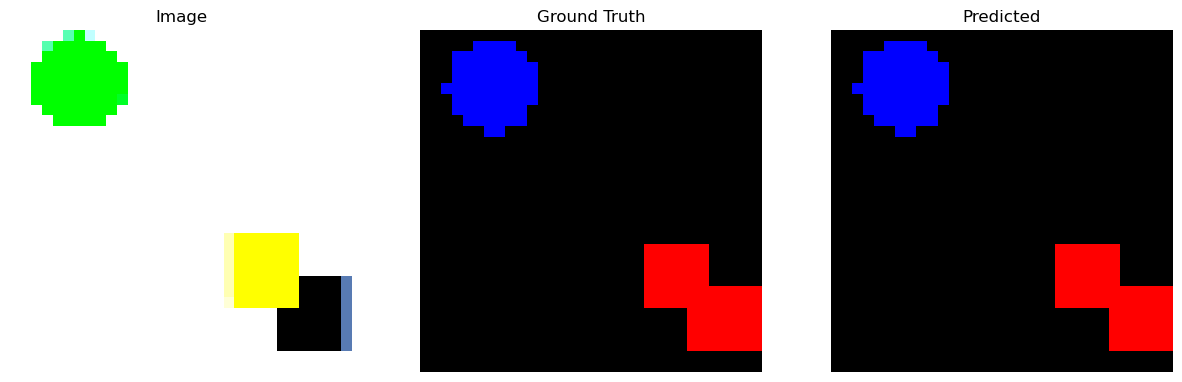

Epoch [70/70], Train Loss: 0.3300, Val Loss: 0.3345


([0.6184188087957095,
  0.4761231719216766,
  0.4353698593149495,
  0.41474331682410565,
  0.4044156566833676,
  0.3942648037872483,
  0.3866193303316392,
  0.379951201533146,
  0.3750255637991745,
  0.36452994471454336,
  0.36146934370024014,
  0.3598244792416384,
  0.3568221451082764,
  0.3558822357724902,
  0.3526619667500521,
  0.35032043537910706,
  0.3480265877239824,
  0.3462534621577699,
  0.34429908739430365,
  0.3385328380143748,
  0.33713217747774094,
  0.3371292733337324,
  0.3380269481193351,
  0.336035944499449,
  0.3353248625817904,
  0.3357475842170659,
  0.339071529013569,
  0.33479367244911756,
  0.3356278831452395,
  0.33528400742198866,
  0.33271677660203614,
  0.33184763397966516,
  0.33167812826007514,
  0.33144781903355525,
  0.3313935470704132,
  0.3311854794753336,
  0.33141924322178934,
  0.3310297067801861,
  0.3308496262911147,
  0.33117989382560975,
  0.33055283151193354,
  0.3309674036186353,
  0.33027297100134656,
  0.3304854196257296,
  0.330554900443659

In [8]:
def dice_loss(pred, target, num_classes, epsilon=1e-6):
    """
    Calculate Dice Loss for multi-class segmentation.
    """
    target = target.long()

    if not (target.ge(0) & target.lt(num_classes)).all():
        raise ValueError(f"Target contains values outside the range [0, {num_classes-1}]")

    pred = F.softmax(pred, dim=1)

    target_one_hot = F.one_hot(target, num_classes).permute(0, 3, 1, 2).float()

    intersection = (pred * target_one_hot).sum(dim=(2, 3))
    union = pred.sum(dim=(2, 3)) + target_one_hot.sum(dim=(2, 3))

    dice_score = (2. * intersection + epsilon) / (union + epsilon)
    dice_loss = 1 - dice_score.mean(dim=0)

    return dice_loss.mean()


def show_image_gt_and_pred(image, gt_mask, pred_mask):
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title('Image')
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(gt_mask)
    plt.title('Ground Truth')
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask)
    plt.title('Predicted')
    plt.axis('off')
    
    plt.show()
    
def train_model(model, train_loader, validation_loader, epochs, learning_rate, num_classes):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    criterion = lambda preds, labels: dice_loss(preds, labels, num_classes) 
    scheduler = StepLR(optimizer, step_size=30, gamma=0.1)
    
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            preds = model(images)
            loss = criterion(preds, labels)  
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        scheduler.step()

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        val_running_loss = 0.0
        with torch.no_grad():
            for batch_idx, (images, labels) in enumerate(validation_loader):
                images, labels = images.to(device), labels.to(device)
                preds = model(images)
                loss = criterion(preds, labels)  
                val_running_loss += loss.item()

                if batch_idx == 0: 
                    image = images[0].cpu().permute(1, 2, 0).numpy()
                    gt_mask = class_to_rgb(labels[0].cpu().numpy())
                    pred_mask = class_to_rgb(torch.argmax(preds[0], dim=0).cpu().numpy())
                    show_image_gt_and_pred(image, gt_mask, pred_mask)
                    
        val_loss = val_running_loss / len(validation_loader)
        val_losses.append(val_loss)

        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    return train_losses, val_losses

epochs = 70
learning_rate = 0.001
model = EnhancedModel(num_classes=5)
train_model(model, train_loader, validation_loader, epochs, learning_rate, 5)

NOW RESIZE TO 128x128

In [9]:
transform = Compose([
    Rotate(limit=20, p=0.5),  
    Flip(p=0.5),  
    Resize(128, 128),  
    Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), 
    ToTensorV2()  
])

train_dataset = FlyingObjectsDataset(
    img_dir=os.path.join(training_img_dir, 'image'),
    gt_dir=os.path.join(training_img_dir, 'gt_image'),
    transform=transform
)

validation_dataset = FlyingObjectsDataset(
    img_dir=os.path.join(validation_img_dir, 'image'),
    gt_dir=os.path.join(validation_img_dir, 'gt_image'),
    transform=transform
)

test_dataset = FlyingObjectsDataset(
    img_dir=os.path.join(testing_img_dir, 'image'),
    gt_dir=os.path.join(testing_img_dir, 'gt_image'),
    transform=transform
)


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

for images, targets in train_loader:
    print(f"Image batch shape: {images.shape}")  
    print(f"Target batch shape: {targets.shape}")  
    break  

Image batch shape: torch.Size([32, 3, 128, 128])
Target batch shape: torch.Size([32, 128, 128])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 1/100, Train Loss: 0.7050, Val Loss: 0.6750, Avg IoU: 0.3463, Avg Dice: 0.4401


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


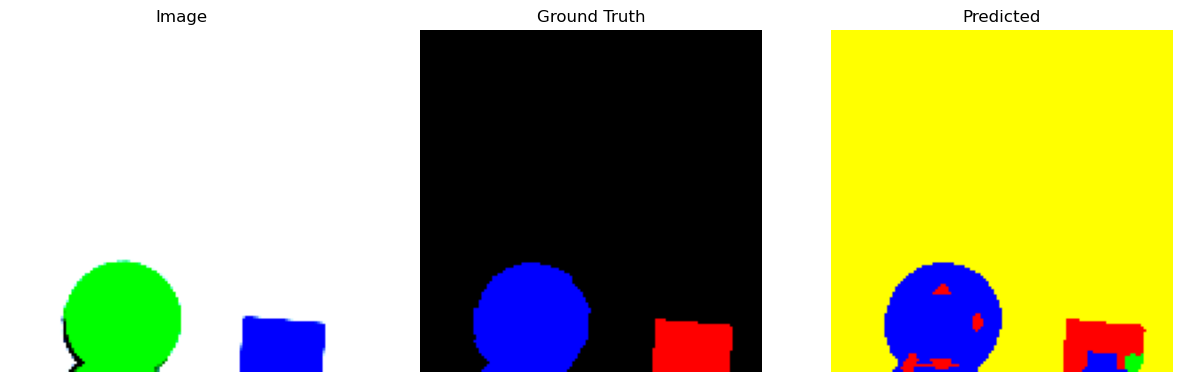

Epoch 2/100, Train Loss: 0.5258, Val Loss: 0.6192, Avg IoU: 0.4025, Avg Dice: 0.4798


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 3/100, Train Loss: 0.4691, Val Loss: 0.4644, Avg IoU: 0.5771, Avg Dice: 0.6709


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


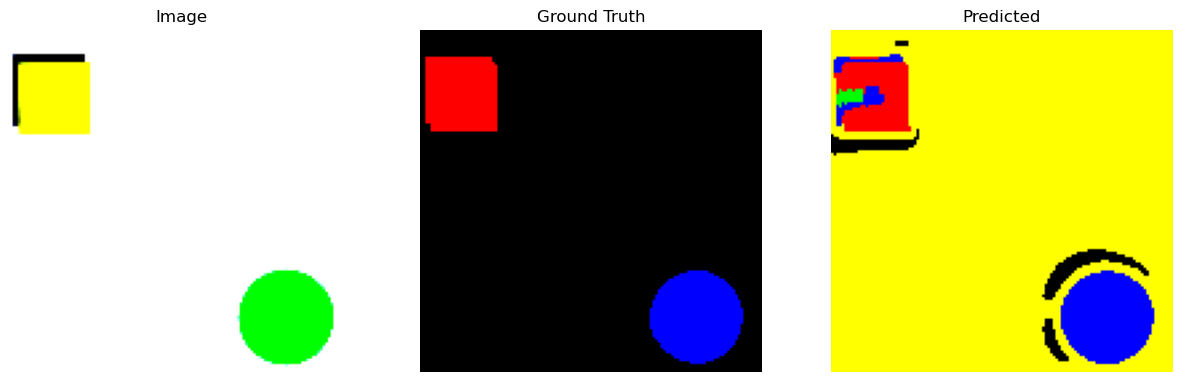

Epoch 4/100, Train Loss: 0.4364, Val Loss: 0.5819, Avg IoU: 0.4408, Avg Dice: 0.5220


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


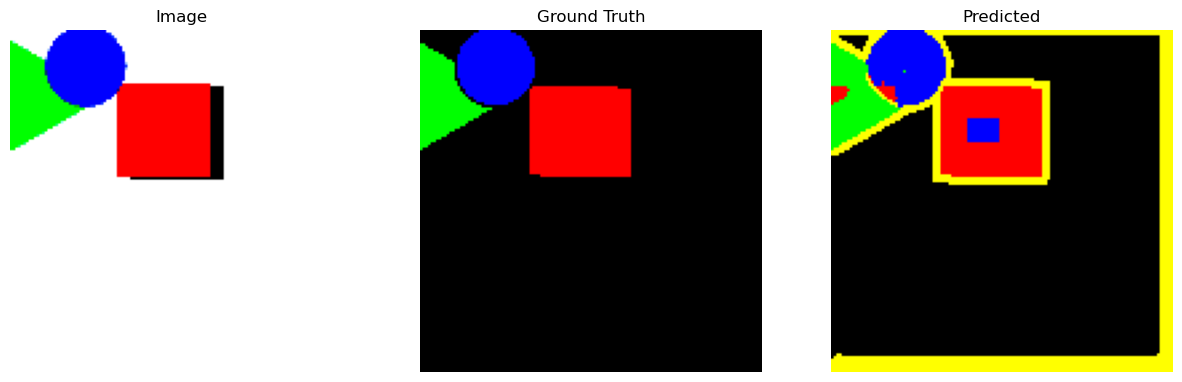

Epoch 5/100, Train Loss: 0.4134, Val Loss: 0.4055, Avg IoU: 0.6327, Avg Dice: 0.7060


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 6/100, Train Loss: 0.3994, Val Loss: 0.3973, Avg IoU: 0.6545, Avg Dice: 0.7180


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 7/100, Train Loss: 0.3860, Val Loss: 0.3777, Avg IoU: 0.6813, Avg Dice: 0.7355


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


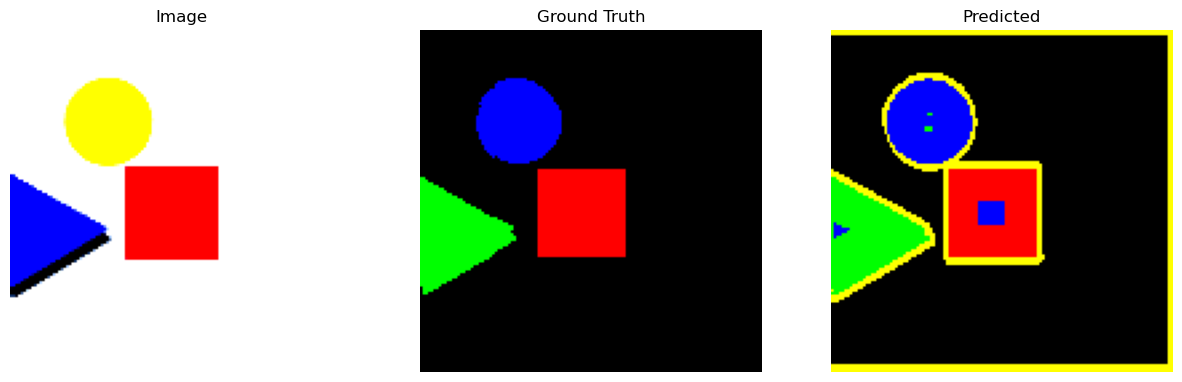

Epoch 8/100, Train Loss: 0.3746, Val Loss: 0.3838, Avg IoU: 0.6736, Avg Dice: 0.7306


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


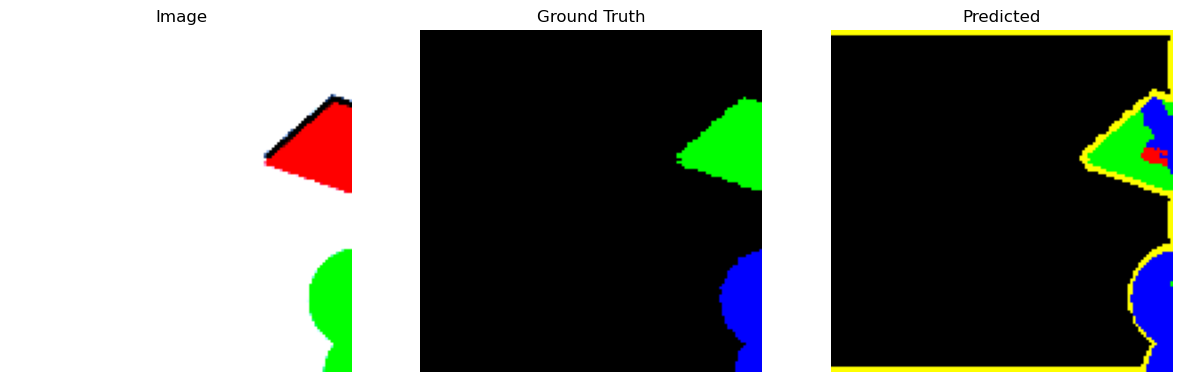

Epoch 9/100, Train Loss: 0.3706, Val Loss: 0.3733, Avg IoU: 0.6840, Avg Dice: 0.7369


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 10/100, Train Loss: 0.3640, Val Loss: 0.3627, Avg IoU: 0.7048, Avg Dice: 0.7491


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 11/100, Train Loss: 0.3576, Val Loss: 0.3679, Avg IoU: 0.7013, Avg Dice: 0.7479


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 12/100, Train Loss: 0.3550, Val Loss: 0.3542, Avg IoU: 0.7157, Avg Dice: 0.7549


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 13/100, Train Loss: 0.3515, Val Loss: 0.3534, Avg IoU: 0.7145, Avg Dice: 0.7542


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 14/100, Train Loss: 0.3493, Val Loss: 0.3482, Avg IoU: 0.7272, Avg Dice: 0.7615


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


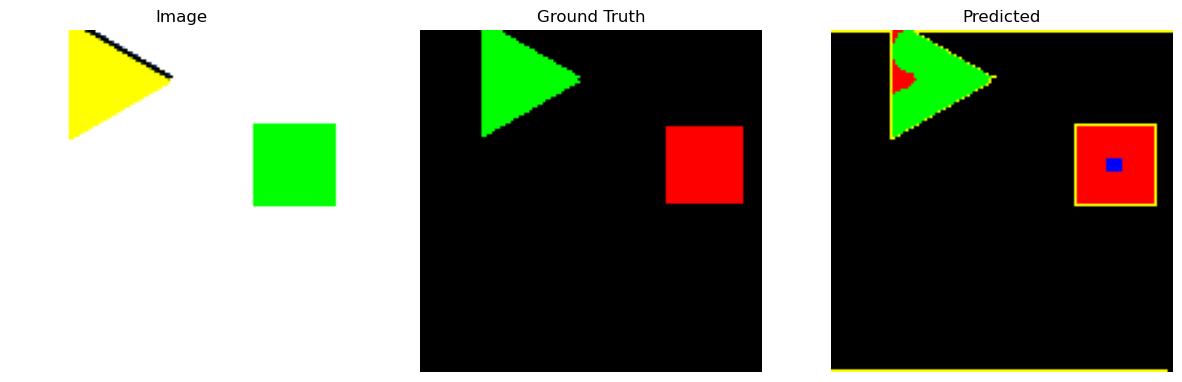

Epoch 15/100, Train Loss: 0.3469, Val Loss: 0.3540, Avg IoU: 0.7136, Avg Dice: 0.7537


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


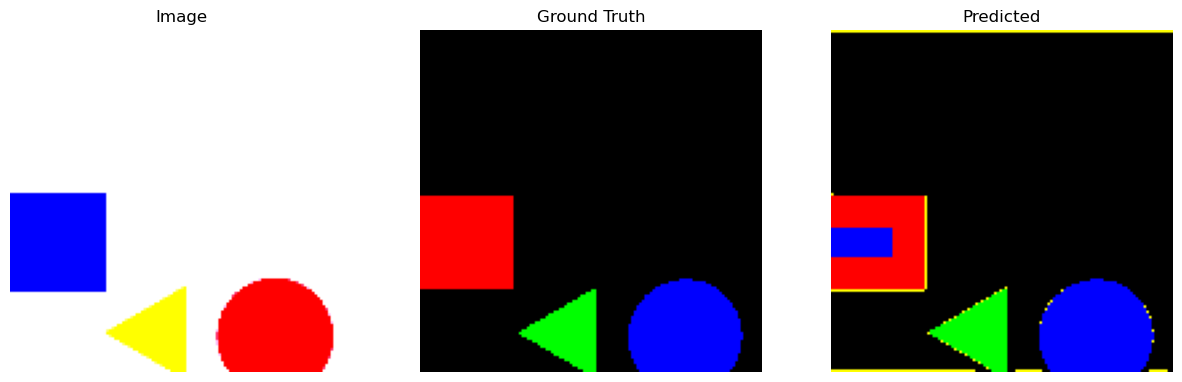

Epoch 16/100, Train Loss: 0.3464, Val Loss: 0.3472, Avg IoU: 0.7265, Avg Dice: 0.7610


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


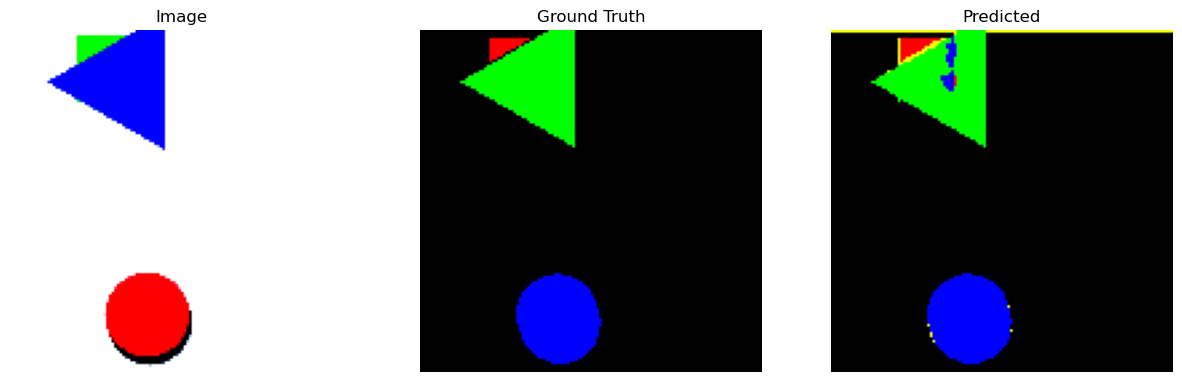

Epoch 17/100, Train Loss: 0.3453, Val Loss: 0.3495, Avg IoU: 0.7241, Avg Dice: 0.7583


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


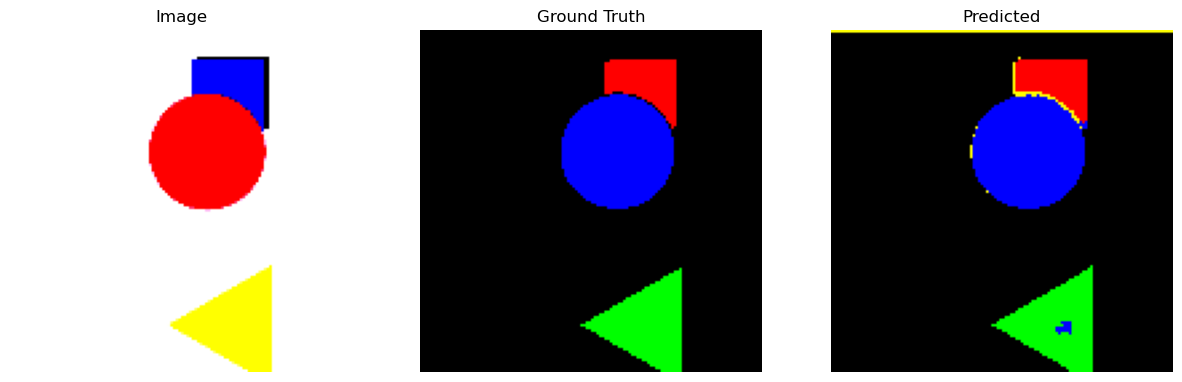

Epoch 18/100, Train Loss: 0.3432, Val Loss: 0.3566, Avg IoU: 0.7071, Avg Dice: 0.7485


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


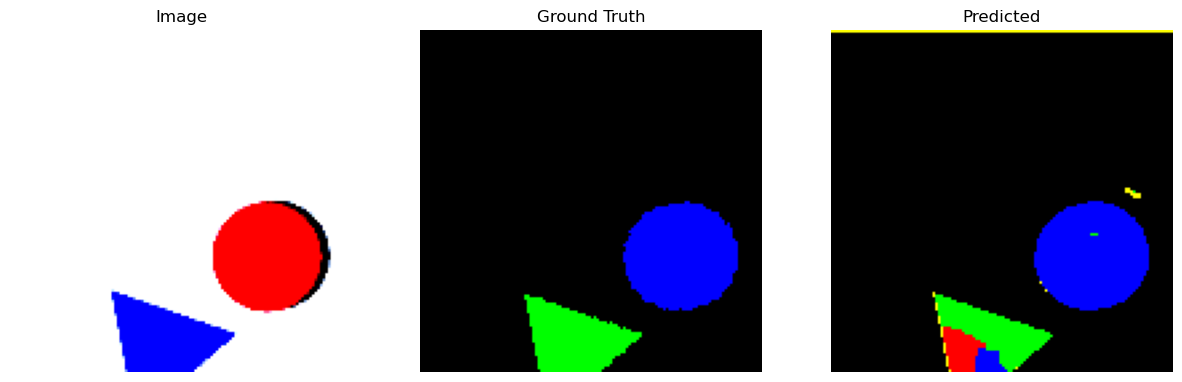

Epoch 19/100, Train Loss: 0.3541, Val Loss: 0.3700, Avg IoU: 0.7256, Avg Dice: 0.7604


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


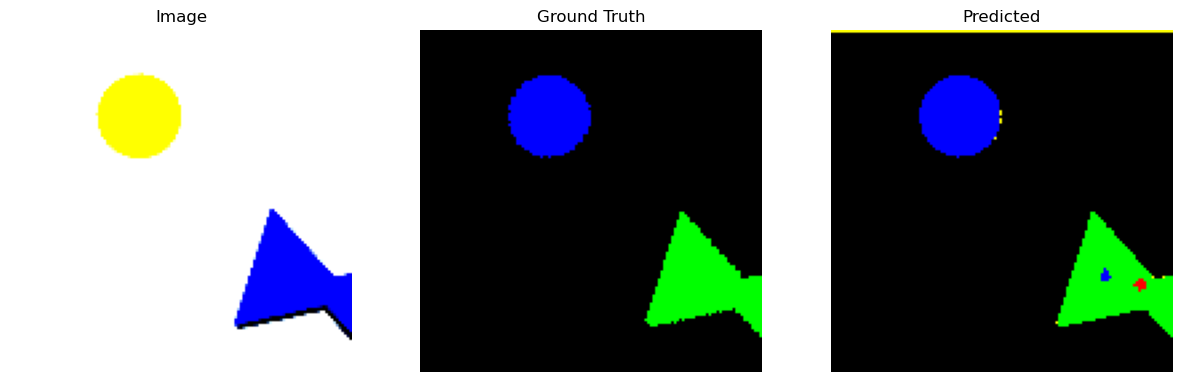

Epoch 20/100, Train Loss: 0.3430, Val Loss: 0.3482, Avg IoU: 0.7276, Avg Dice: 0.7619


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


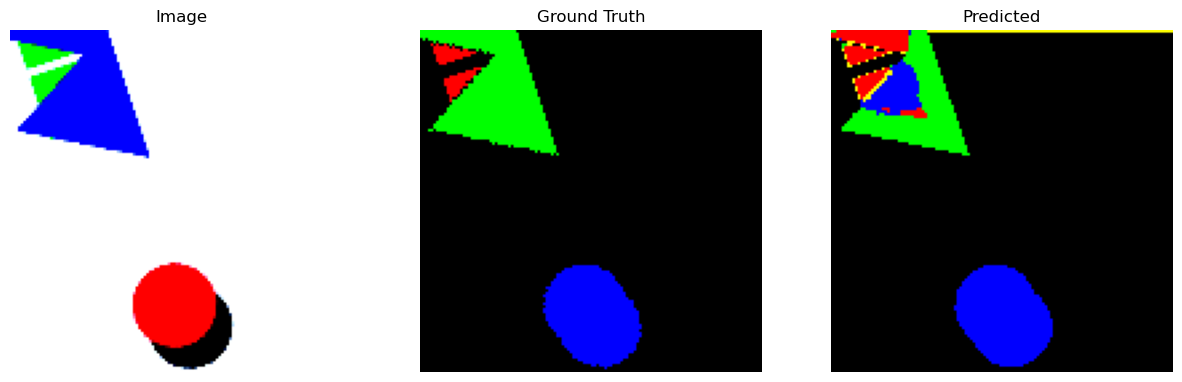

Epoch 21/100, Train Loss: 0.3416, Val Loss: 0.3453, Avg IoU: 0.7304, Avg Dice: 0.7628


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 22/100, Train Loss: 0.3420, Val Loss: 0.3513, Avg IoU: 0.7252, Avg Dice: 0.7597


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


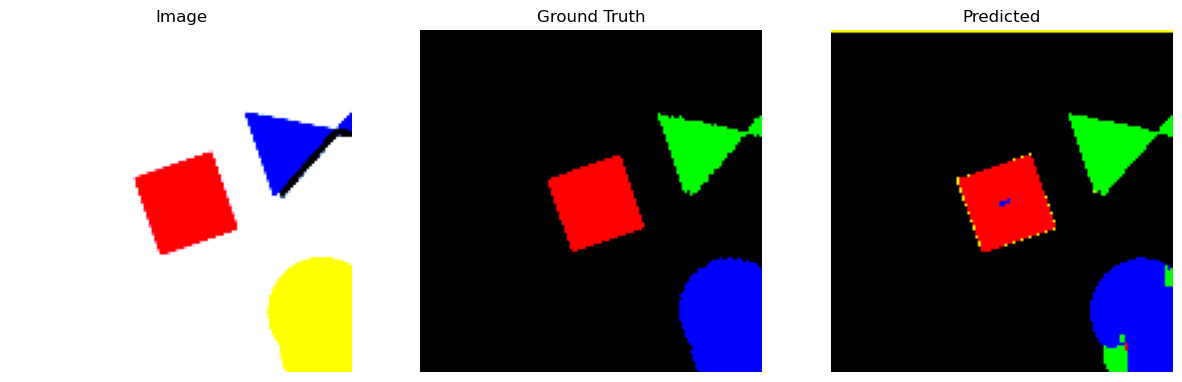

Epoch 23/100, Train Loss: 0.3403, Val Loss: 0.3462, Avg IoU: 0.7243, Avg Dice: 0.7596


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


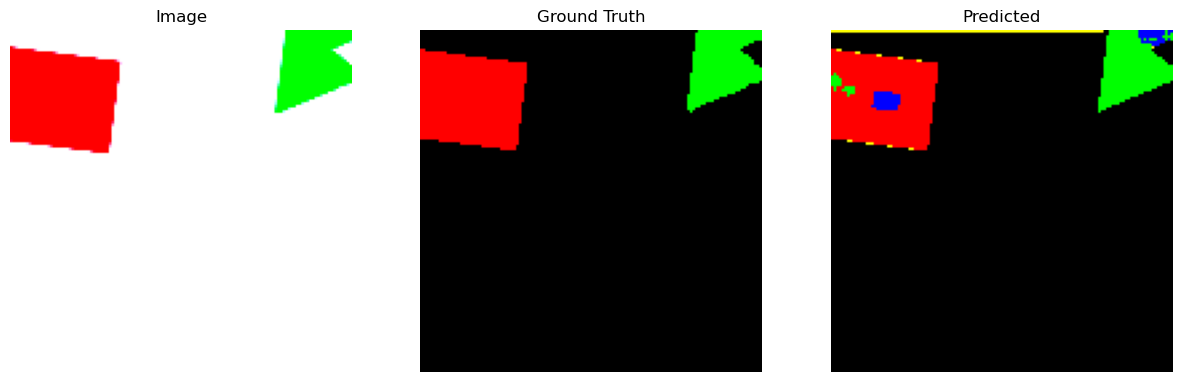

Epoch 24/100, Train Loss: 0.3414, Val Loss: 0.3441, Avg IoU: 0.7348, Avg Dice: 0.7643


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


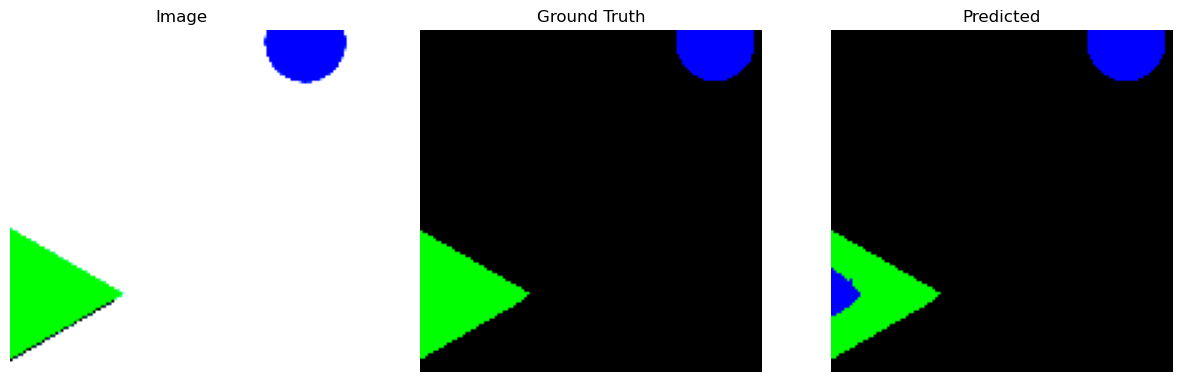

Epoch 25/100, Train Loss: 0.3383, Val Loss: 0.3426, Avg IoU: 0.7321, Avg Dice: 0.7639


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


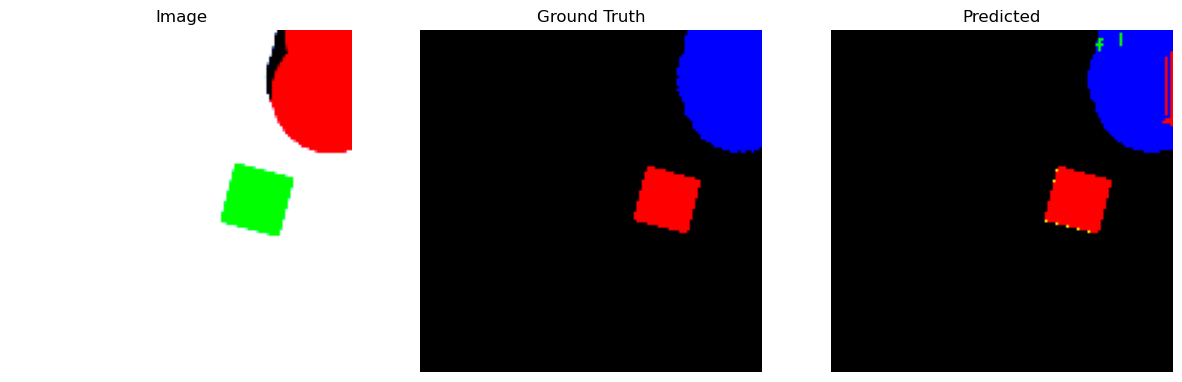

Epoch 26/100, Train Loss: 0.3391, Val Loss: 0.3464, Avg IoU: 0.7399, Avg Dice: 0.7696


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


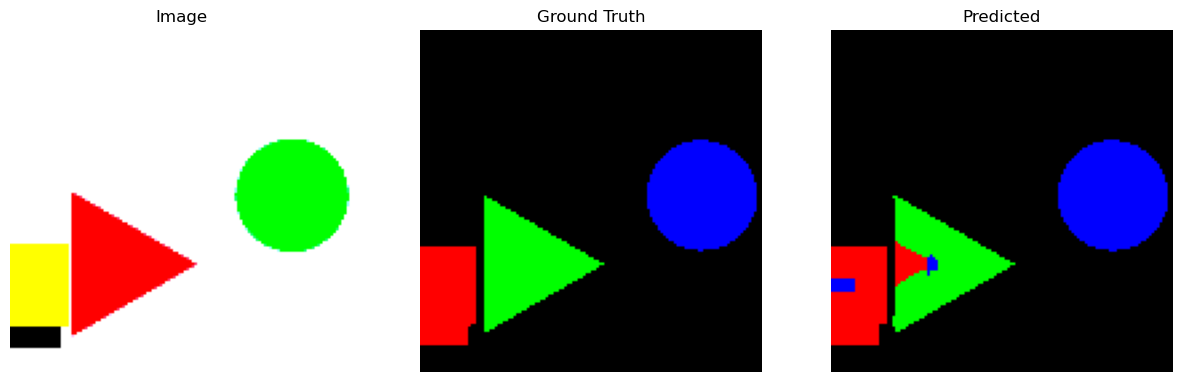

Epoch 27/100, Train Loss: 0.3385, Val Loss: 0.3411, Avg IoU: 0.7450, Avg Dice: 0.7724


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 28/100, Train Loss: 0.3380, Val Loss: 0.3439, Avg IoU: 0.7457, Avg Dice: 0.7728


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 29/100, Train Loss: 0.3369, Val Loss: 0.3385, Avg IoU: 0.7428, Avg Dice: 0.7699


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


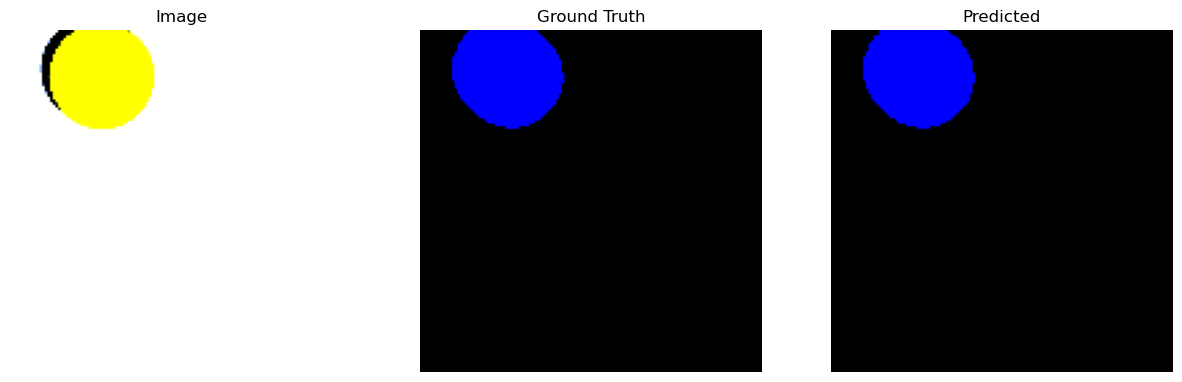

Epoch 30/100, Train Loss: 0.3363, Val Loss: 0.3389, Avg IoU: 0.7413, Avg Dice: 0.7691


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


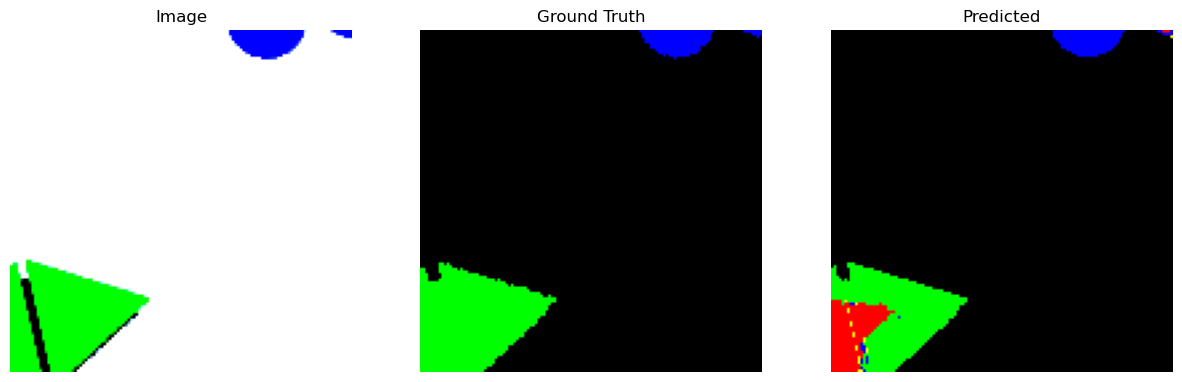

Epoch 31/100, Train Loss: 0.3340, Val Loss: 0.3348, Avg IoU: 0.7512, Avg Dice: 0.7745


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


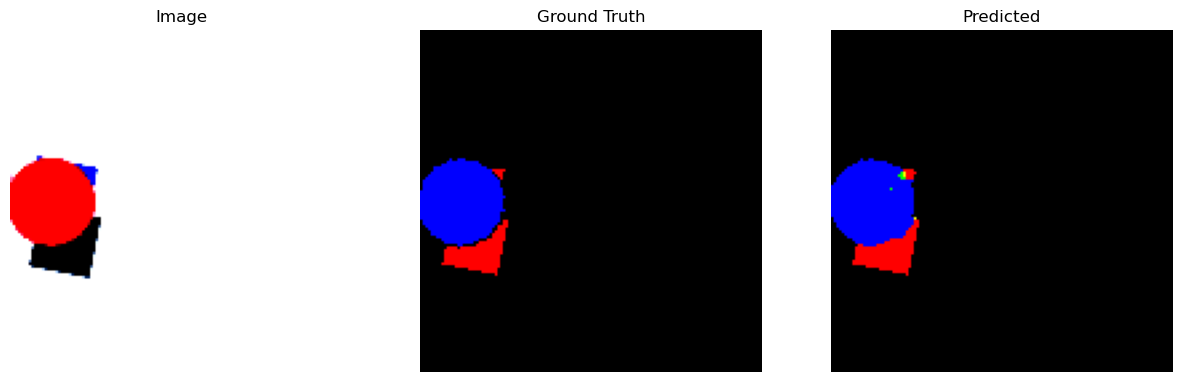

Epoch 32/100, Train Loss: 0.3328, Val Loss: 0.3342, Avg IoU: 0.7513, Avg Dice: 0.7746


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 33/100, Train Loss: 0.3338, Val Loss: 0.3393, Avg IoU: 0.7549, Avg Dice: 0.7779


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


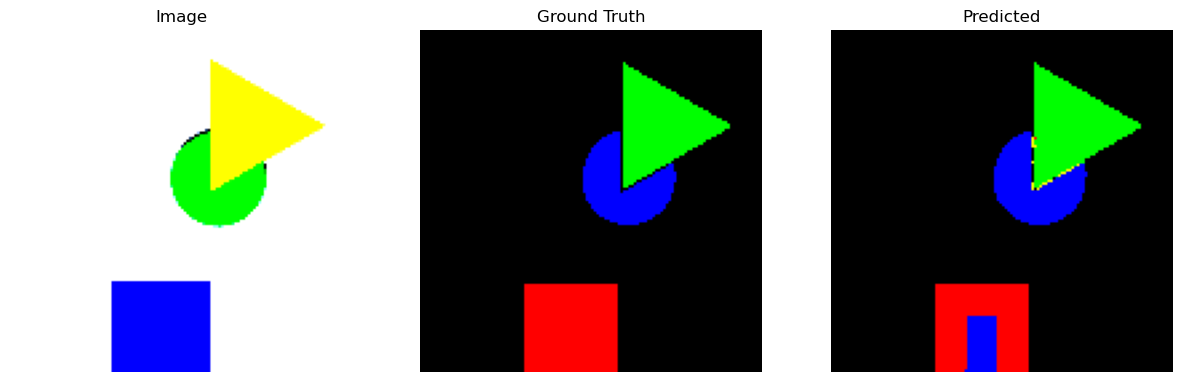

Epoch 34/100, Train Loss: 0.3328, Val Loss: 0.3343, Avg IoU: 0.7515, Avg Dice: 0.7747


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


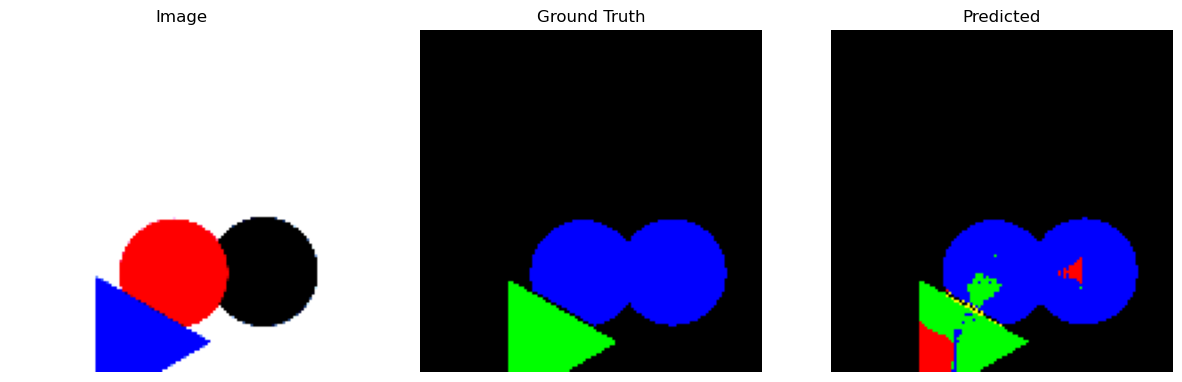

Epoch 35/100, Train Loss: 0.3326, Val Loss: 0.3345, Avg IoU: 0.7512, Avg Dice: 0.7745


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


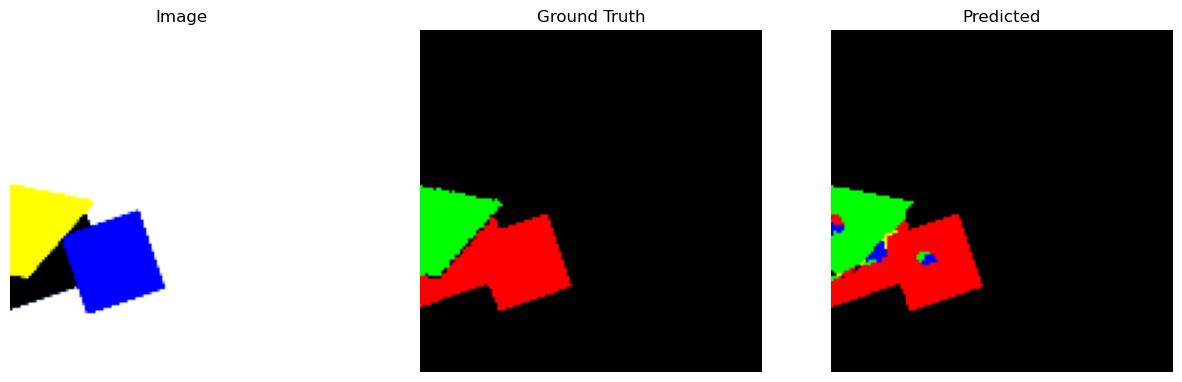

Epoch 36/100, Train Loss: 0.3325, Val Loss: 0.3340, Avg IoU: 0.7551, Avg Dice: 0.7780


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


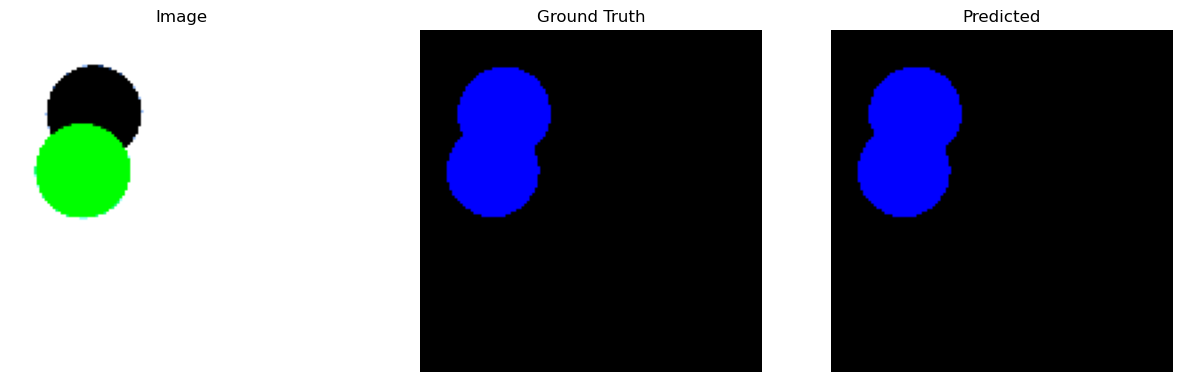

Epoch 37/100, Train Loss: 0.3318, Val Loss: 0.3362, Avg IoU: 0.7505, Avg Dice: 0.7729


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


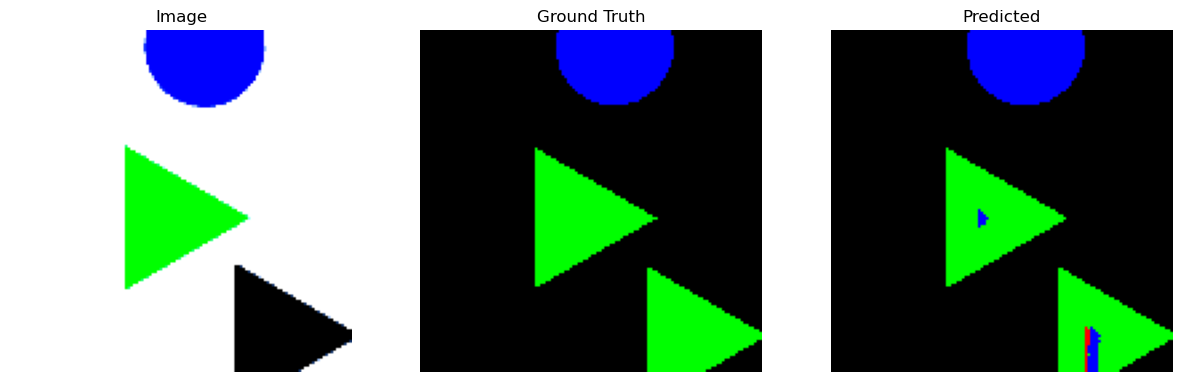

Epoch 38/100, Train Loss: 0.3317, Val Loss: 0.3373, Avg IoU: 0.7491, Avg Dice: 0.7721


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


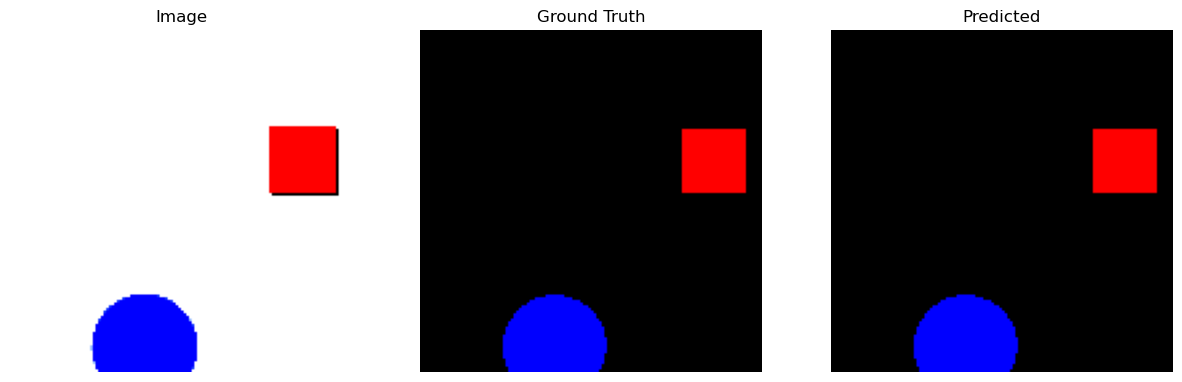

Epoch 39/100, Train Loss: 0.3315, Val Loss: 0.3346, Avg IoU: 0.7543, Avg Dice: 0.7776


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 40/100, Train Loss: 0.3326, Val Loss: 0.3353, Avg IoU: 0.7506, Avg Dice: 0.7742


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


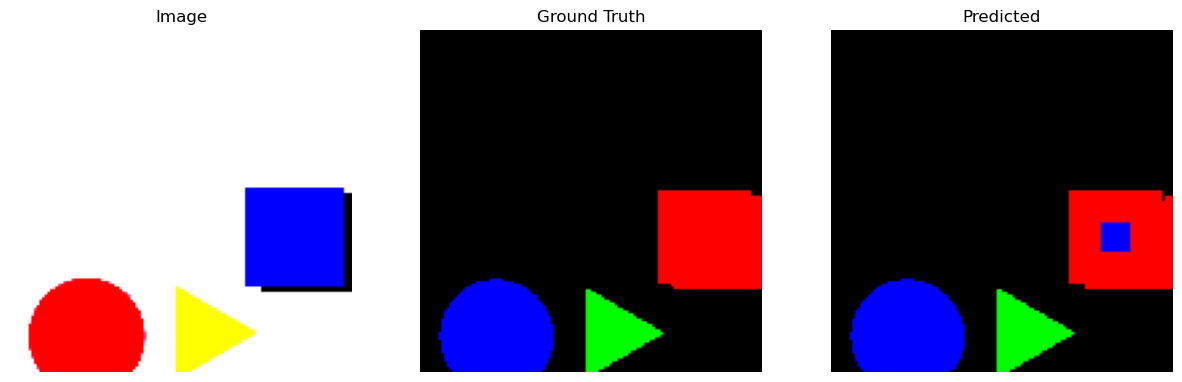

Epoch 41/100, Train Loss: 0.3324, Val Loss: 0.3397, Avg IoU: 0.7477, Avg Dice: 0.7721


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


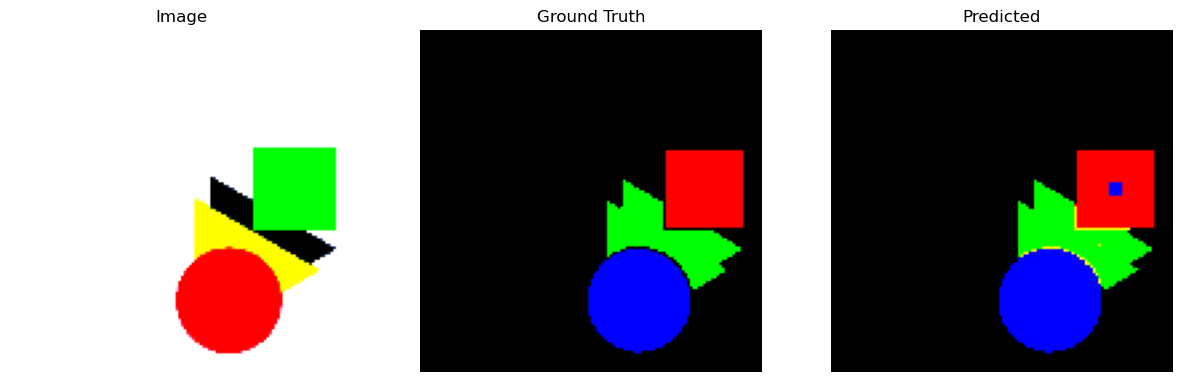

Epoch 42/100, Train Loss: 0.3320, Val Loss: 0.3380, Avg IoU: 0.7480, Avg Dice: 0.7710


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 43/100, Train Loss: 0.3322, Val Loss: 0.3347, Avg IoU: 0.7519, Avg Dice: 0.7749


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


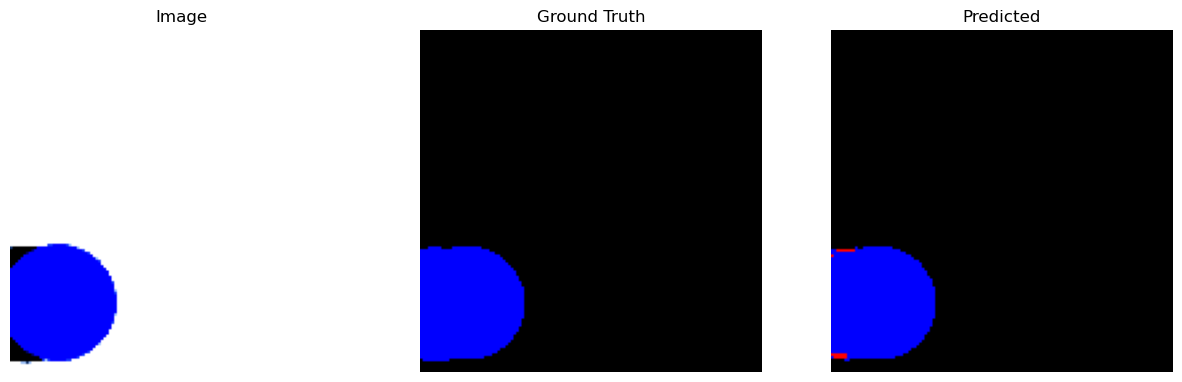

Epoch 44/100, Train Loss: 0.3321, Val Loss: 0.3365, Avg IoU: 0.7496, Avg Dice: 0.7723


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 45/100, Train Loss: 0.3308, Val Loss: 0.3364, Avg IoU: 0.7555, Avg Dice: 0.7783


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


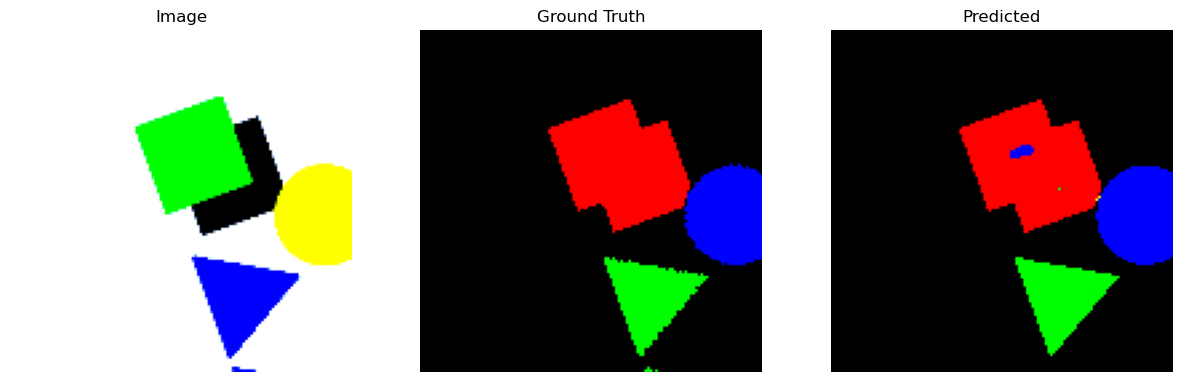

Epoch 46/100, Train Loss: 0.3314, Val Loss: 0.3358, Avg IoU: 0.7533, Avg Dice: 0.7760


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


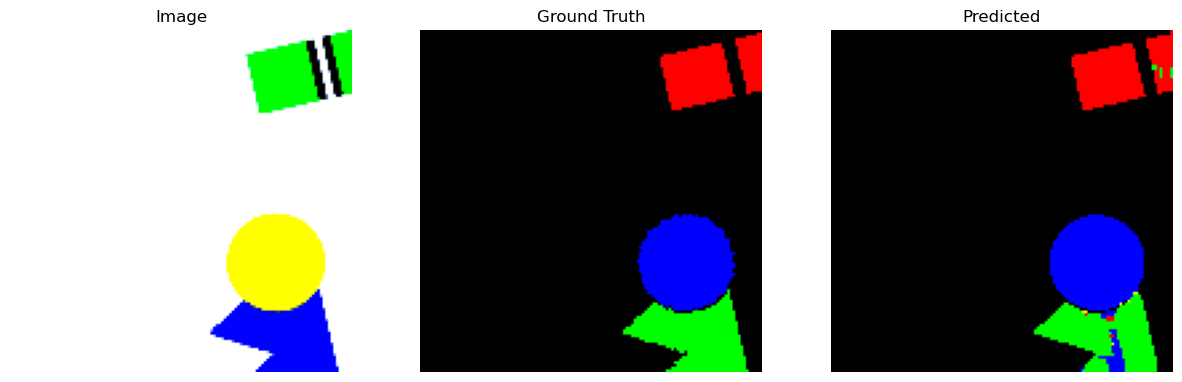

Epoch 47/100, Train Loss: 0.3308, Val Loss: 0.3354, Avg IoU: 0.7518, Avg Dice: 0.7735


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


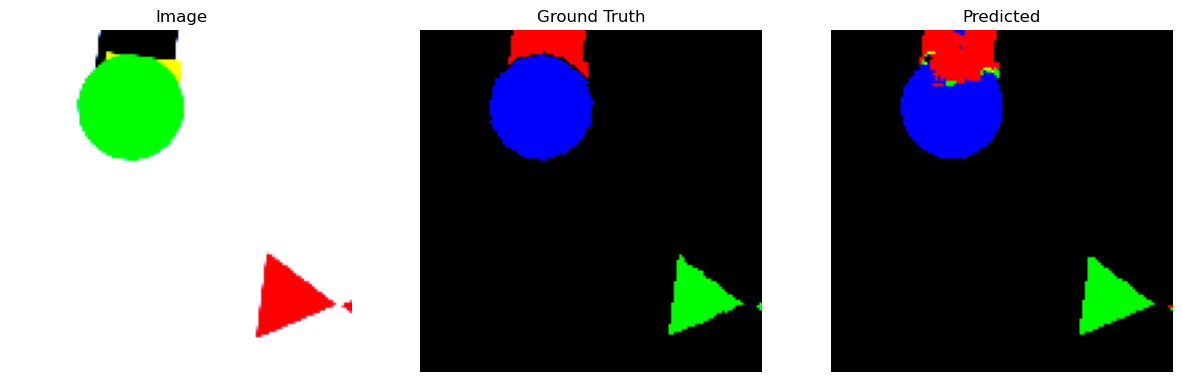

Epoch 48/100, Train Loss: 0.3310, Val Loss: 0.3333, Avg IoU: 0.7562, Avg Dice: 0.7786


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


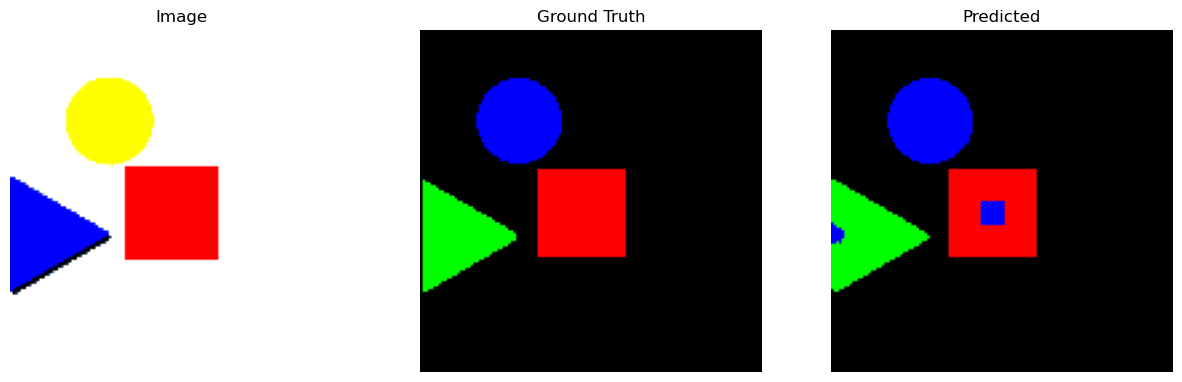

Epoch 49/100, Train Loss: 0.3312, Val Loss: 0.3358, Avg IoU: 0.7535, Avg Dice: 0.7762


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 50/100, Train Loss: 0.3318, Val Loss: 0.3365, Avg IoU: 0.7523, Avg Dice: 0.7756


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 51/100, Train Loss: 0.3304, Val Loss: 0.3338, Avg IoU: 0.7532, Avg Dice: 0.7756


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


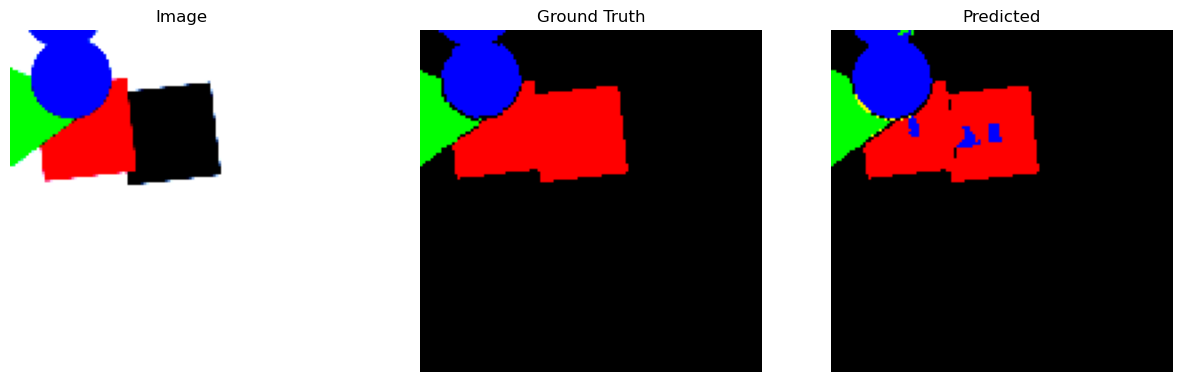

Epoch 52/100, Train Loss: 0.3305, Val Loss: 0.3356, Avg IoU: 0.7510, Avg Dice: 0.7731


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 53/100, Train Loss: 0.3303, Val Loss: 0.3355, Avg IoU: 0.7536, Avg Dice: 0.7763


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


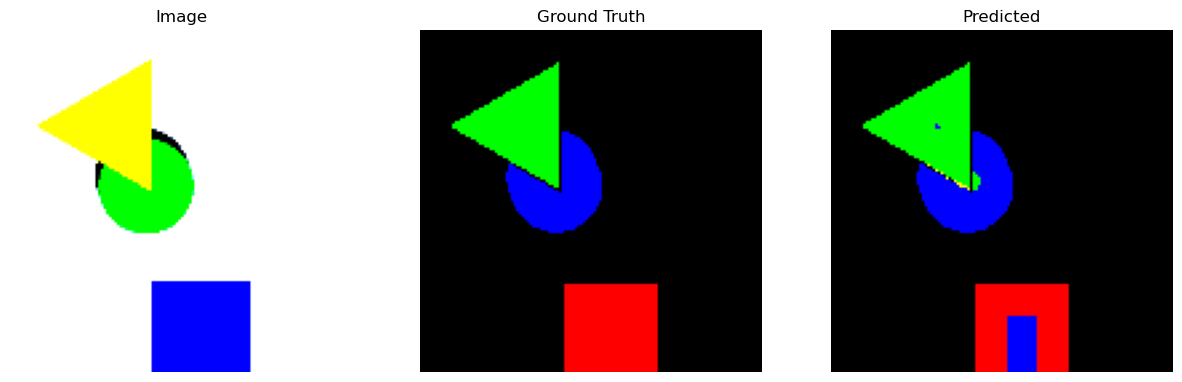

Epoch 54/100, Train Loss: 0.3309, Val Loss: 0.3351, Avg IoU: 0.7529, Avg Dice: 0.7741


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


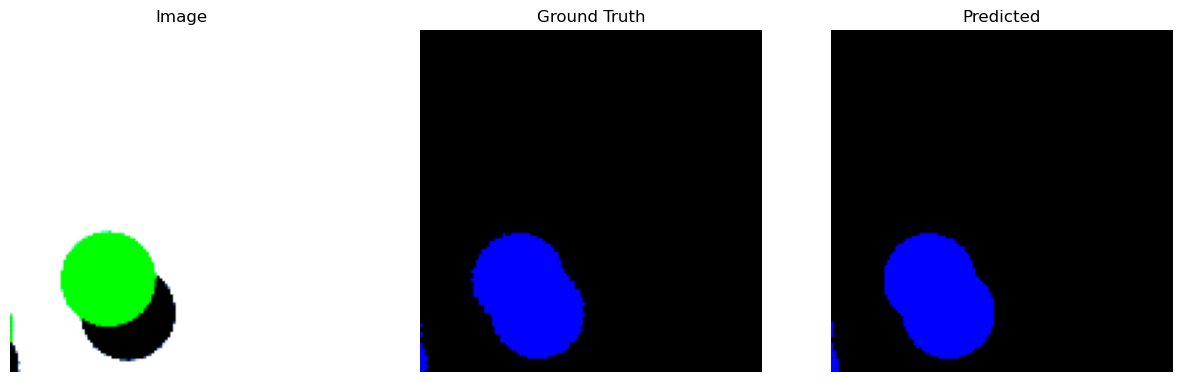

Epoch 55/100, Train Loss: 0.3306, Val Loss: 0.3329, Avg IoU: 0.7550, Avg Dice: 0.7766


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


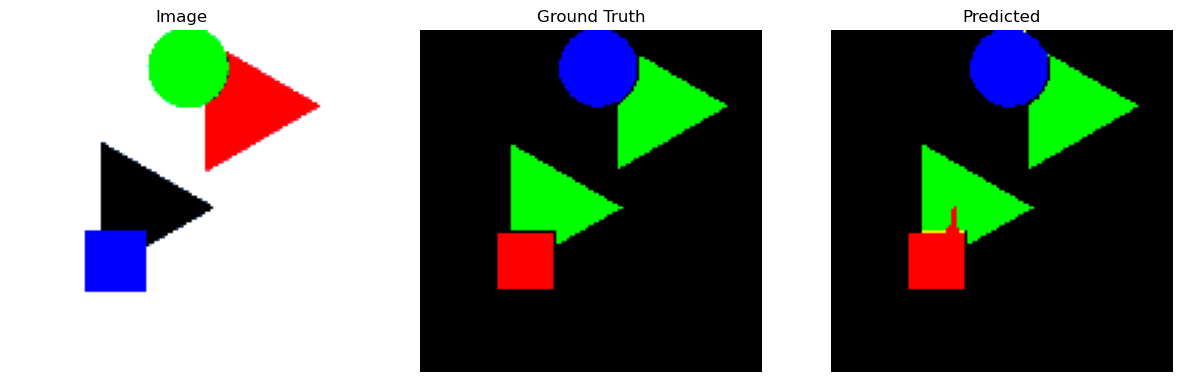

Epoch 56/100, Train Loss: 0.3304, Val Loss: 0.3337, Avg IoU: 0.7561, Avg Dice: 0.7786


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


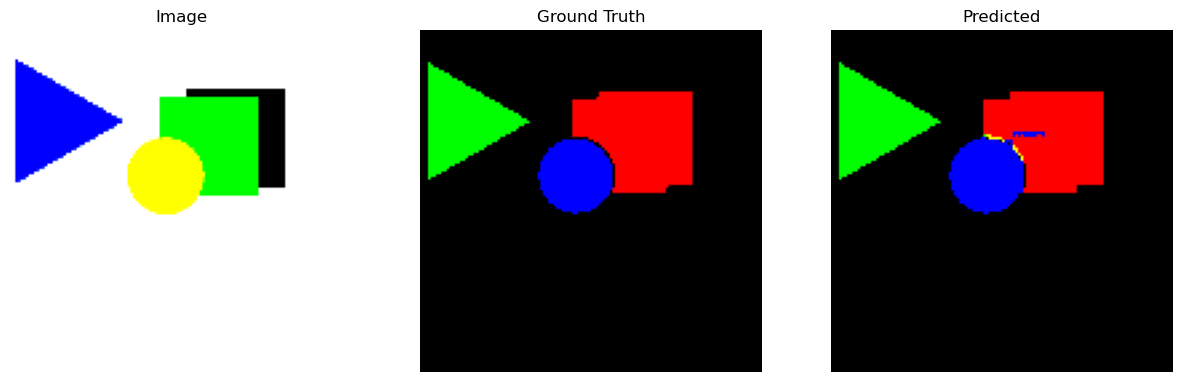

Epoch 57/100, Train Loss: 0.3301, Val Loss: 0.3369, Avg IoU: 0.7501, Avg Dice: 0.7744


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


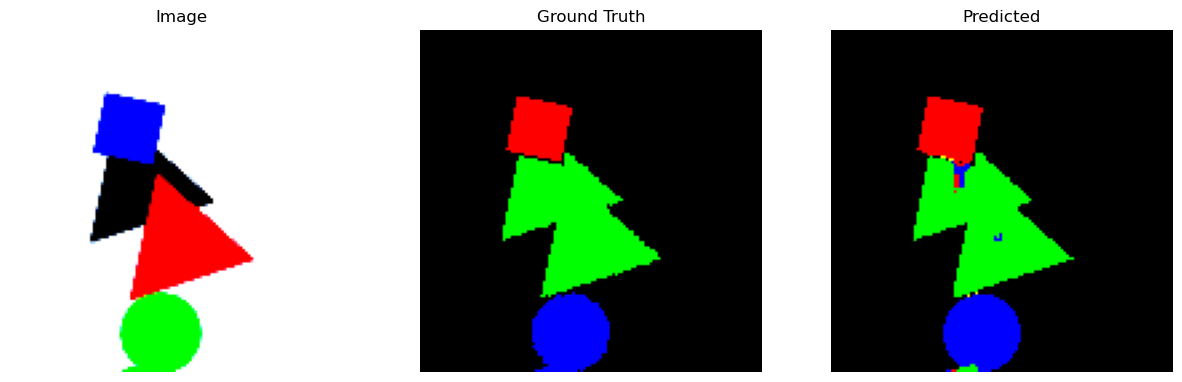

Epoch 58/100, Train Loss: 0.3303, Val Loss: 0.3364, Avg IoU: 0.7507, Avg Dice: 0.7730


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


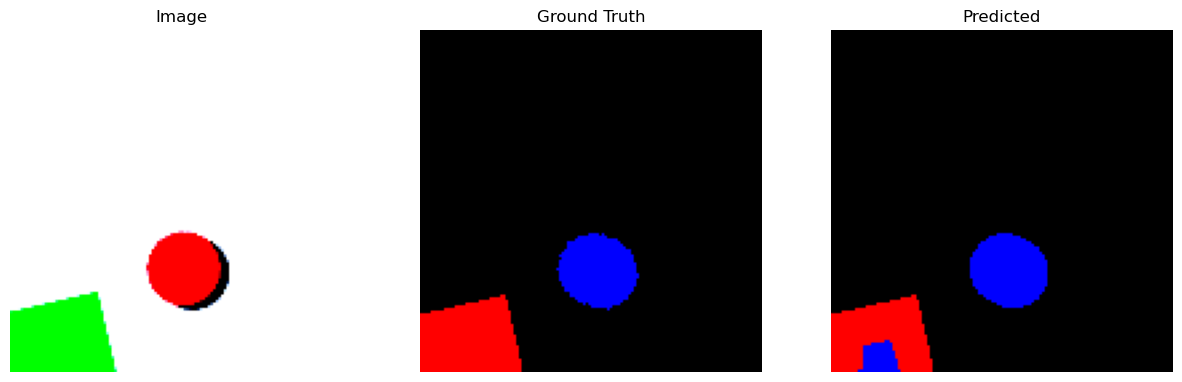

Epoch 59/100, Train Loss: 0.3309, Val Loss: 0.3368, Avg IoU: 0.7505, Avg Dice: 0.7746


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 60/100, Train Loss: 0.3304, Val Loss: 0.3383, Avg IoU: 0.7580, Avg Dice: 0.7796


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


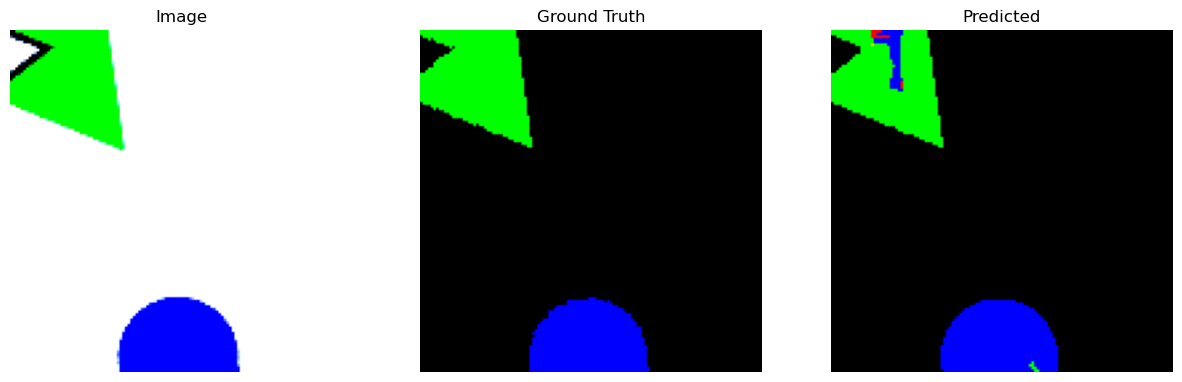

Epoch 61/100, Train Loss: 0.3304, Val Loss: 0.3338, Avg IoU: 0.7546, Avg Dice: 0.7778


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


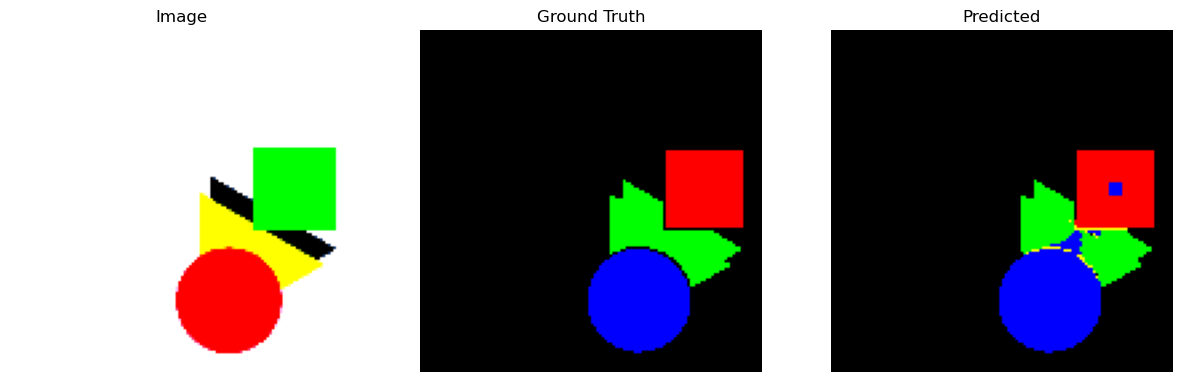

Epoch 62/100, Train Loss: 0.3302, Val Loss: 0.3330, Avg IoU: 0.7553, Avg Dice: 0.7768


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


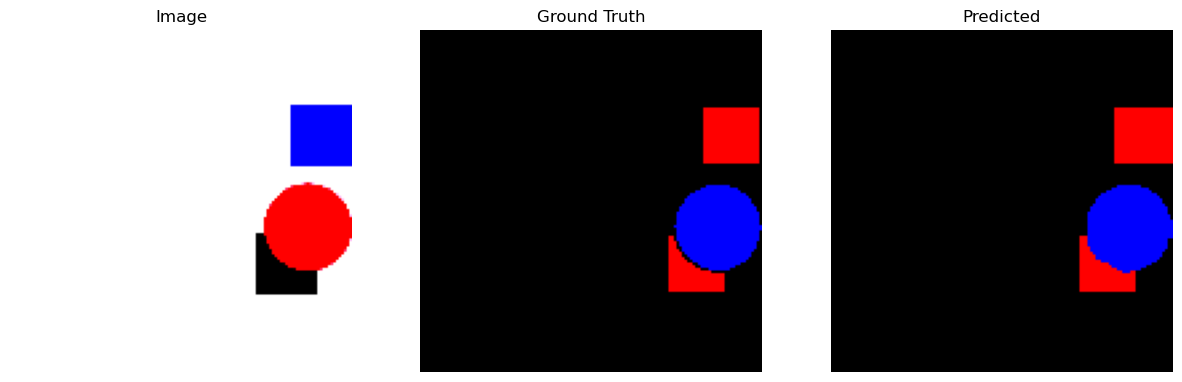

Epoch 63/100, Train Loss: 0.3302, Val Loss: 0.3332, Avg IoU: 0.7546, Avg Dice: 0.7764


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


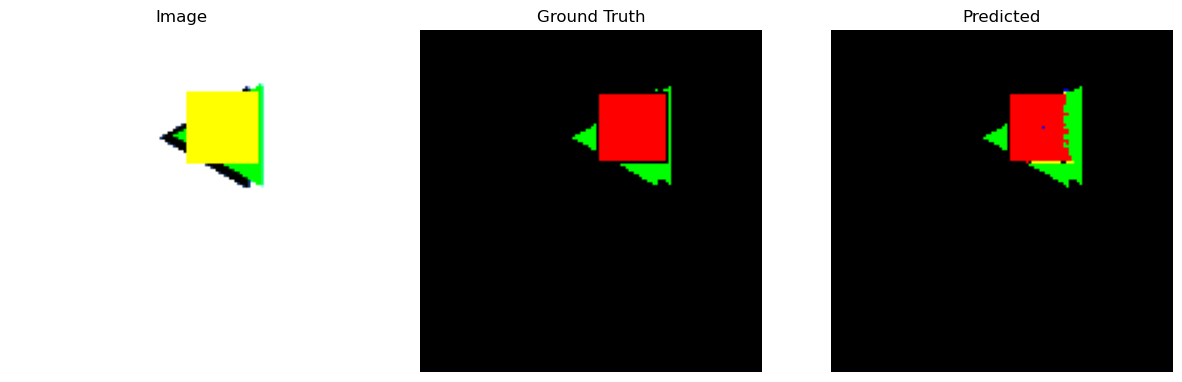

Epoch 64/100, Train Loss: 0.3309, Val Loss: 0.3357, Avg IoU: 0.7519, Avg Dice: 0.7736


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 65/100, Train Loss: 0.3304, Val Loss: 0.3338, Avg IoU: 0.7524, Avg Dice: 0.7752


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 66/100, Train Loss: 0.3301, Val Loss: 0.3355, Avg IoU: 0.7587, Avg Dice: 0.7799


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


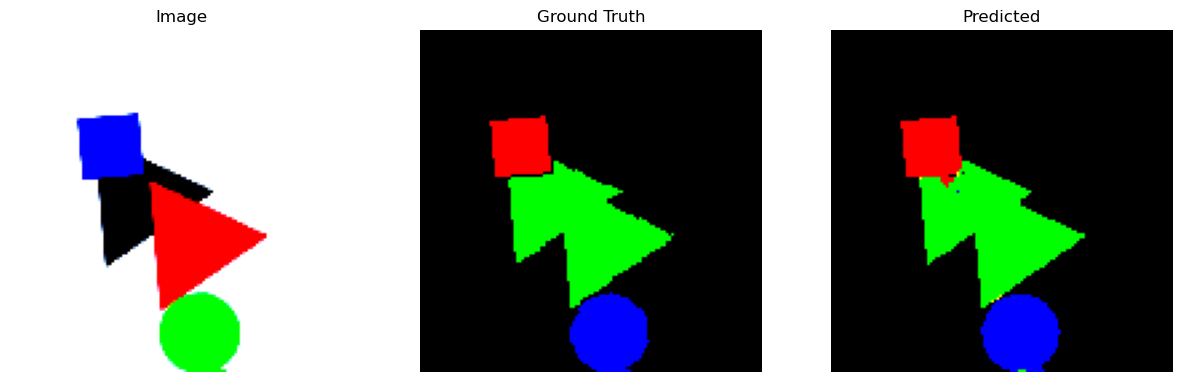

Epoch 67/100, Train Loss: 0.3301, Val Loss: 0.3327, Avg IoU: 0.7546, Avg Dice: 0.7764


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 68/100, Train Loss: 0.3300, Val Loss: 0.3341, Avg IoU: 0.7520, Avg Dice: 0.7749


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


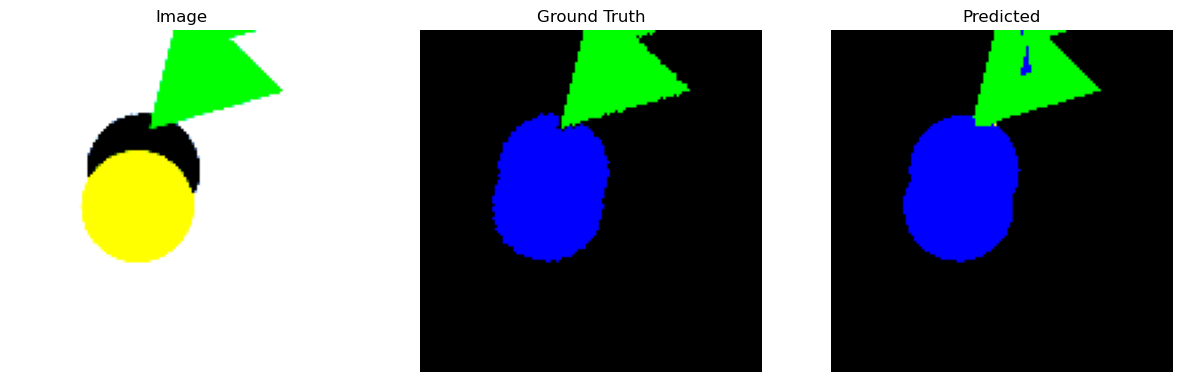

Epoch 69/100, Train Loss: 0.3301, Val Loss: 0.3326, Avg IoU: 0.7560, Avg Dice: 0.7771


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


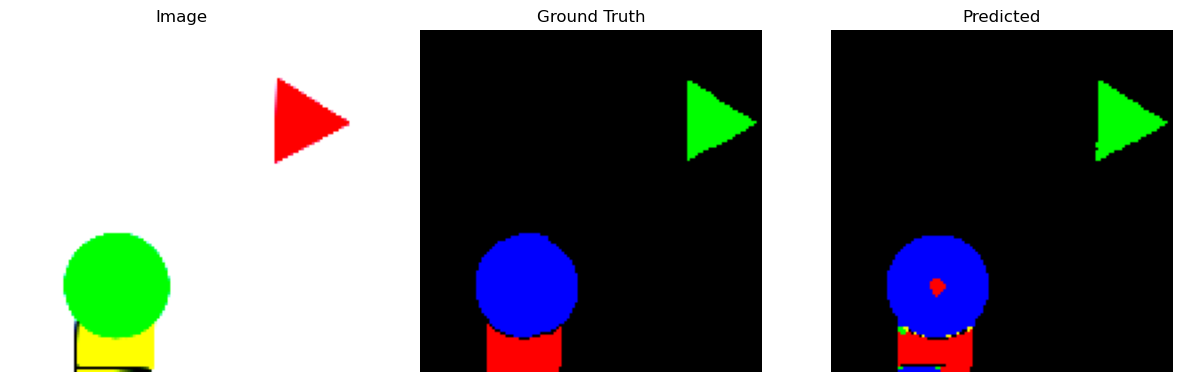

Epoch 70/100, Train Loss: 0.3302, Val Loss: 0.3336, Avg IoU: 0.7555, Avg Dice: 0.7782


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


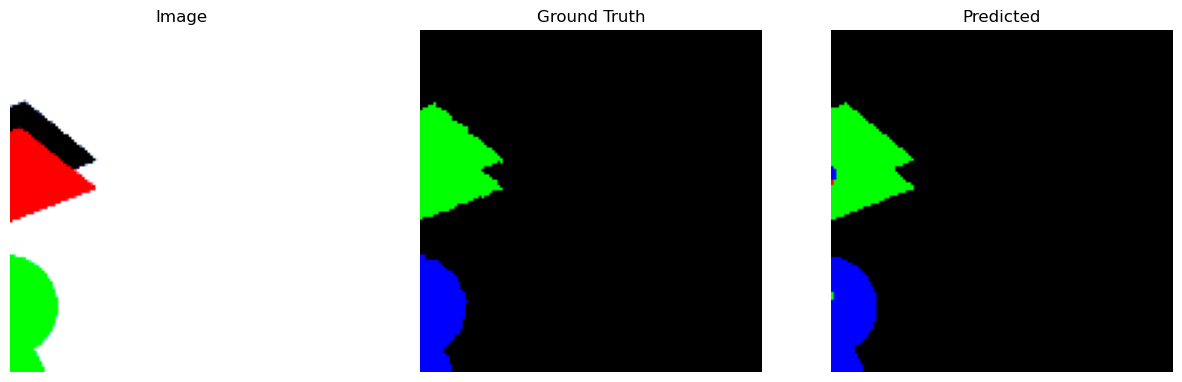

Epoch 71/100, Train Loss: 0.3300, Val Loss: 0.3334, Avg IoU: 0.7531, Avg Dice: 0.7755


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 72/100, Train Loss: 0.3306, Val Loss: 0.3337, Avg IoU: 0.7526, Avg Dice: 0.7753


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


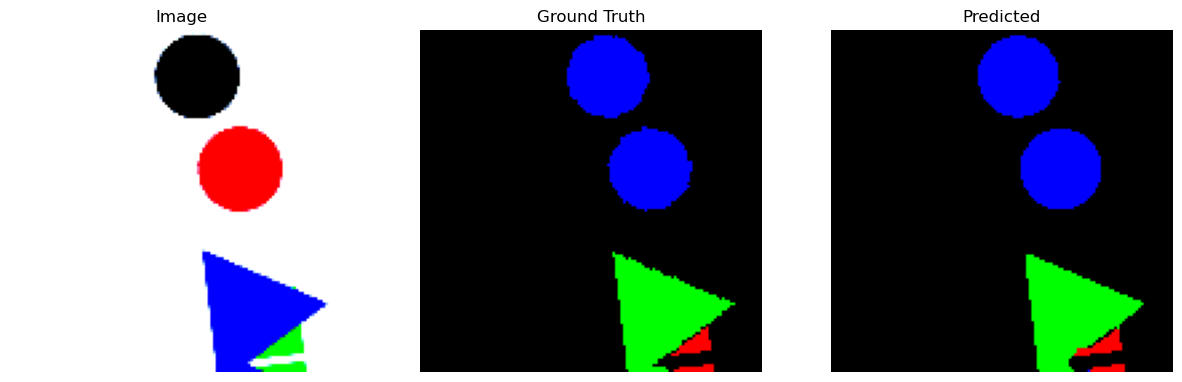

Epoch 73/100, Train Loss: 0.3303, Val Loss: 0.3331, Avg IoU: 0.7581, Avg Dice: 0.7795


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


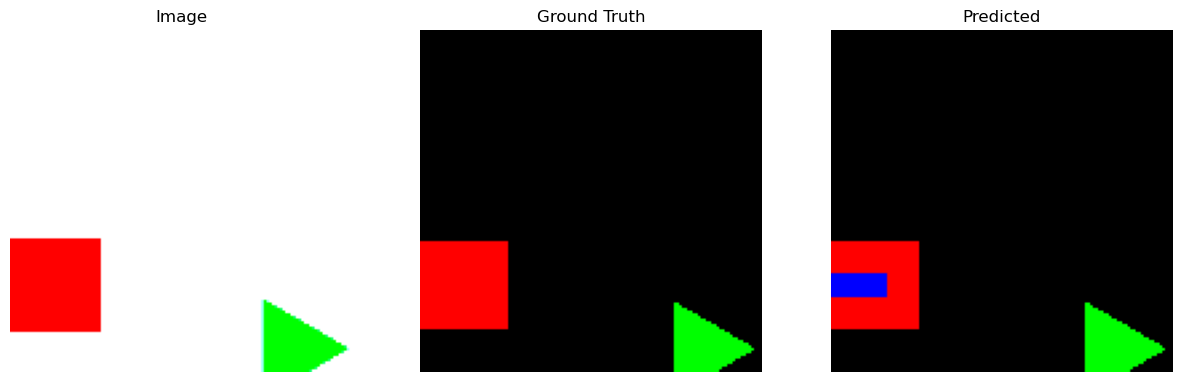

Epoch 74/100, Train Loss: 0.3300, Val Loss: 0.3360, Avg IoU: 0.7506, Avg Dice: 0.7729


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


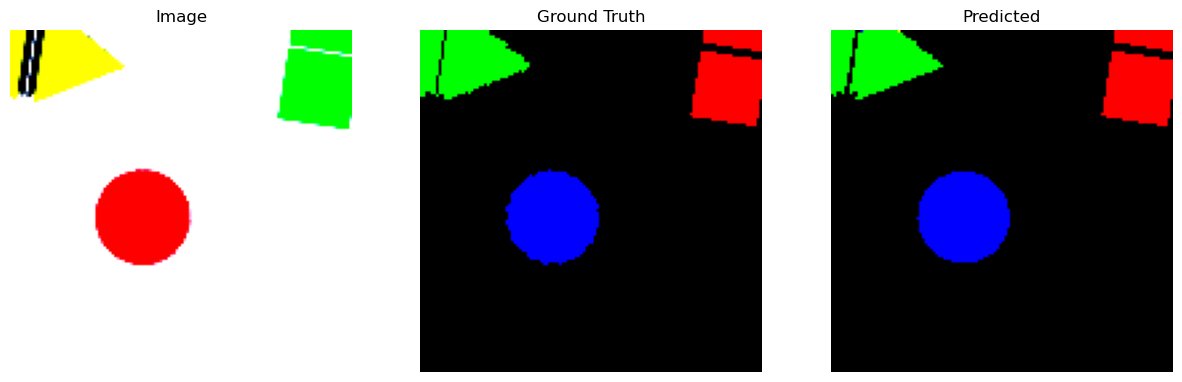

Epoch 75/100, Train Loss: 0.3294, Val Loss: 0.3384, Avg IoU: 0.7523, Avg Dice: 0.7762


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 76/100, Train Loss: 0.3299, Val Loss: 0.3327, Avg IoU: 0.7579, Avg Dice: 0.7795


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


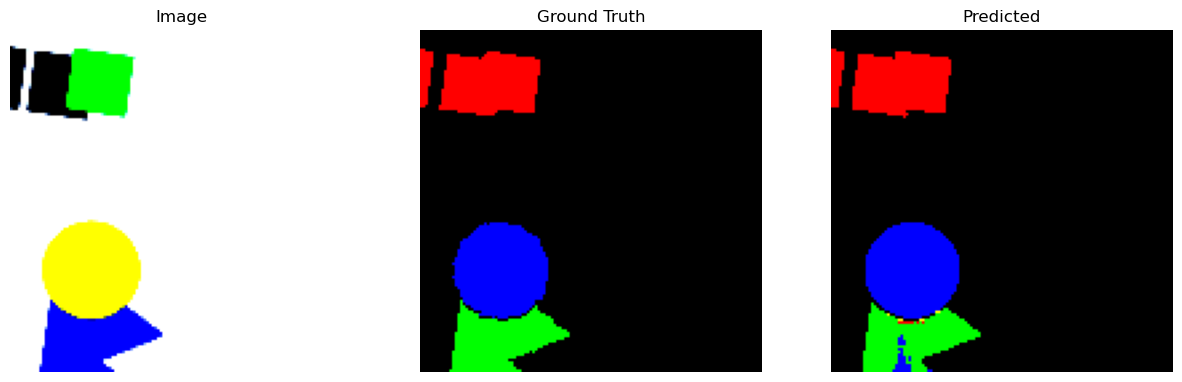

Epoch 77/100, Train Loss: 0.3295, Val Loss: 0.3362, Avg IoU: 0.7500, Avg Dice: 0.7726


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


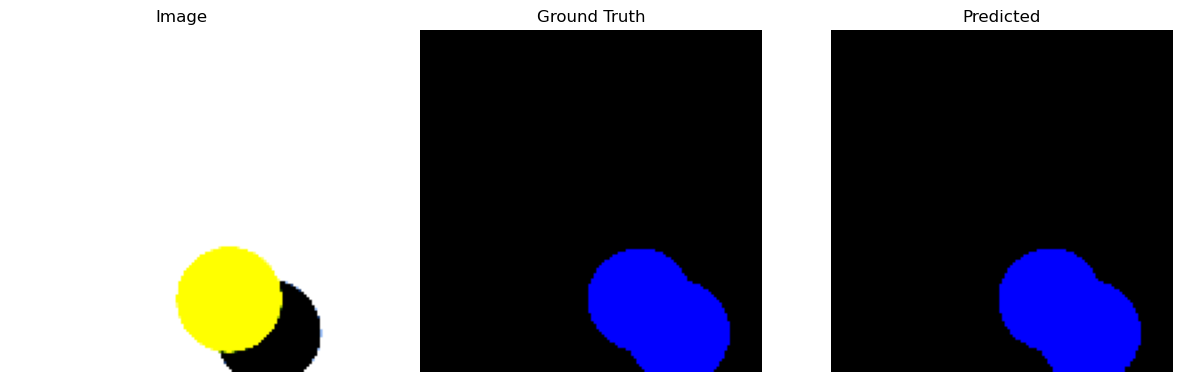

Epoch 78/100, Train Loss: 0.3295, Val Loss: 0.3365, Avg IoU: 0.7525, Avg Dice: 0.7757


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


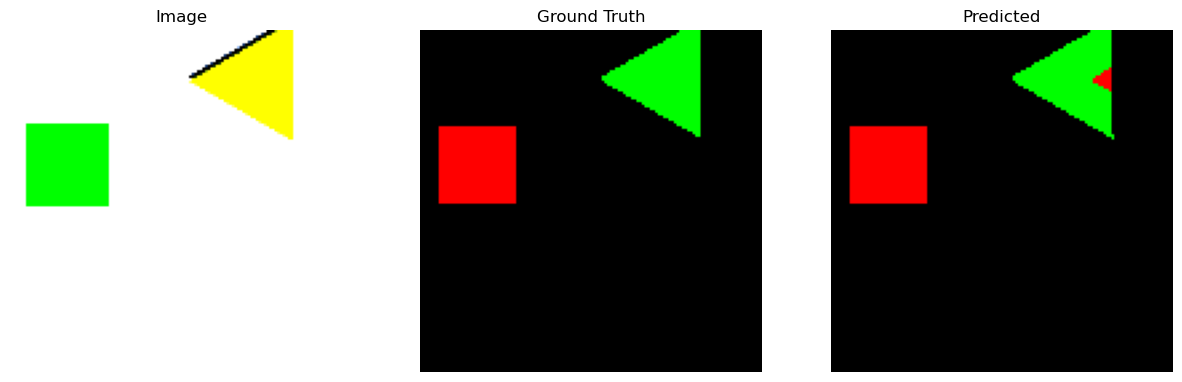

Epoch 79/100, Train Loss: 0.3295, Val Loss: 0.3355, Avg IoU: 0.7511, Avg Dice: 0.7732


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


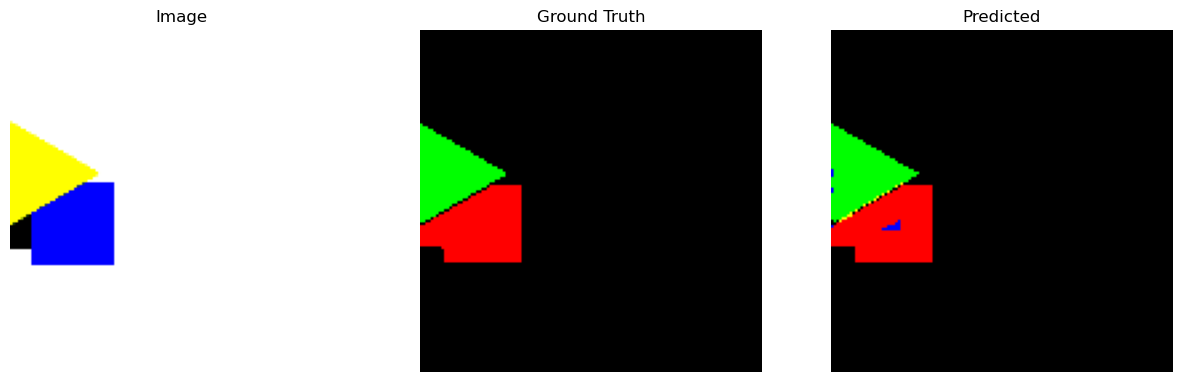

Epoch 80/100, Train Loss: 0.3299, Val Loss: 0.3358, Avg IoU: 0.7568, Avg Dice: 0.7789


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


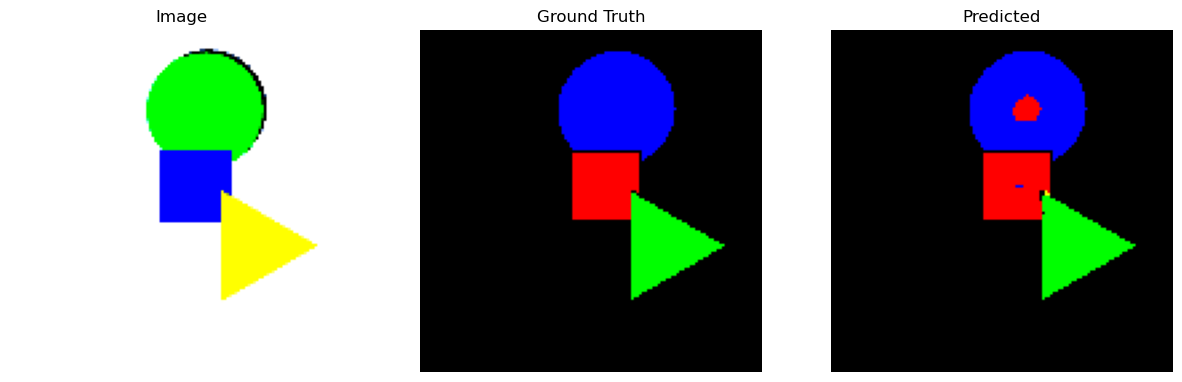

Epoch 81/100, Train Loss: 0.3294, Val Loss: 0.3336, Avg IoU: 0.7525, Avg Dice: 0.7752


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


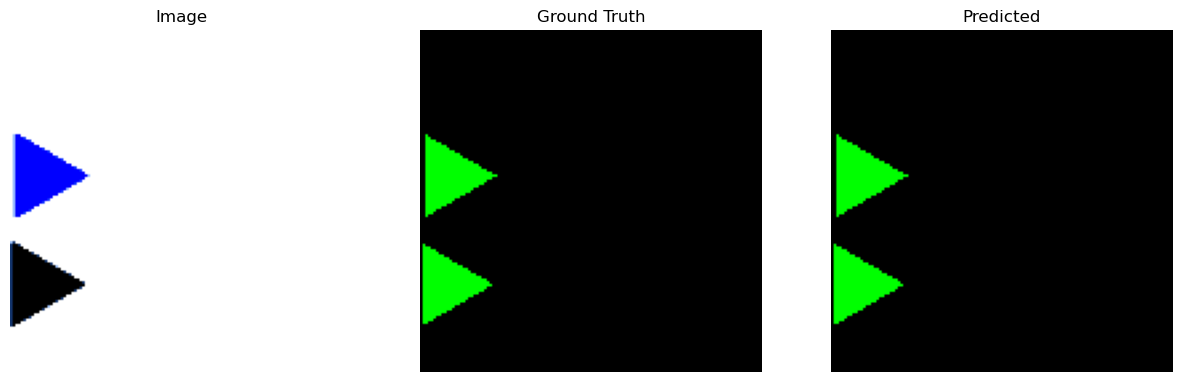

Epoch 82/100, Train Loss: 0.3295, Val Loss: 0.3332, Avg IoU: 0.7535, Avg Dice: 0.7758


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


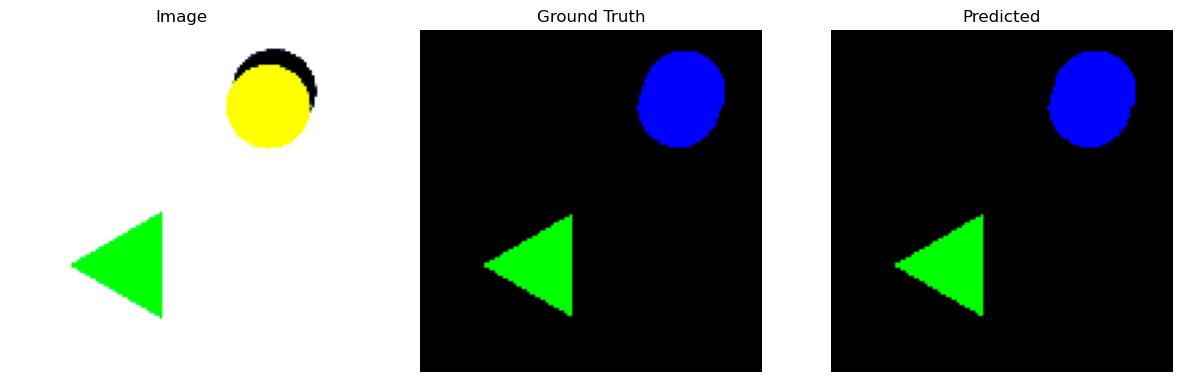

Epoch 83/100, Train Loss: 0.3299, Val Loss: 0.3381, Avg IoU: 0.7570, Avg Dice: 0.7790


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


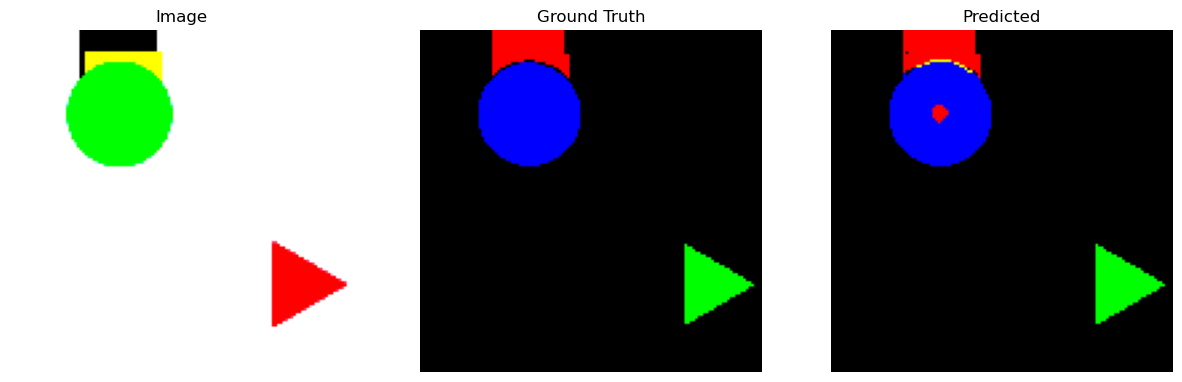

Epoch 84/100, Train Loss: 0.3305, Val Loss: 0.3346, Avg IoU: 0.7508, Avg Dice: 0.7742


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


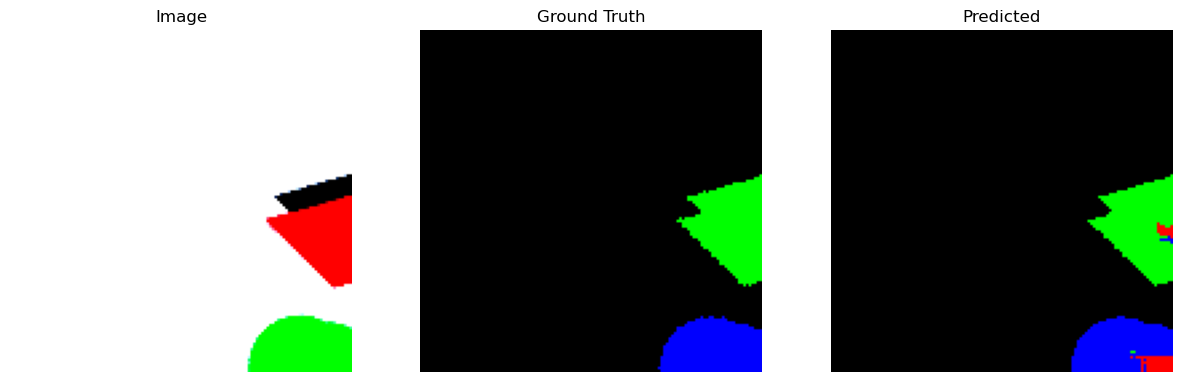

Epoch 85/100, Train Loss: 0.3292, Val Loss: 0.3379, Avg IoU: 0.7579, Avg Dice: 0.7795


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


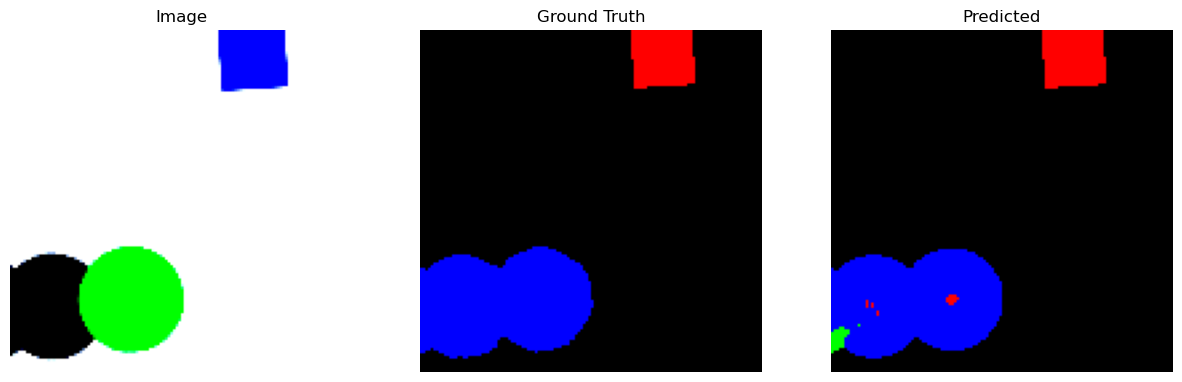

Epoch 86/100, Train Loss: 0.3295, Val Loss: 0.3323, Avg IoU: 0.7573, Avg Dice: 0.7792


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


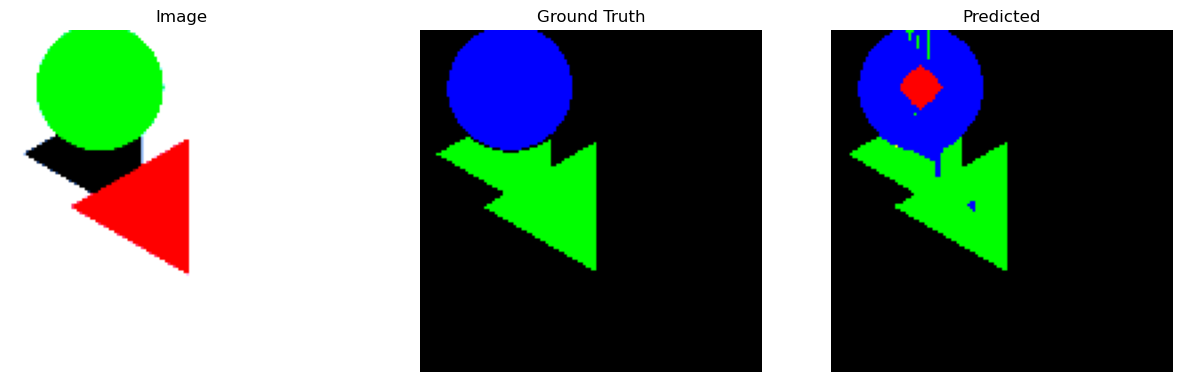

Epoch 87/100, Train Loss: 0.3294, Val Loss: 0.3382, Avg IoU: 0.7564, Avg Dice: 0.7786


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


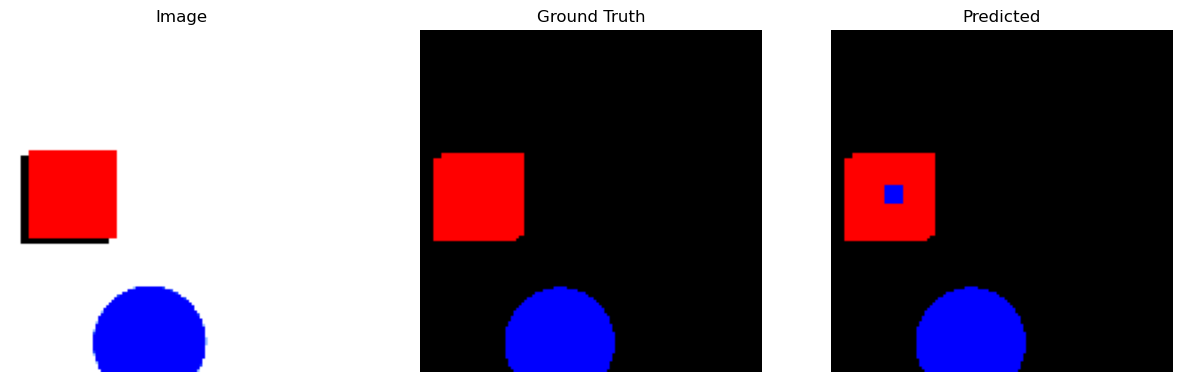

Epoch 88/100, Train Loss: 0.3295, Val Loss: 0.3355, Avg IoU: 0.7565, Avg Dice: 0.7788


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


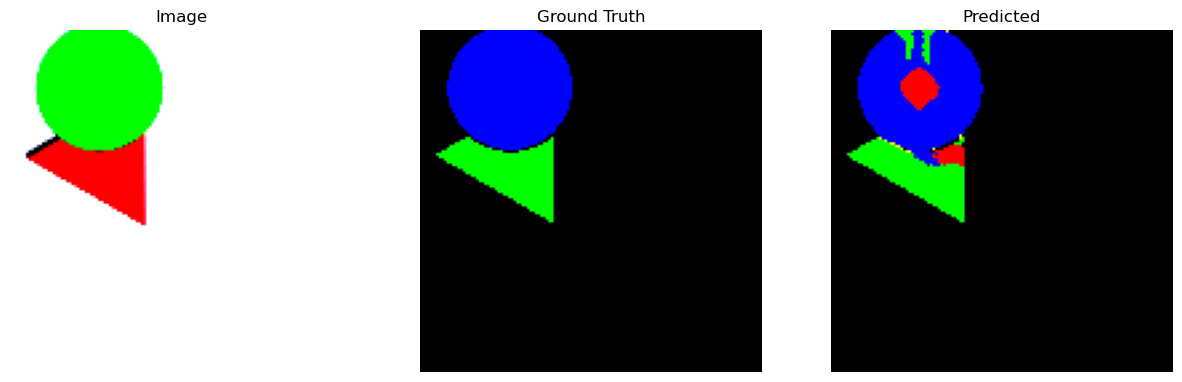

Epoch 89/100, Train Loss: 0.3305, Val Loss: 0.3363, Avg IoU: 0.7501, Avg Dice: 0.7727


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


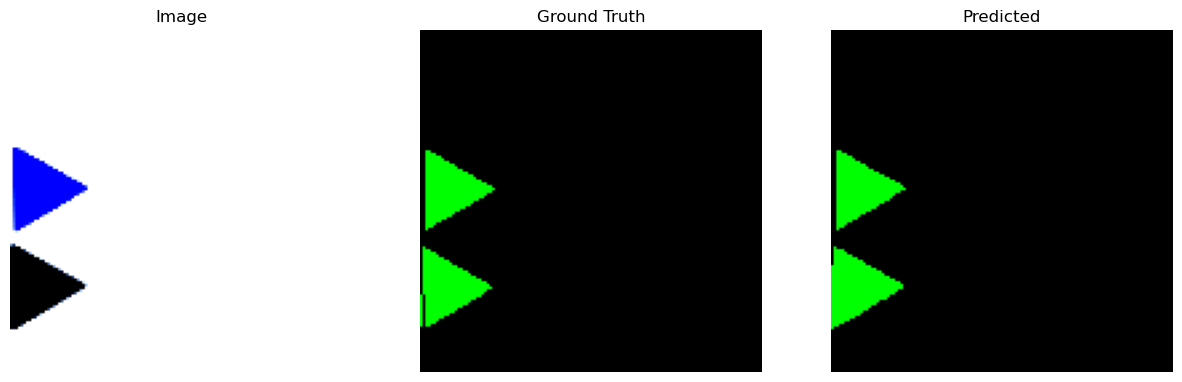

Epoch 90/100, Train Loss: 0.3299, Val Loss: 0.3333, Avg IoU: 0.7528, Avg Dice: 0.7754


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


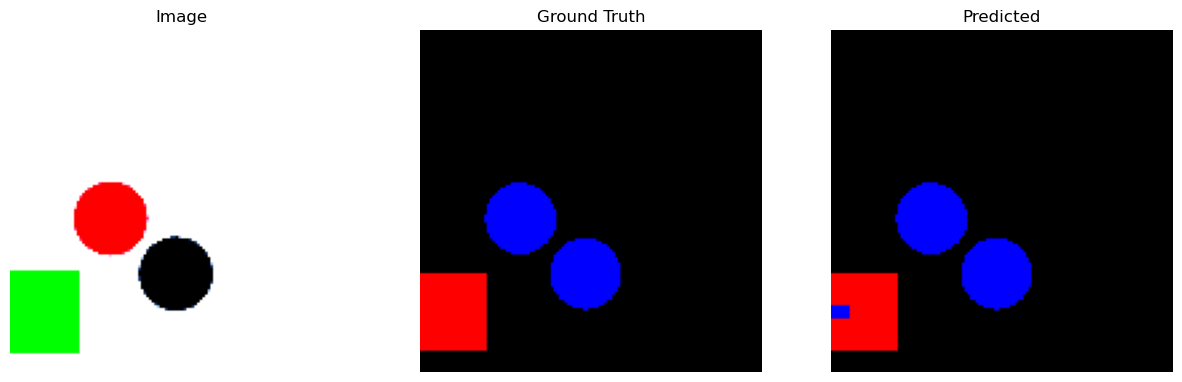

Epoch 91/100, Train Loss: 0.3293, Val Loss: 0.3355, Avg IoU: 0.7510, Avg Dice: 0.7731


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


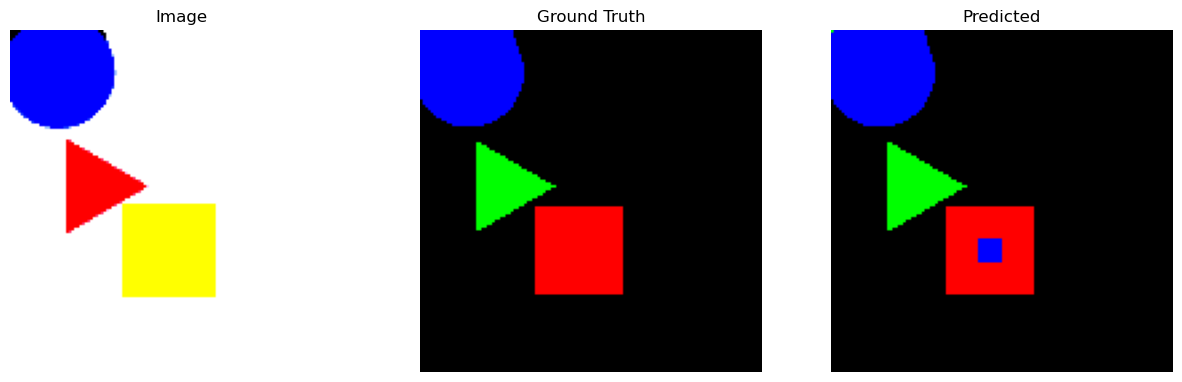

Epoch 92/100, Train Loss: 0.3293, Val Loss: 0.3332, Avg IoU: 0.7530, Avg Dice: 0.7755


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


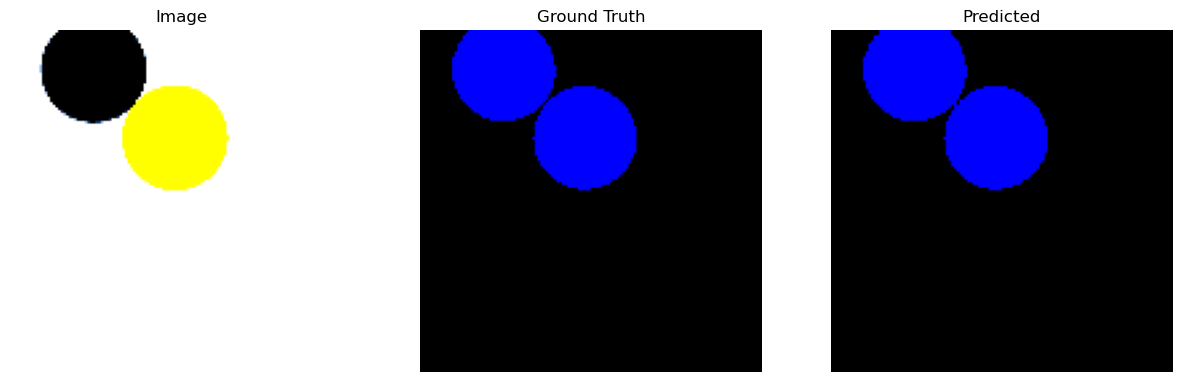

Epoch 93/100, Train Loss: 0.3301, Val Loss: 0.3329, Avg IoU: 0.7540, Avg Dice: 0.7760


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


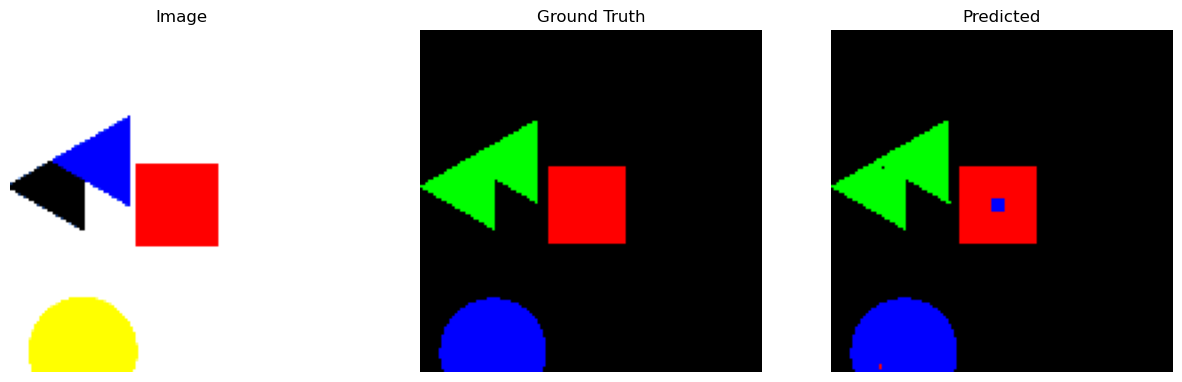

Epoch 94/100, Train Loss: 0.3299, Val Loss: 0.3334, Avg IoU: 0.7531, Avg Dice: 0.7756


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


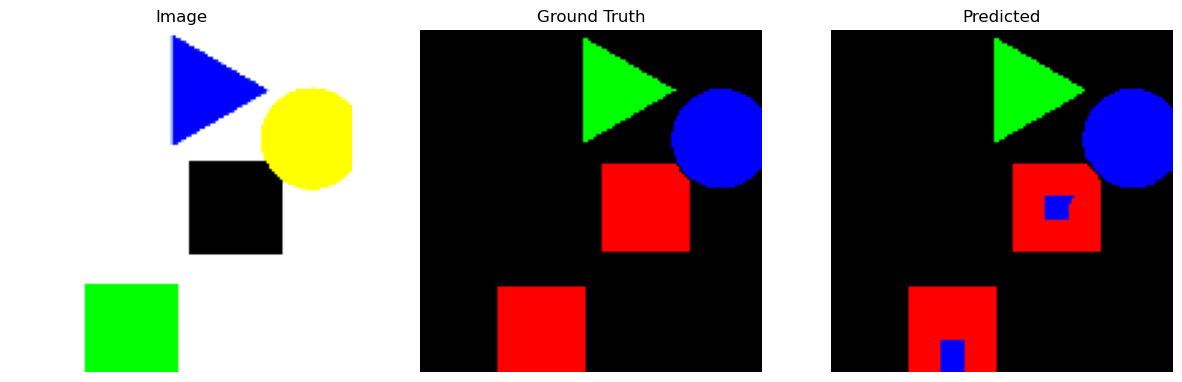

Epoch 95/100, Train Loss: 0.3294, Val Loss: 0.3364, Avg IoU: 0.7512, Avg Dice: 0.7750


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


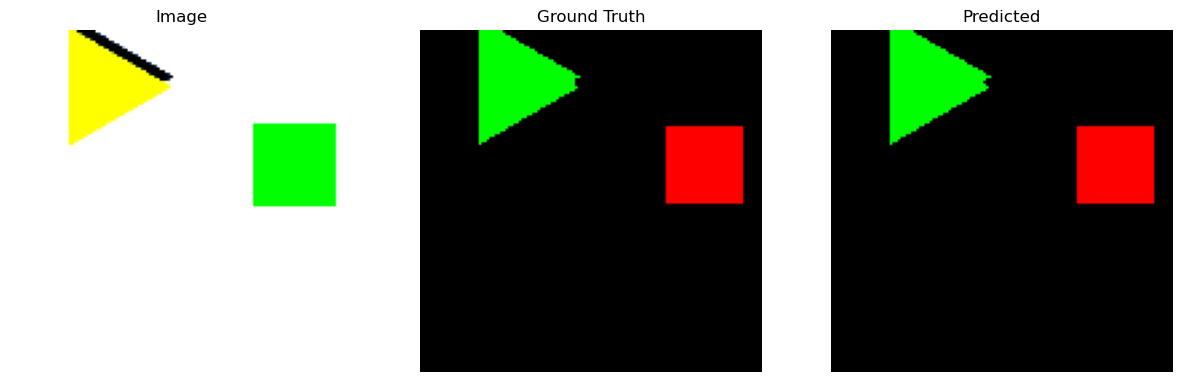

Epoch 96/100, Train Loss: 0.3298, Val Loss: 0.3354, Avg IoU: 0.7570, Avg Dice: 0.7790


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


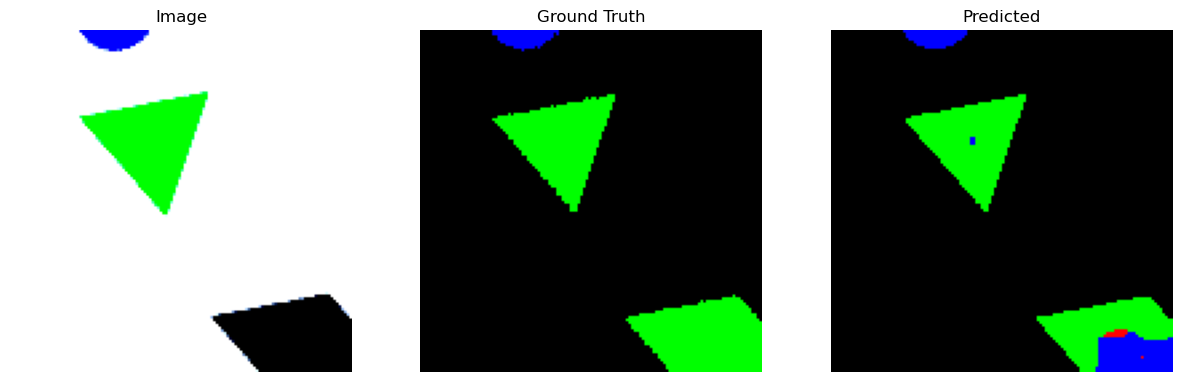

Epoch 97/100, Train Loss: 0.3293, Val Loss: 0.3331, Avg IoU: 0.7530, Avg Dice: 0.7755


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


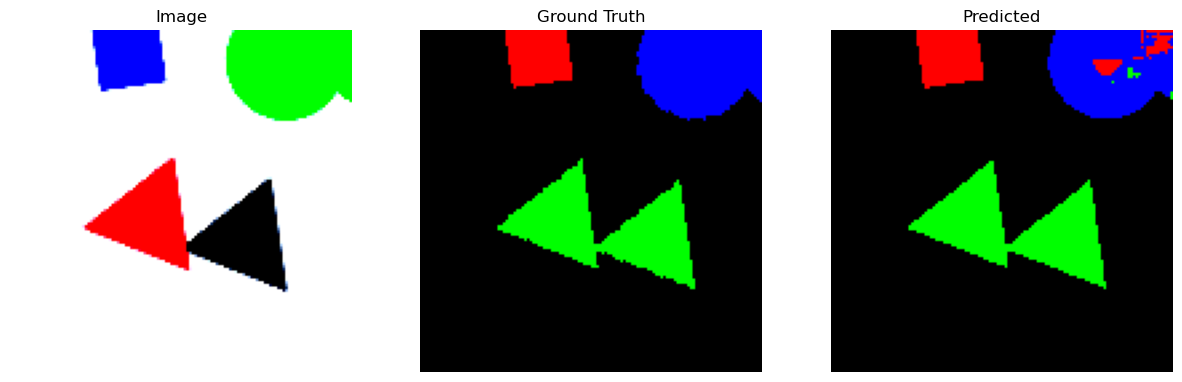

Epoch 98/100, Train Loss: 0.3294, Val Loss: 0.3342, Avg IoU: 0.7519, Avg Dice: 0.7747


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


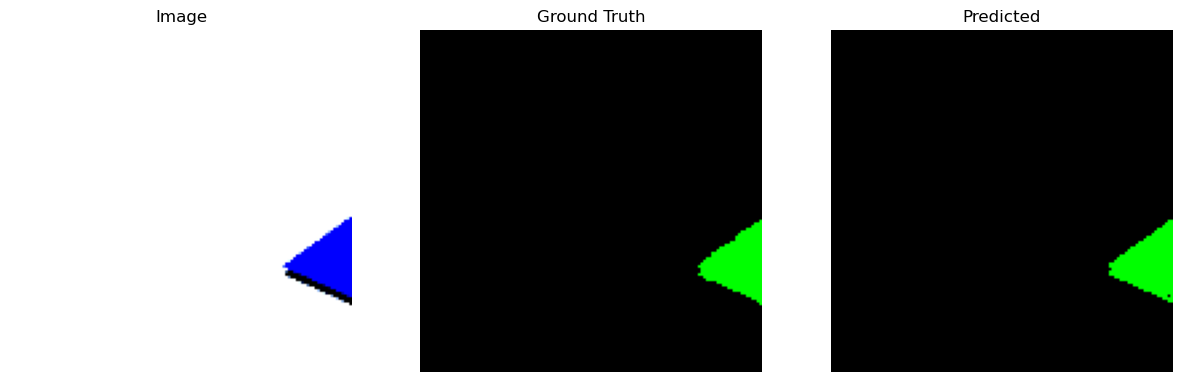

Epoch 99/100, Train Loss: 0.3299, Val Loss: 0.3335, Avg IoU: 0.7557, Avg Dice: 0.7783


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


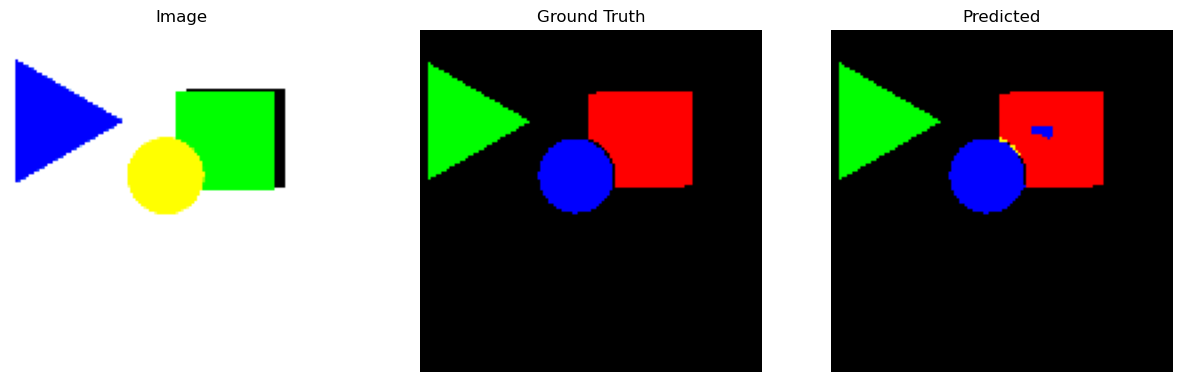

Epoch 100/100, Train Loss: 0.3299, Val Loss: 0.3358, Avg IoU: 0.7572, Avg Dice: 0.7791


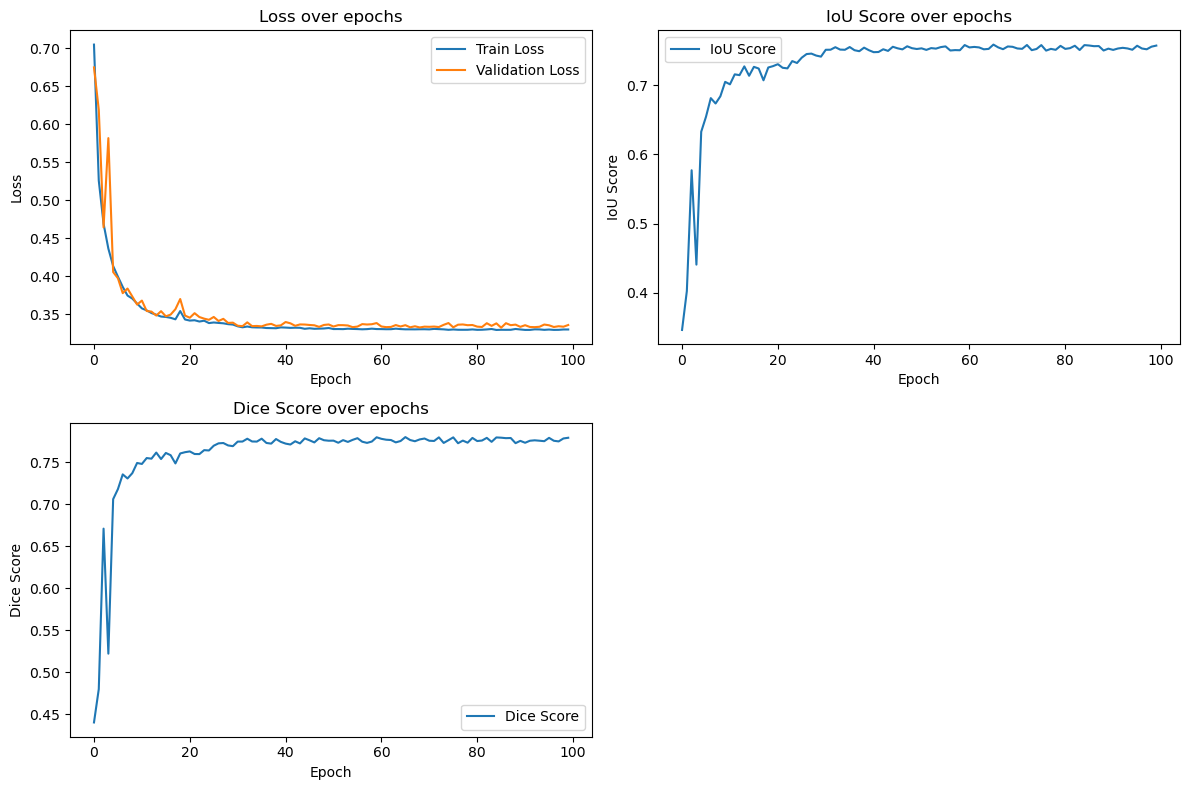

([0.7050087668199455,
  0.5258420314584862,
  0.4691103265172964,
  0.43636227621089746,
  0.41343137938364416,
  0.39937070064840063,
  0.38596533216909673,
  0.37455558416414403,
  0.37056175243538036,
  0.3639787199047111,
  0.3576454745281411,
  0.35503978429466576,
  0.3514941727693102,
  0.34929068795347634,
  0.3468976448946646,
  0.3463768765198446,
  0.34525661552901815,
  0.3432461645750873,
  0.3541407673935623,
  0.3430333543228189,
  0.34159336118219874,
  0.3420301426125135,
  0.3403377998894998,
  0.3414217449922477,
  0.3382965703014076,
  0.3390757482839545,
  0.33848586792791135,
  0.3379951769095958,
  0.3368595213489195,
  0.336334488736493,
  0.3340448825496488,
  0.33275159551682376,
  0.33377608779960677,
  0.33275291675311625,
  0.3325529458951809,
  0.3324755248242775,
  0.331795403343738,
  0.3316503257262672,
  0.3314988335764865,
  0.33262553652830884,
  0.3323654258145695,
  0.33198886960305296,
  0.3321979931146346,
  0.33208358903198465,
  0.3307656236981

In [10]:
def iou_score(output, target, num_classes):
    iou_list = []
    output = output.argmax(dim=1)
    for cls in range(num_classes):
        pred_inds = output == cls
        target_inds = target == cls
        intersection = (pred_inds & target_inds).sum()
        union = (pred_inds | target_inds).sum()
        if union == 0:
            iou_list.append(float('nan'))
        else:
            iou_list.append(float(intersection) / float(union))
    return np.nanmean(iou_list)

def dice_score(output, target, num_classes, epsilon=1e-6):
    dice_list = []
    output = output.argmax(dim=1)
    for cls in range(num_classes):
        pred_inds = output == cls
        target_inds = target == cls
        intersection = (pred_inds & target_inds).sum()
        dice = (2. * intersection + epsilon) / (pred_inds.sum() + target_inds.sum() + epsilon)
        dice_list.append(dice.item())
    return np.mean(dice_list)

def train_model(model, train_loader, validation_loader, epochs, learning_rate, num_classes):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    scheduler = StepLR(optimizer, step_size=30, gamma=0.1)
    criterion = lambda preds, labels: dice_loss(preds, labels, num_classes)  
    train_losses, val_losses, iou_scores, dice_scores = [], [], [], []

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            preds = model(images)
            loss = criterion(preds, labels)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        scheduler.step()
        train_losses.append(total_train_loss / len(train_loader))

        model.eval()
        total_val_loss = 0 
        total_iou, total_dice = 0, 0
        with torch.no_grad():
            for batch_idx, (images, labels) in enumerate(validation_loader):
                images, labels = images.to(device), labels.to(device)
                preds = model(images)
                loss = criterion(preds, labels) 
                total_val_loss += loss.item()
                total_iou += iou_score(preds, labels, num_classes)
                total_dice += dice_score(preds, labels, num_classes)

               
                if batch_idx == 0: 
                    image = images[0].cpu().permute(1, 2, 0).numpy()
                    gt_mask = class_to_rgb(labels[0].cpu().numpy())
                    pred_mask = class_to_rgb(torch.argmax(preds[0], dim=0).cpu().numpy())
                    show_image_gt_and_pred(image, gt_mask, pred_mask)
                    
        val_losses.append(total_val_loss / len(validation_loader))
        iou_scores.append(total_iou / len(validation_loader))
        dice_scores.append(total_dice / len(validation_loader))

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Avg IoU: {iou_scores[-1]:.4f}, Avg Dice: {dice_scores[-1]:.4f}")

    plt.figure(figsize=(12, 8))
    plt.subplot(2, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Loss over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(iou_scores, label='IoU Score')
    plt.title('IoU Score over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('IoU Score')
    plt.legend()

    plt.subplot(2, 2, 3)
    plt.plot(dice_scores, label='Dice Score')
    plt.title('Dice Score over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Dice Score')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return train_losses, val_losses, iou_scores, dice_scores

epochs = 100
learning_rate = 0.001
model = EnhancedModel(num_classes=5)
train_model(model, train_loader, validation_loader, epochs, learning_rate, 5)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


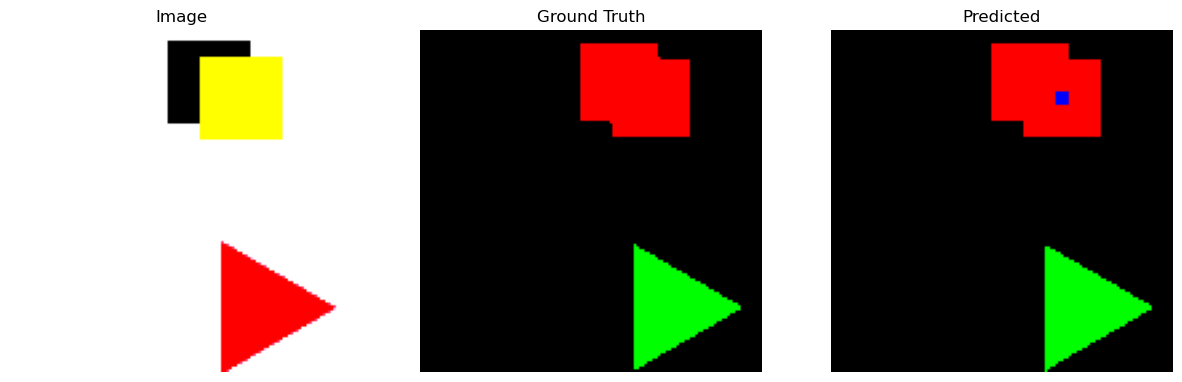

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


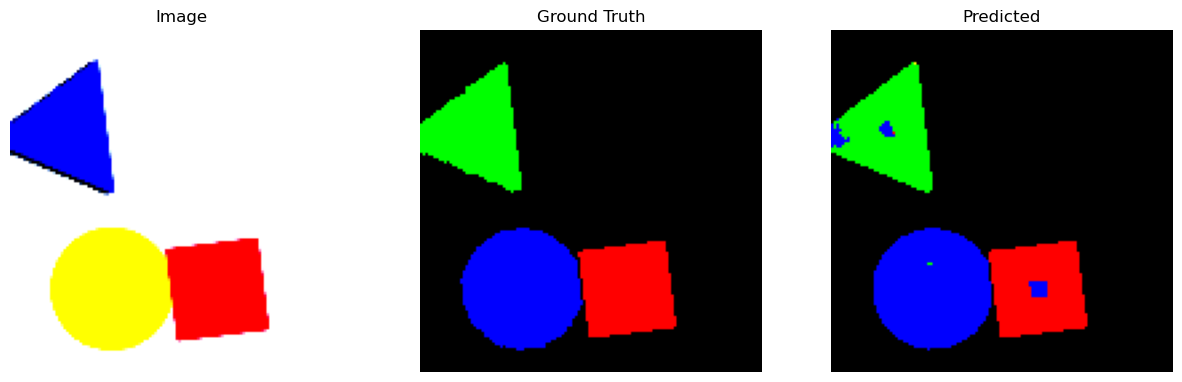

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


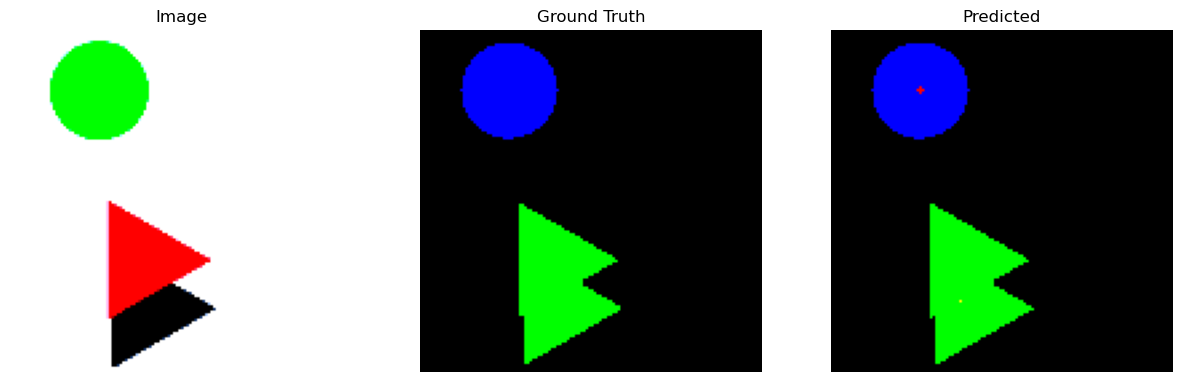

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


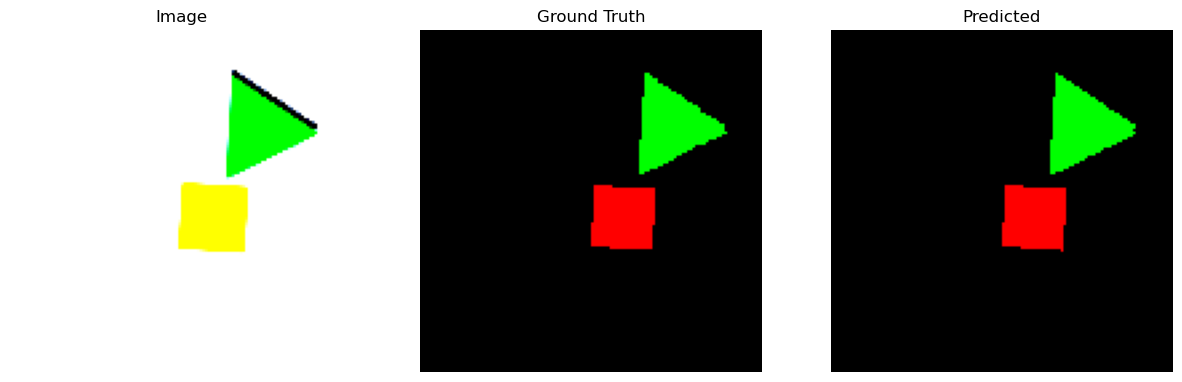

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


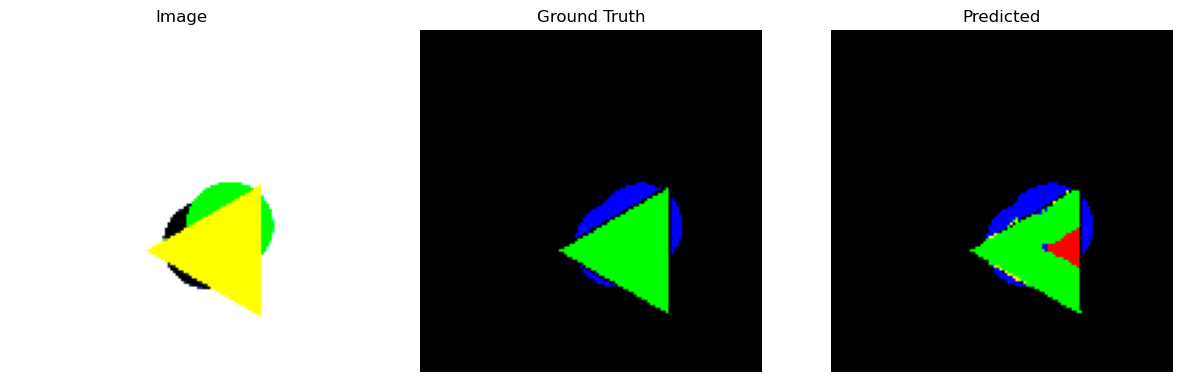

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


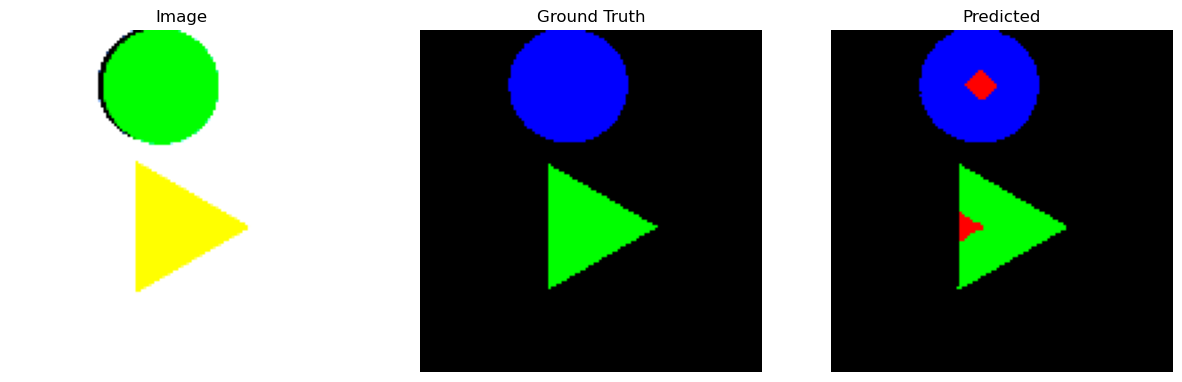

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


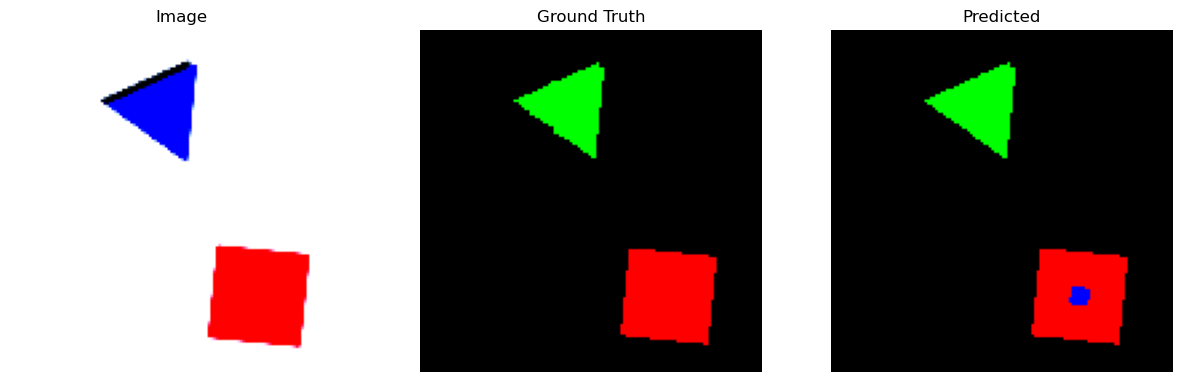

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


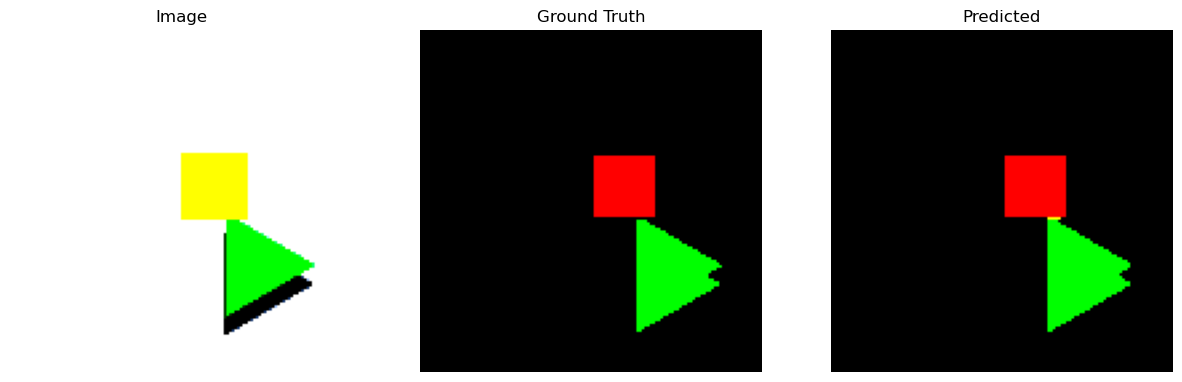

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


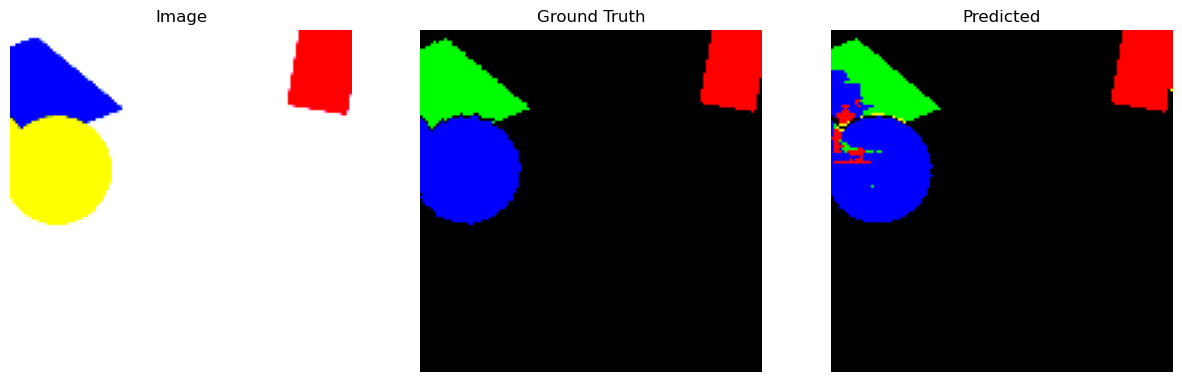

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


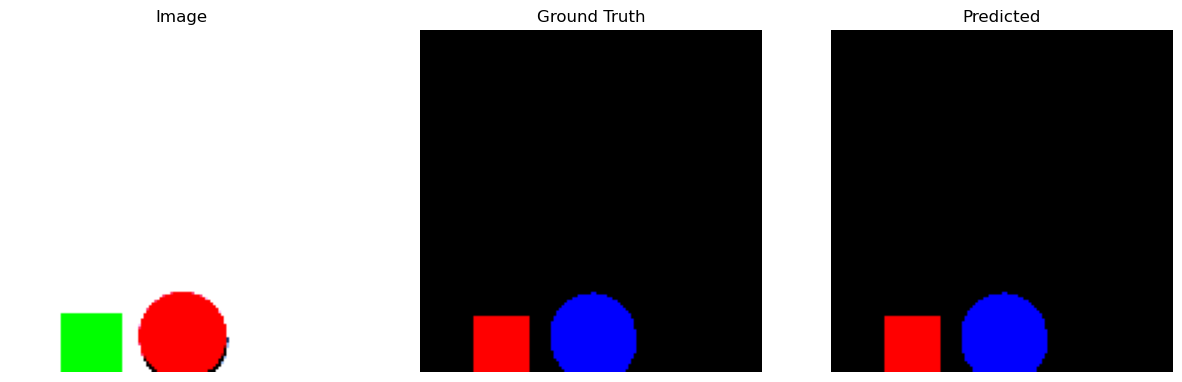

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


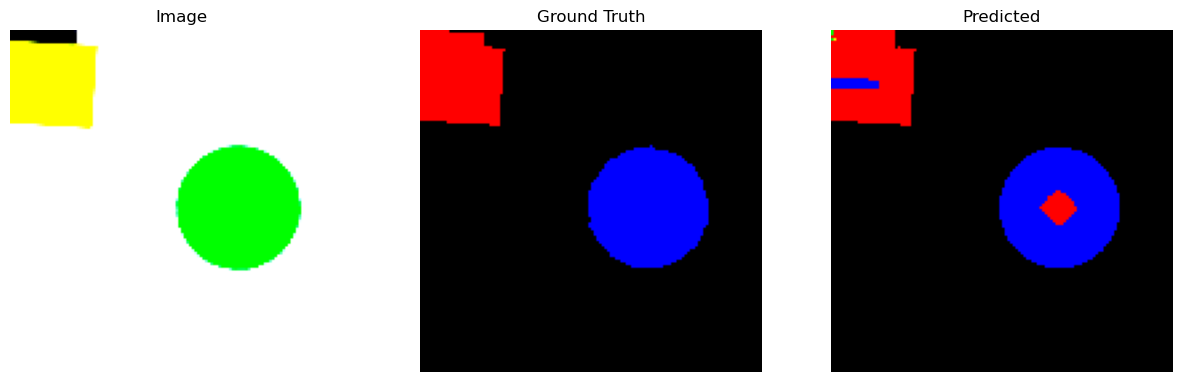

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


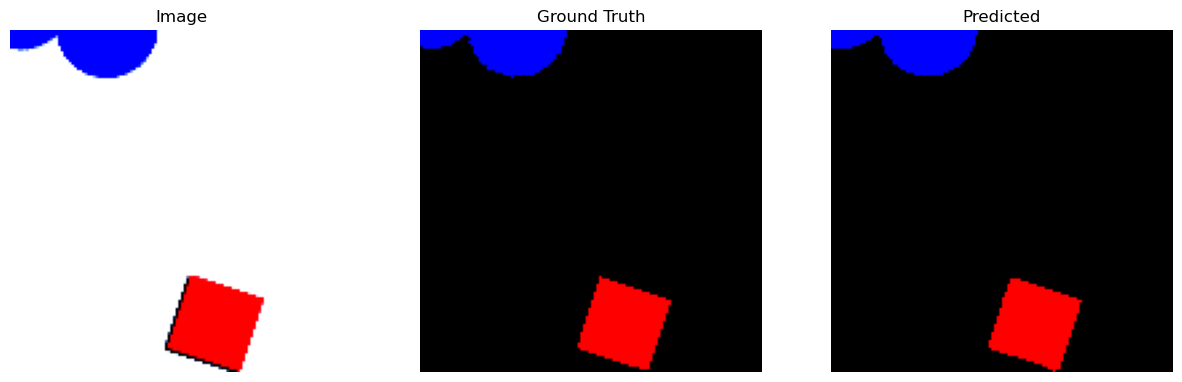

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


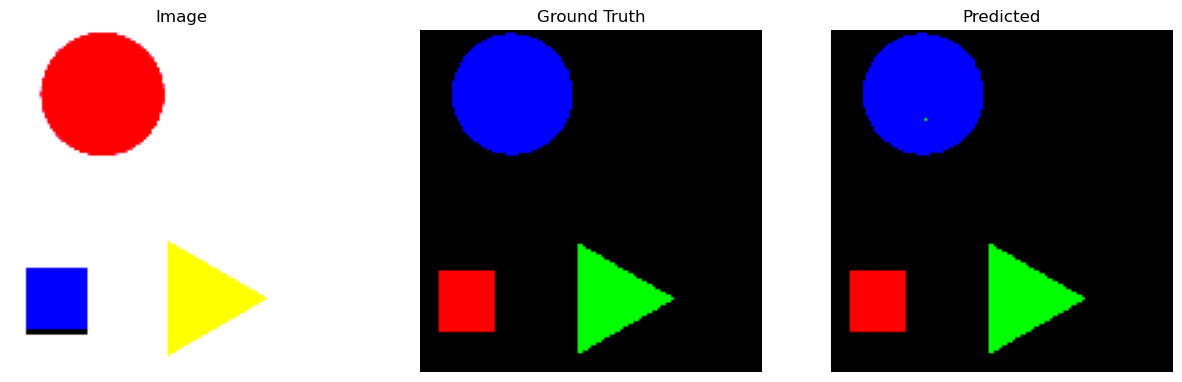

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


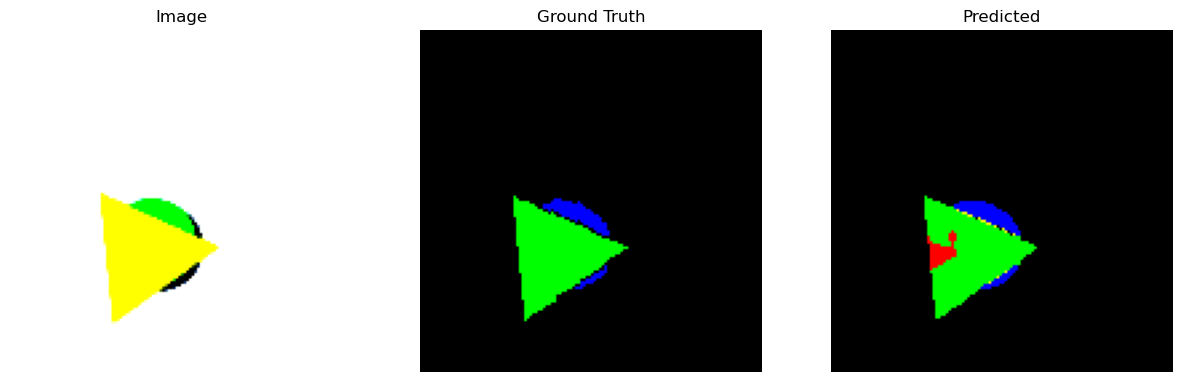

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


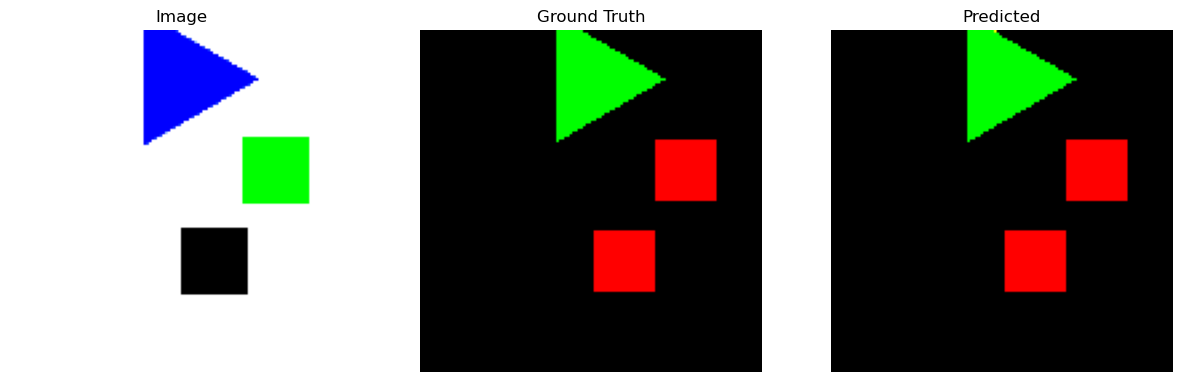

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


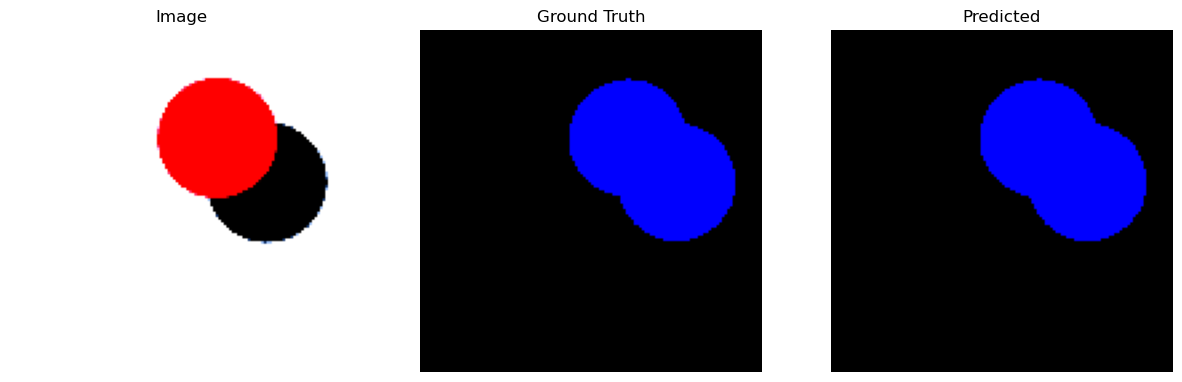

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


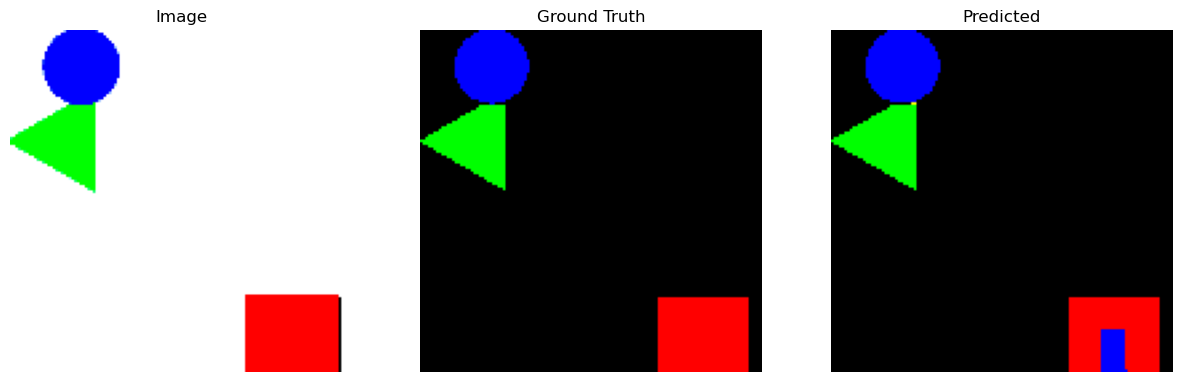

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


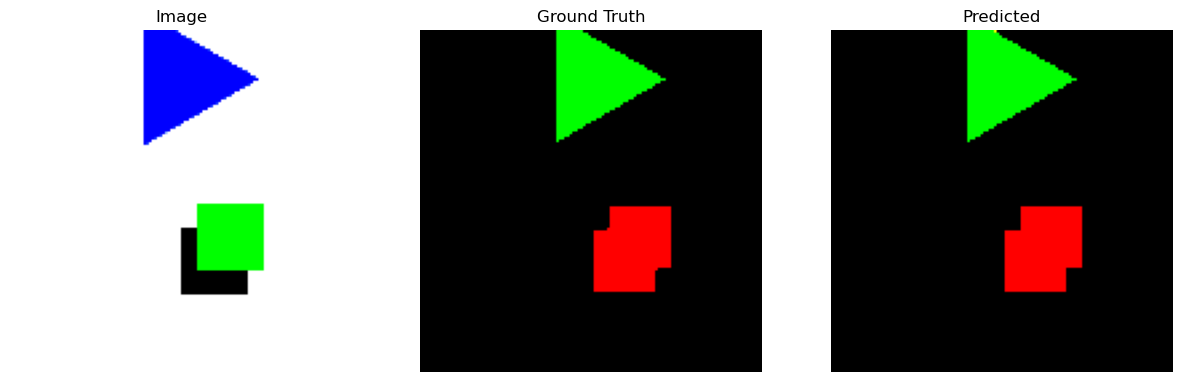

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


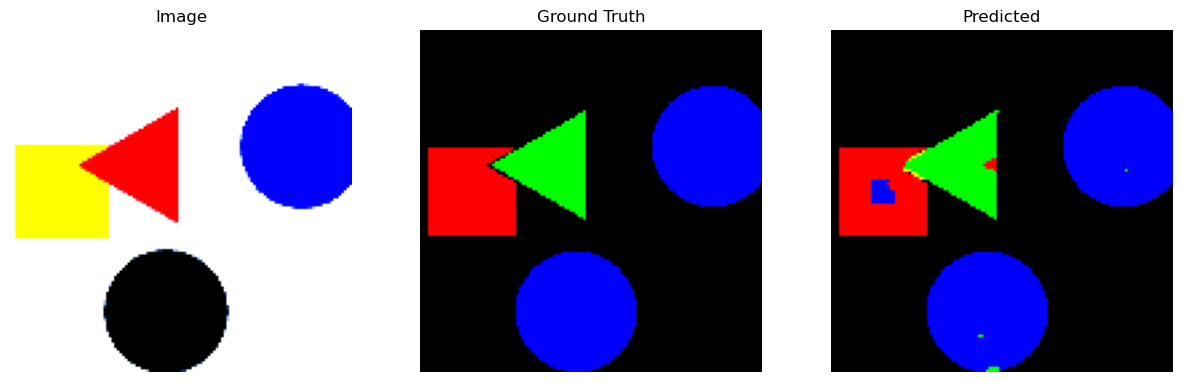

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


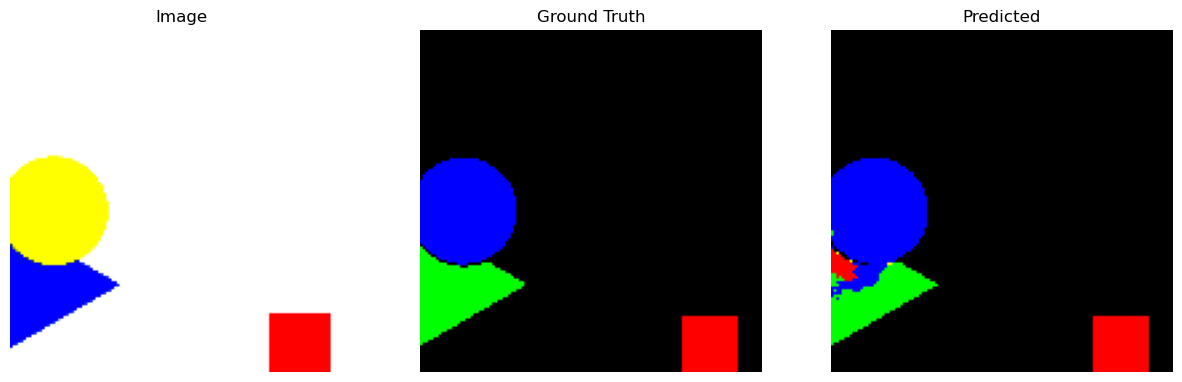

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


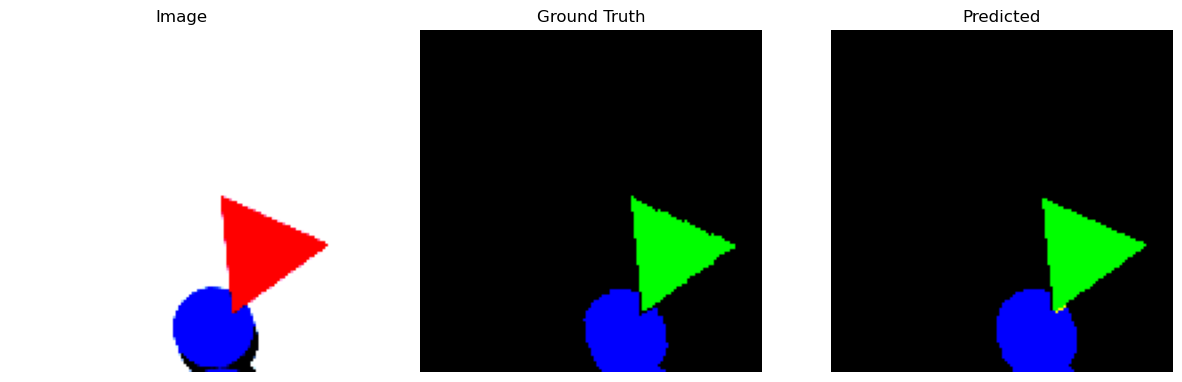

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


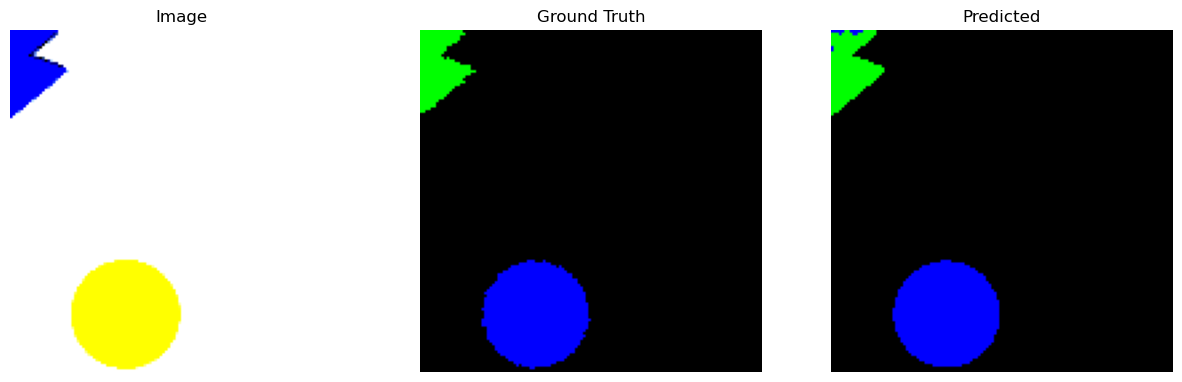

Test Loss: 0.3411, Avg IoU: 0.7614, Avg Dice: 0.7800


In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

num_classes = 5
with torch.no_grad():
    total_loss = 0
    total_iou = 0
    total_dice = 0
    count = 0

    for batch_idx, (images, labels) in enumerate(test_loader):
        images, labels = images.to(device), labels.to(device)

        preds = model(images)

        loss = dice_loss(preds, labels, num_classes=num_classes)
        total_loss += loss.item()

        total_iou += iou_score(preds, labels, num_classes=num_classes)
        total_dice += dice_score(preds, labels, num_classes=num_classes)
        
        if batch_idx < 30: 
            image = images[0].cpu().permute(1, 2, 0).numpy()
            gt_mask = labels[0].cpu().numpy()
            pred_mask = preds[0].cpu().argmax(dim=0).numpy()

            gt_rgb = class_to_rgb(gt_mask)
            pred_rgb = class_to_rgb(pred_mask)

            fig, axs = plt.subplots(1, 3, figsize=(15, 5))
            axs[0].imshow(image)
            axs[0].set_title('Image')
            axs[0].axis('off')

            axs[1].imshow(gt_rgb)
            axs[1].set_title('Ground Truth')
            axs[1].axis('off')

            axs[2].imshow(pred_rgb)
            axs[2].set_title('Predicted')
            axs[2].axis('off')

            plt.show()

        count += 1

    avg_loss = total_loss / count
    avg_iou = total_iou / count
    avg_dice = total_dice / count

    print(f"Test Loss: {avg_loss:.4f}, Avg IoU: {avg_iou:.4f}, Avg Dice: {avg_dice:.4f}")


In [15]:
def calculate_iou(preds, labels, num_classes=5):
    iou_scores = []

    preds = torch.argmax(preds, dim=1)  

    for cls in range(num_classes):
        if cls == 3:  
            continue
        preds_cls = (preds == cls)
        labels_cls = (labels == cls)

        intersection = (preds_cls & labels_cls).float().sum((1, 2))
        union = (preds_cls | labels_cls).float().sum((1, 2))

        iou = intersection / (union + 1e-6)
        iou_scores.append(iou.unsqueeze(0))

    stacked_iou_scores = torch.cat(iou_scores, dim=0)
    mean_iou = torch.nanmean(stacked_iou_scores, dim=0)

    return stacked_iou_scores, mean_iou

def calculate_dice(preds, labels, num_classes=5):
    dice_scores = []

    preds = torch.argmax(preds, dim=1)

    for cls in range(num_classes):
        if cls == 3: 
            continue
        preds_cls = (preds == cls)
        labels_cls = (labels == cls)

        intersection = (preds_cls & labels_cls).float().sum((1, 2))
        dice = (2. * intersection) / (preds_cls.float().sum((1, 2)) + labels_cls.float().sum((1, 2)) + 1e-6)
        dice_scores.append(dice.unsqueeze(0))

    stacked_dice_scores = torch.cat(dice_scores, dim=0)
    mean_dice = torch.nanmean(stacked_dice_scores, dim=0)

    return stacked_dice_scores, mean_dice

def test_and_print_metrics(model, test_loader, device, num_classes=5):
    model.eval()

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            class_iou_scores, mean_iou = calculate_iou(outputs, labels, num_classes=num_classes)
            class_dice_scores, mean_dice = calculate_dice(outputs, labels, num_classes=num_classes)
            
            print("Metrics by class (excluding Class 2):")
            for cls in range(num_classes):
                if cls == 3:  
                    continue
                adjusted_index = cls if cls < 2 else cls - 1
                print(f"Class {cls}: IoU: {class_iou_scores[adjusted_index].mean().item()}, Dice: {class_dice_scores[adjusted_index].mean().item()}")
            print(f"Mean IoU: {mean_iou.mean().item()}, Mean Dice: {mean_dice.mean().item()}")

            break  

In [16]:
test_and_print_metrics(model, test_loader, device, num_classes=5)

Metrics by class (excluding Class 2):
Class 0: IoU: 0.9977747201919556, Dice: 0.9988851547241211
Class 1: IoU: 0.7945170402526855, Dice: 0.8167555332183838
Class 2: IoU: 0.7945170402526855, Dice: 0.8167555332183838
Class 4: IoU: 0.6867796182632446, Dice: 0.7016420364379883
Mean IoU: 0.8194959163665771, Mean Dice: 0.8344082236289978


# Task 3

We want to be able to compute the accuracy on the ```validation``` split at the end of each epoch. Adapt question 2 such that we can do so. 
Do not forget to put your model in ```eval``` when computing your predictions and put it back in ```train``` after.

# Task 4

Is ```accuracy```  a good metric for the task at hand? Why? ```hint:``` Try to compare your results ```qualitatively``` and ```quantitatively```.

# Task 5

If you answered in a negative way for Question 5, which would be a better metric for the task? Can you use it for the current project? Don't forget to present your answers in the seminar.

# Task 6

As we did for the classification lab, go through the transformation documention. Did you find any that helps? Why?